# Deep Neural Networks

In [30]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.recurrent import SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor
import numpy
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import LabelEncoder
import os

### Processing the dataset 

#### Data loading and manipulating

In [3]:
def get_data():
    #get train data
    train_data_path ='/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
    #reading train data
    train , test = get_data()

#     df["code"] = df["code"].map(lambda code: code[-12:-1])
    train['label'] = train['label'].map(lambda label: label/1000000)
    test['label'] = test['label'].map(lambda label: label/1000000)

    combined = train.append(test)
    
    target = combined.label

    combined.reset_index(inplace=True)
    
    combined.drop(['index', 'Id'], inplace=True, axis=1)
    return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

# print(combined)
combined.shape

(1262, 38)

In [4]:
combined.describe()

,PAPI_TOT_INS,PAPI_TOT_CYC,PAPI_L2_ICH,PAPI_L2_ICA,PAPI_L2_ICM,PAPI_L2_TCH,PAPI_L2_TCA,PAPI_L2_TCM,PAPI_L2_DCH,PAPI_L2_DCA,...,PAPI_VEC_INS,PAPI_RES_STL,PAPI_FML_INS,PAPI_FAD_INS,PAPI_FDV_INS,PAPI_FSQ_INS,PAPI_FP_OPS,PAPI_SP_OPS,PAPI_DP_OPS,label
count,1.262000e+03,1.262000e+03,1262.000000,1262.000000,1262.000000,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,...,1.262000e+03,1.262000e+03,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,2.054094e+06,4.962138e+06,2415.736133,2506.555468,69.875594,2.163197e+03,1.156967e+06,3.829463e+04,2.310412e+04,6.128574e+04,...,8.785141e+04,3.508096e+06,2949.709984,4930.954041,840.662441,840.662441,8721.326466,0.042789,8721.283677,3744.229323
std,1.319939e+07,4.892838e+07,11062.537659,10988.180363,521.438173,2.205276e+05,8.837702e+06,4.826413e+05,1.803663e+05,6.540491e+05,...,6.934838e+05,3.995092e+07,12453.025263,18526.445904,4699.121674,4699.121674,32499.796209,0.289506,32499.681034,8492.425225
min,1.910000e+02,3.860000e+02,1.000000,0.000000,0.000000,-4.359704e+06,9.500000e+01,0.000000e+00,5.000000e+00,1.000000e+00,...,0.000000e+00,3.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.572500
25%,1.715700e+04,2.239500e+04,373.000000,389.500000,0.000000,6.035000e+02,7.386000e+03,0.000000e+00,2.070000e+02,2.090000e+02,...,8.000000e+01,2.534000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.099125
50%,9.329950e+04,1.057185e+05,710.000000,732.000000,0.000000,1.078500e+03,3.914200e+04,0.000000e+00,3.290000e+02,3.330000e+02,...,1.086500e+03,2.023550e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,510.293250
75%,7.239908e+05,5.297315e+05,1396.250000,1425.750000,4.750000,2.958750e+03,2.470778e+05,5.000000e+00,1.309750e+03,1.452000e+03,...,2.924700e+04,1.768418e+05,136.000000,214.250000,38.750000,38.750000,519.500000,0.000000,519.500000,3066.702250
max,2.120563e+08,6.875720e+08,321032.000000,312449.000000,9706.000000,7.870790e+05,1.302012e+08,9.178270e+06,3.229486e+06,1.239346e+07,...,2.002418e+07,6.006403e+08,183833.000000,261284.000000,60000.000000,60000.000000,449235.000000,2.000000,449235.000000,87830.903500


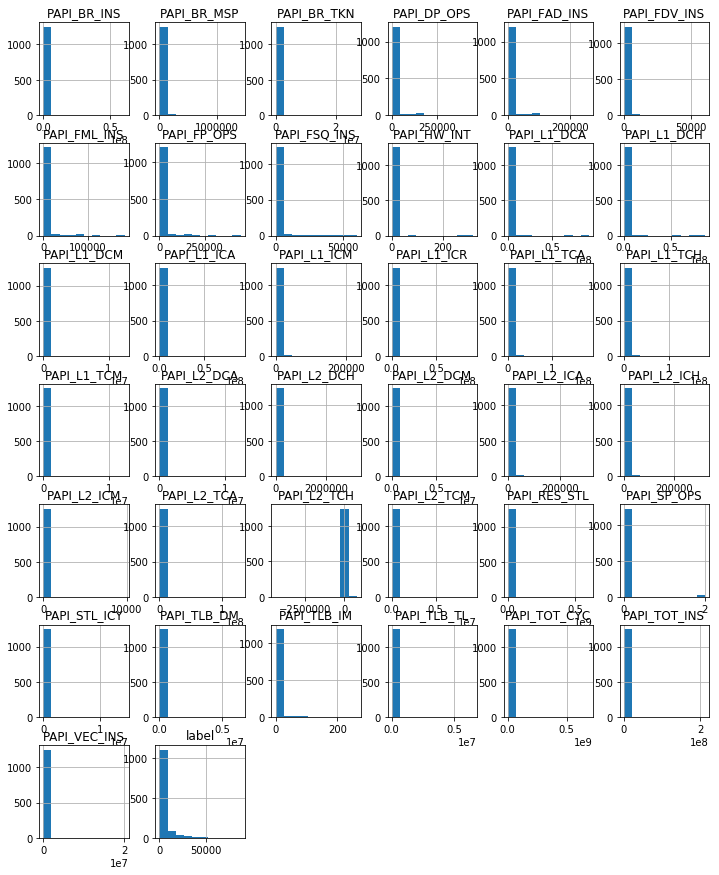

In [5]:
#combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,15))
plt.show()

#### Correlation with label

[0.228434997544552, 0.22987799268530415, 0.34680272459075945, 0.47441560215696205, 0.4219948945876075, 0.4219948945876075, 0.4643408635143398, 0.46434177234776763]
['PAPI_L2_ICH', 'PAPI_L2_ICA', 'PAPI_FML_INS', 'PAPI_FAD_INS', 'PAPI_FDV_INS', 'PAPI_FSQ_INS', 'PAPI_FP_OPS', 'PAPI_DP_OPS']


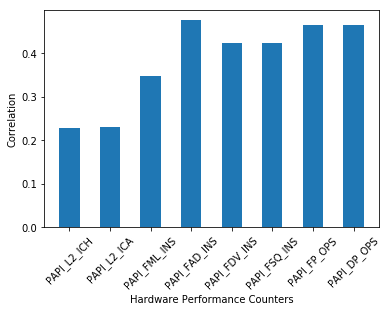

In [11]:
# train_data['Target'] = target

C_mat = combined.corr()
# C_mat = C_mat['label']
# C_mat = [i for i in C_mat ]
# print(C_mat)
column_headers = list(C_mat.columns.values)
# print(column_headers)
C_mat = C_mat['label']
# print(C_mat)
# print(list(C_mat))
# C_mat.plot().hist()
C_mat = list(C_mat)

heights = []
cols = []

for i in range(len(C_mat)):
    if column_headers[i] == 'label':
        continue
    if C_mat[i] > 0.2:
        heights.append(C_mat[i])
        cols.append(column_headers[i])
        
print(heights)
print(cols)

fig, ax = plt.subplots()
positions = range(0, len(heights))
ax.bar(positions, heights, 0.5)
ax.set_xticks(range(len(heights)))
ax.set_xticklabels(cols, rotation=45)
ax.set_xlabel('Hardware Performance Counters')
ax.set_ylabel('Correlation')
# plt.plot(C_mat, column_headers)
plt.show()

#### Heatmap

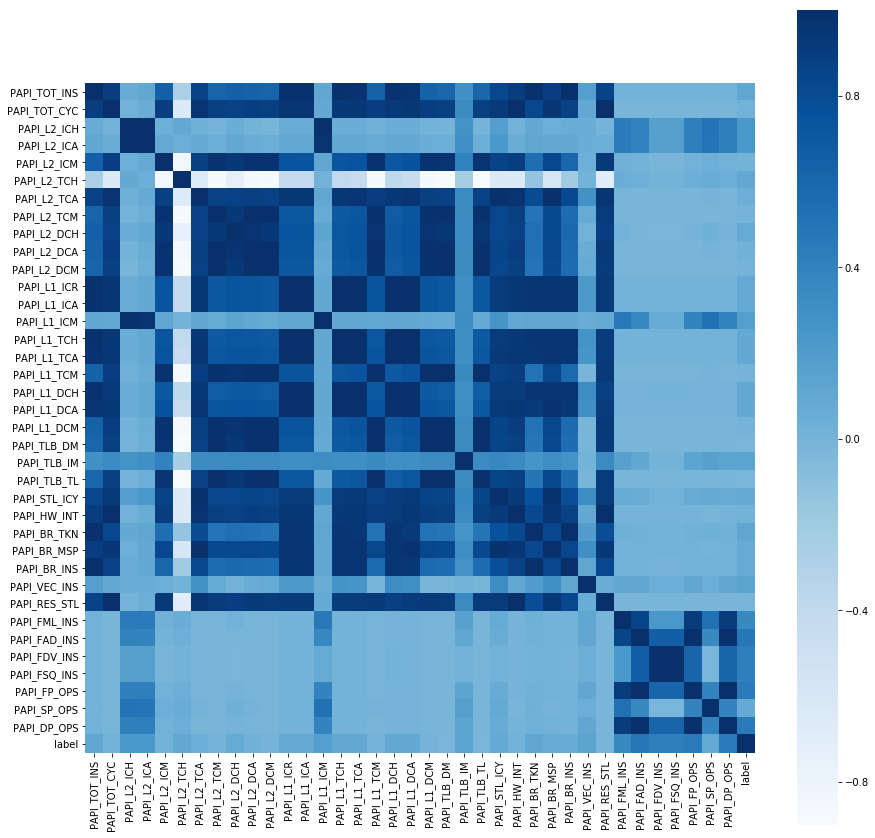

In [12]:
C_mat = combined.corr()

fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, annot = False, vmax = 1, square = True, cmap="Blues")
#     sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

#### Data splitting
actually not used in our final version, cause we introduce cross-validation below

In [13]:
# split_num = len(train_data)
# def split_combined():
#     global combined
#     train = combined[:split_num]
#     test = combined[split_num:]

#     return train , test 

In [14]:
# train, test = split_combined()
# train.drop(['label'],axis = 1 , inplace = True)
# test.drop(['label'],axis = 1 , inplace = True)

# # print(target)
# # train.shape
# print(combined.as_matrix()[0])
# print(list(target)[0])

### K-fold Cross Validation

In [17]:
seed = 7
numpy.random.seed(seed)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# kfold = GroupKFold(n_splits=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

combined.drop(['label'],axis = 1 , inplace = True)

# X = np.array(combined)
# Y = np.array(target)

X = combined.as_matrix()
Y = target.as_matrix()
# Y = Y.reshape((1, len(Y)))
print(X.shape)
print(Y.shape)
# print(Y)

# type_of_target(Y)

# label_encoder = LabelEncoder()
# Y = label_encoder.fit_transform(Y)

# type_of_target(Y)
print(Y)

(1262, 37)
(1262,)
[11496.264     78.324   9331.5405 ...   122.7025 15579.5985   381.8235]


In [18]:
train_idx_list = []
test_idx_list = []
for train_idx, test_idx in kfold.split(X):
    train_idx_list.append(train_idx)
    test_idx_list.append(test_idx)


In [19]:
for train_idx in train_idx_list:
    print(train_idx[:20])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8 10 11 14 16 18 19 21 22 24 25 26]
[ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 0  1  2  3  4  5  7  9 10 11 12 13 14 15 16 17 18 20 21 22]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21]
[ 1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 18 19 20 21 22]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20]
[ 0  2  3  4  6  7  8  9 10 12 13 14 15 16 17 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [21]:
# print(test_idx_list)

### Model Training

#### DNN Model

In [18]:
fold_cnt = 0

assert(len(train_idx_list) == len(test_idx_list))

# for train_idx, test_idx in kfold.split(X, Y):
for i in range(len(train_idx_list)):
# for i in range(3):
    train_idx = train_idx_list[i]
    fold_cnt += 1
    train = X[train_idx]
    train_y = Y[train_idx]
    
    NN_model = Sequential()
    NN_model.add(Dense(64, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))
#     train.shape
#     NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    
    # NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    # NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
    NN_model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    NN_model.summary()

    checkpoint_name = 'Weights-fold%d-{epoch:03d}--{val_loss:.5f}.hdf5' % (fold_cnt)
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]

    NN_model.fit(train, train_y, epochs=1000, batch_size=32, validation_split = 0.1
                 , callbacks=callbacks_list
                )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2432      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________
Train on 1021 samples, validate on 114 samples
Epoch 1/1000
1021/1021 [==============================] - 0s 25us/step - loss: 5927.0440 - 

1021/1021 [==============================] - 0s 40us/step - loss: 125.9303 - mean_absolute_error: 2148.8391 - mean_absolute_percentage_error: 125.9303 - val_loss: 57.1670 - val_mean_absolute_error: 2237.2328 - val_mean_absolute_percentage_error: 57.1670

Epoch 00022: val_loss did not improve from 50.23093
Epoch 23/1000
1021/1021 [==============================] - 0s 26us/step - loss: 96.0835 - mean_absolute_error: 2086.3868 - mean_absolute_percentage_error: 96.0835 - val_loss: 57.3003 - val_mean_absolute_error: 2097.6311 - val_mean_absolute_percentage_error: 57.3003

Epoch 00023: val_loss did not improve from 50.23093
Epoch 24/1000
1021/1021 [==============================] - 0s 28us/step - loss: 84.6371 - mean_absolute_error: 1952.6046 - mean_absolute_percentage_error: 84.6371 - val_loss: 50.8273 - val_mean_absolute_error: 2056.5310 - val_mean_absolute_percentage_error: 50.8273

Epoch 00024: val_loss did not improve from 50.23093
Epoch 25/1000
1021/1021 [==============================


Epoch 00046: val_loss did not improve from 38.67853
Epoch 47/1000
1021/1021 [==============================] - 0s 35us/step - loss: 260.7006 - mean_absolute_error: 3369.4869 - mean_absolute_percentage_error: 260.7006 - val_loss: 56.4793 - val_mean_absolute_error: 2066.9564 - val_mean_absolute_percentage_error: 56.4793

Epoch 00047: val_loss did not improve from 38.67853
Epoch 48/1000
1021/1021 [==============================] - 0s 34us/step - loss: 358.7124 - mean_absolute_error: 2574.9109 - mean_absolute_percentage_error: 358.7124 - val_loss: 90.1449 - val_mean_absolute_error: 2188.9210 - val_mean_absolute_percentage_error: 90.1449

Epoch 00048: val_loss did not improve from 38.67853
Epoch 49/1000
1021/1021 [==============================] - 0s 37us/step - loss: 163.4704 - mean_absolute_error: 2562.0620 - mean_absolute_percentage_error: 163.4704 - val_loss: 68.6037 - val_mean_absolute_error: 2431.0038 - val_mean_absolute_percentage_error: 68.6037

Epoch 00049: val_loss did not improv


Epoch 00097: val_loss did not improve from 38.67853
Epoch 98/1000
1021/1021 [==============================] - 0s 72us/step - loss: 78.7648 - mean_absolute_error: 2182.1597 - mean_absolute_percentage_error: 78.7648 - val_loss: 65.0359 - val_mean_absolute_error: 2587.1213 - val_mean_absolute_percentage_error: 65.0359

Epoch 00098: val_loss did not improve from 38.67853
Epoch 99/1000
1021/1021 [==============================] - 0s 69us/step - loss: 59.4498 - mean_absolute_error: 2099.3196 - mean_absolute_percentage_error: 59.4498 - val_loss: 48.1822 - val_mean_absolute_error: 2136.2039 - val_mean_absolute_percentage_error: 48.1822

Epoch 00099: val_loss did not improve from 38.67853
Epoch 100/1000
1021/1021 [==============================] - 0s 59us/step - loss: 50.4042 - mean_absolute_error: 1946.5971 - mean_absolute_percentage_error: 50.4042 - val_loss: 41.2498 - val_mean_absolute_error: 1985.1183 - val_mean_absolute_percentage_error: 41.2498

Epoch 00100: val_loss did not improve fro


Epoch 00122: val_loss did not improve from 31.83737
Epoch 123/1000
1021/1021 [==============================] - 0s 53us/step - loss: 37.5588 - mean_absolute_error: 1451.2495 - mean_absolute_percentage_error: 37.5588 - val_loss: 35.4090 - val_mean_absolute_error: 1633.2808 - val_mean_absolute_percentage_error: 35.4090

Epoch 00123: val_loss did not improve from 31.83737
Epoch 124/1000
1021/1021 [==============================] - 0s 54us/step - loss: 35.2599 - mean_absolute_error: 1299.3386 - mean_absolute_percentage_error: 35.2599 - val_loss: 39.5607 - val_mean_absolute_error: 1784.1963 - val_mean_absolute_percentage_error: 39.5607

Epoch 00124: val_loss did not improve from 31.83737
Epoch 125/1000
1021/1021 [==============================] - 0s 43us/step - loss: 35.8923 - mean_absolute_error: 1298.5101 - mean_absolute_percentage_error: 35.8923 - val_loss: 42.0708 - val_mean_absolute_error: 1944.3987 - val_mean_absolute_percentage_error: 42.0708

Epoch 00125: val_loss did not improve f


Epoch 00173: val_loss did not improve from 31.83737
Epoch 174/1000
1021/1021 [==============================] - 0s 72us/step - loss: 31.9520 - mean_absolute_error: 1166.8391 - mean_absolute_percentage_error: 31.9520 - val_loss: 71.9502 - val_mean_absolute_error: 1748.0186 - val_mean_absolute_percentage_error: 71.9502

Epoch 00174: val_loss did not improve from 31.83737
Epoch 175/1000
1021/1021 [==============================] - 0s 90us/step - loss: 32.6475 - mean_absolute_error: 1181.9337 - mean_absolute_percentage_error: 32.6475 - val_loss: 70.2073 - val_mean_absolute_error: 1835.5933 - val_mean_absolute_percentage_error: 70.2073

Epoch 00175: val_loss did not improve from 31.83737
Epoch 176/1000
1021/1021 [==============================] - 0s 71us/step - loss: 32.1820 - mean_absolute_error: 1172.8003 - mean_absolute_percentage_error: 32.1820 - val_loss: 74.6548 - val_mean_absolute_error: 1616.5971 - val_mean_absolute_percentage_error: 74.6548

Epoch 00176: val_loss did not improve f


Epoch 00224: val_loss did not improve from 31.83737
Epoch 225/1000
1021/1021 [==============================] - 0s 39us/step - loss: 42.9492 - mean_absolute_error: 1595.5725 - mean_absolute_percentage_error: 42.9492 - val_loss: 38.6939 - val_mean_absolute_error: 1669.3528 - val_mean_absolute_percentage_error: 38.6939

Epoch 00225: val_loss did not improve from 31.83737
Epoch 226/1000
1021/1021 [==============================] - 0s 38us/step - loss: 41.9725 - mean_absolute_error: 1573.2792 - mean_absolute_percentage_error: 41.9725 - val_loss: 39.7694 - val_mean_absolute_error: 1888.0397 - val_mean_absolute_percentage_error: 39.7694

Epoch 00226: val_loss did not improve from 31.83737
Epoch 227/1000
1021/1021 [==============================] - 0s 39us/step - loss: 39.4918 - mean_absolute_error: 1547.9027 - mean_absolute_percentage_error: 39.4918 - val_loss: 35.3561 - val_mean_absolute_error: 1685.6713 - val_mean_absolute_percentage_error: 35.3561

Epoch 00227: val_loss did not improve f


Epoch 00275: val_loss did not improve from 31.83737
Epoch 276/1000
1021/1021 [==============================] - 0s 43us/step - loss: 36.9114 - mean_absolute_error: 1495.6626 - mean_absolute_percentage_error: 36.9114 - val_loss: 37.4038 - val_mean_absolute_error: 1659.1175 - val_mean_absolute_percentage_error: 37.4038

Epoch 00276: val_loss did not improve from 31.83737
Epoch 277/1000
1021/1021 [==============================] - 0s 46us/step - loss: 36.6422 - mean_absolute_error: 1434.3196 - mean_absolute_percentage_error: 36.6422 - val_loss: 34.0445 - val_mean_absolute_error: 1649.7659 - val_mean_absolute_percentage_error: 34.0445

Epoch 00277: val_loss did not improve from 31.83737
Epoch 278/1000
1021/1021 [==============================] - 0s 50us/step - loss: 35.8731 - mean_absolute_error: 1471.8333 - mean_absolute_percentage_error: 35.8731 - val_loss: 34.7903 - val_mean_absolute_error: 1786.8274 - val_mean_absolute_percentage_error: 34.7903

Epoch 00278: val_loss did not improve f

1021/1021 [==============================] - 0s 36us/step - loss: 32.4778 - mean_absolute_error: 1394.3924 - mean_absolute_percentage_error: 32.4778 - val_loss: 33.3489 - val_mean_absolute_error: 1787.1588 - val_mean_absolute_percentage_error: 33.3489

Epoch 00326: val_loss did not improve from 28.96690
Epoch 327/1000
1021/1021 [==============================] - 0s 41us/step - loss: 31.4380 - mean_absolute_error: 1362.7059 - mean_absolute_percentage_error: 31.4380 - val_loss: 30.5369 - val_mean_absolute_error: 1690.5321 - val_mean_absolute_percentage_error: 30.5369

Epoch 00327: val_loss did not improve from 28.96690
Epoch 328/1000
1021/1021 [==============================] - 0s 38us/step - loss: 31.1143 - mean_absolute_error: 1411.3060 - mean_absolute_percentage_error: 31.1143 - val_loss: 33.3067 - val_mean_absolute_error: 1548.4211 - val_mean_absolute_percentage_error: 33.3067

Epoch 00328: val_loss did not improve from 28.96690
Epoch 329/1000
1021/1021 [=============================


Epoch 00376: val_loss did not improve from 26.43807
Epoch 377/1000
1021/1021 [==============================] - 0s 38us/step - loss: 28.8381 - mean_absolute_error: 1194.9319 - mean_absolute_percentage_error: 28.8381 - val_loss: 30.5989 - val_mean_absolute_error: 1548.3307 - val_mean_absolute_percentage_error: 30.5989

Epoch 00377: val_loss did not improve from 26.43807
Epoch 378/1000
1021/1021 [==============================] - 0s 40us/step - loss: 30.0338 - mean_absolute_error: 1291.3610 - mean_absolute_percentage_error: 30.0338 - val_loss: 36.5252 - val_mean_absolute_error: 1545.9243 - val_mean_absolute_percentage_error: 36.5252

Epoch 00378: val_loss did not improve from 26.43807
Epoch 379/1000
1021/1021 [==============================] - 0s 40us/step - loss: 28.4234 - mean_absolute_error: 1152.8282 - mean_absolute_percentage_error: 28.4234 - val_loss: 30.0714 - val_mean_absolute_error: 1534.1006 - val_mean_absolute_percentage_error: 30.0715

Epoch 00379: val_loss did not improve f


Epoch 00427: val_loss did not improve from 25.09419
Epoch 428/1000
1021/1021 [==============================] - 0s 44us/step - loss: 27.9096 - mean_absolute_error: 1109.7015 - mean_absolute_percentage_error: 27.9096 - val_loss: 28.0502 - val_mean_absolute_error: 1404.5431 - val_mean_absolute_percentage_error: 28.0502

Epoch 00428: val_loss did not improve from 25.09419
Epoch 429/1000
1021/1021 [==============================] - 0s 45us/step - loss: 24.7625 - mean_absolute_error: 920.7487 - mean_absolute_percentage_error: 24.7625 - val_loss: 30.0999 - val_mean_absolute_error: 1601.7020 - val_mean_absolute_percentage_error: 30.0999

Epoch 00429: val_loss did not improve from 25.09419
Epoch 430/1000
1021/1021 [==============================] - 0s 46us/step - loss: 24.8613 - mean_absolute_error: 960.8567 - mean_absolute_percentage_error: 24.8613 - val_loss: 29.4191 - val_mean_absolute_error: 1395.5099 - val_mean_absolute_percentage_error: 29.4191

Epoch 00430: val_loss did not improve fro


Epoch 00478: val_loss did not improve from 25.09419
Epoch 479/1000
1021/1021 [==============================] - 0s 44us/step - loss: 25.0732 - mean_absolute_error: 1038.8432 - mean_absolute_percentage_error: 25.0732 - val_loss: 27.7936 - val_mean_absolute_error: 1481.9111 - val_mean_absolute_percentage_error: 27.7936

Epoch 00479: val_loss did not improve from 25.09419
Epoch 480/1000
1021/1021 [==============================] - 0s 38us/step - loss: 27.4930 - mean_absolute_error: 1218.2886 - mean_absolute_percentage_error: 27.4930 - val_loss: 34.5427 - val_mean_absolute_error: 1367.5755 - val_mean_absolute_percentage_error: 34.5427

Epoch 00480: val_loss did not improve from 25.09419
Epoch 481/1000
1021/1021 [==============================] - 0s 42us/step - loss: 23.9890 - mean_absolute_error: 957.8612 - mean_absolute_percentage_error: 23.9890 - val_loss: 30.7016 - val_mean_absolute_error: 1363.8040 - val_mean_absolute_percentage_error: 30.7016

Epoch 00481: val_loss did not improve fr


Epoch 00529: val_loss did not improve from 25.09419
Epoch 530/1000
1021/1021 [==============================] - 0s 87us/step - loss: 23.4662 - mean_absolute_error: 949.9095 - mean_absolute_percentage_error: 23.4662 - val_loss: 26.2675 - val_mean_absolute_error: 1299.3202 - val_mean_absolute_percentage_error: 26.2675

Epoch 00530: val_loss did not improve from 25.09419
Epoch 531/1000
1021/1021 [==============================] - 0s 62us/step - loss: 22.4723 - mean_absolute_error: 908.2203 - mean_absolute_percentage_error: 22.4723 - val_loss: 25.2796 - val_mean_absolute_error: 1349.6349 - val_mean_absolute_percentage_error: 25.2796

Epoch 00531: val_loss did not improve from 25.09419
Epoch 532/1000
1021/1021 [==============================] - 0s 64us/step - loss: 24.3727 - mean_absolute_error: 1008.3105 - mean_absolute_percentage_error: 24.3727 - val_loss: 33.9049 - val_mean_absolute_error: 2063.8610 - val_mean_absolute_percentage_error: 33.9049

Epoch 00532: val_loss did not improve fro


Epoch 00580: val_loss did not improve from 25.09419
Epoch 581/1000
1021/1021 [==============================] - 0s 40us/step - loss: 25.8765 - mean_absolute_error: 1246.2809 - mean_absolute_percentage_error: 25.8765 - val_loss: 25.2489 - val_mean_absolute_error: 1627.1304 - val_mean_absolute_percentage_error: 25.2489

Epoch 00581: val_loss did not improve from 25.09419
Epoch 582/1000
1021/1021 [==============================] - 0s 41us/step - loss: 32.7265 - mean_absolute_error: 1706.1999 - mean_absolute_percentage_error: 32.7265 - val_loss: 36.4286 - val_mean_absolute_error: 2247.0846 - val_mean_absolute_percentage_error: 36.4286

Epoch 00582: val_loss did not improve from 25.09419
Epoch 583/1000
1021/1021 [==============================] - 0s 39us/step - loss: 28.6296 - mean_absolute_error: 1448.5929 - mean_absolute_percentage_error: 28.6296 - val_loss: 26.3972 - val_mean_absolute_error: 1665.8197 - val_mean_absolute_percentage_error: 26.3972

Epoch 00583: val_loss did not improve f

Epoch 606/1000
1021/1021 [==============================] - 0s 36us/step - loss: 29.5189 - mean_absolute_error: 1499.6466 - mean_absolute_percentage_error: 29.5189 - val_loss: 32.2065 - val_mean_absolute_error: 2112.8709 - val_mean_absolute_percentage_error: 32.2065

Epoch 00606: val_loss did not improve from 23.15698
Epoch 607/1000
1021/1021 [==============================] - 0s 39us/step - loss: 26.2440 - mean_absolute_error: 1317.0113 - mean_absolute_percentage_error: 26.2440 - val_loss: 24.1305 - val_mean_absolute_error: 1534.3372 - val_mean_absolute_percentage_error: 24.1305

Epoch 00607: val_loss did not improve from 23.15698
Epoch 608/1000
1021/1021 [==============================] - 0s 38us/step - loss: 25.2258 - mean_absolute_error: 1295.8236 - mean_absolute_percentage_error: 25.2258 - val_loss: 25.5043 - val_mean_absolute_error: 1601.6501 - val_mean_absolute_percentage_error: 25.5043

Epoch 00608: val_loss did not improve from 23.15698
Epoch 609/1000
1021/1021 [==============


Epoch 00631: val_loss did not improve from 23.15698
Epoch 632/1000
1021/1021 [==============================] - 0s 40us/step - loss: 303.8693 - mean_absolute_error: 2234.4915 - mean_absolute_percentage_error: 303.8693 - val_loss: 42.6129 - val_mean_absolute_error: 2483.9433 - val_mean_absolute_percentage_error: 42.6129

Epoch 00632: val_loss did not improve from 23.15698
Epoch 633/1000
1021/1021 [==============================] - 0s 45us/step - loss: 35.1969 - mean_absolute_error: 1773.3485 - mean_absolute_percentage_error: 35.1969 - val_loss: 35.4930 - val_mean_absolute_error: 2065.5598 - val_mean_absolute_percentage_error: 35.4930

Epoch 00633: val_loss did not improve from 23.15698
Epoch 634/1000
1021/1021 [==============================] - 0s 41us/step - loss: 30.9214 - mean_absolute_error: 1460.5757 - mean_absolute_percentage_error: 30.9214 - val_loss: 34.3114 - val_mean_absolute_error: 2100.3628 - val_mean_absolute_percentage_error: 34.3114

Epoch 00634: val_loss did not improve


Epoch 00682: val_loss did not improve from 23.15698
Epoch 683/1000
1021/1021 [==============================] - 0s 44us/step - loss: 22.0188 - mean_absolute_error: 1054.4565 - mean_absolute_percentage_error: 22.0188 - val_loss: 24.3420 - val_mean_absolute_error: 1409.9420 - val_mean_absolute_percentage_error: 24.3420

Epoch 00683: val_loss did not improve from 23.15698
Epoch 684/1000
1021/1021 [==============================] - 0s 39us/step - loss: 23.2171 - mean_absolute_error: 1142.1363 - mean_absolute_percentage_error: 23.2171 - val_loss: 29.4524 - val_mean_absolute_error: 1624.5698 - val_mean_absolute_percentage_error: 29.4524

Epoch 00684: val_loss did not improve from 23.15698
Epoch 685/1000
1021/1021 [==============================] - 0s 42us/step - loss: 25.1497 - mean_absolute_error: 1208.5022 - mean_absolute_percentage_error: 25.1497 - val_loss: 27.8237 - val_mean_absolute_error: 1482.0790 - val_mean_absolute_percentage_error: 27.8237

Epoch 00685: val_loss did not improve f

1021/1021 [==============================] - 0s 36us/step - loss: 23.6379 - mean_absolute_error: 1110.2585 - mean_absolute_percentage_error: 23.6379 - val_loss: 25.0146 - val_mean_absolute_error: 1560.2222 - val_mean_absolute_percentage_error: 25.0146

Epoch 00733: val_loss did not improve from 21.98532
Epoch 734/1000
1021/1021 [==============================] - 0s 36us/step - loss: 24.3004 - mean_absolute_error: 1084.0726 - mean_absolute_percentage_error: 24.3004 - val_loss: 26.1406 - val_mean_absolute_error: 1684.5624 - val_mean_absolute_percentage_error: 26.1406

Epoch 00734: val_loss did not improve from 21.98532
Epoch 735/1000
1021/1021 [==============================] - 0s 41us/step - loss: 21.3942 - mean_absolute_error: 1014.2193 - mean_absolute_percentage_error: 21.3942 - val_loss: 21.5782 - val_mean_absolute_error: 1409.0184 - val_mean_absolute_percentage_error: 21.5782

Epoch 00735: val_loss improved from 21.98532 to 21.57817, saving model to Weights-fold1-735--21.57817.hdf5


1021/1021 [==============================] - 0s 50us/step - loss: 19.2770 - mean_absolute_error: 844.4769 - mean_absolute_percentage_error: 19.2770 - val_loss: 21.5154 - val_mean_absolute_error: 1511.7625 - val_mean_absolute_percentage_error: 21.5154

Epoch 00783: val_loss did not improve from 20.85561
Epoch 784/1000
1021/1021 [==============================] - 0s 39us/step - loss: 18.3032 - mean_absolute_error: 790.3611 - mean_absolute_percentage_error: 18.3032 - val_loss: 24.5201 - val_mean_absolute_error: 1388.6663 - val_mean_absolute_percentage_error: 24.5201

Epoch 00784: val_loss did not improve from 20.85561
Epoch 785/1000
1021/1021 [==============================] - 0s 35us/step - loss: 17.8626 - mean_absolute_error: 778.5703 - mean_absolute_percentage_error: 17.8626 - val_loss: 26.8320 - val_mean_absolute_error: 1314.6643 - val_mean_absolute_percentage_error: 26.8320

Epoch 00785: val_loss did not improve from 20.85561
Epoch 786/1000
1021/1021 [==============================] 


Epoch 00808: val_loss did not improve from 20.85561
Epoch 809/1000
1021/1021 [==============================] - 0s 48us/step - loss: 21.6987 - mean_absolute_error: 1027.1699 - mean_absolute_percentage_error: 21.6987 - val_loss: 38.5163 - val_mean_absolute_error: 1441.8697 - val_mean_absolute_percentage_error: 38.5163

Epoch 00809: val_loss did not improve from 20.85561
Epoch 810/1000
1021/1021 [==============================] - 0s 46us/step - loss: 19.0269 - mean_absolute_error: 811.6885 - mean_absolute_percentage_error: 19.0269 - val_loss: 39.8880 - val_mean_absolute_error: 1322.8792 - val_mean_absolute_percentage_error: 39.8880

Epoch 00810: val_loss did not improve from 20.85561
Epoch 811/1000
1021/1021 [==============================] - 0s 45us/step - loss: 19.0340 - mean_absolute_error: 810.0922 - mean_absolute_percentage_error: 19.0340 - val_loss: 49.1807 - val_mean_absolute_error: 1358.0127 - val_mean_absolute_percentage_error: 49.1807

Epoch 00811: val_loss did not improve fro


Epoch 00834: val_loss did not improve from 20.85561
Epoch 835/1000
1021/1021 [==============================] - 0s 38us/step - loss: 18.6758 - mean_absolute_error: 806.2149 - mean_absolute_percentage_error: 18.6758 - val_loss: 24.6770 - val_mean_absolute_error: 1507.6480 - val_mean_absolute_percentage_error: 24.6770

Epoch 00835: val_loss did not improve from 20.85561
Epoch 836/1000
1021/1021 [==============================] - 0s 35us/step - loss: 19.2797 - mean_absolute_error: 872.1416 - mean_absolute_percentage_error: 19.2797 - val_loss: 27.9881 - val_mean_absolute_error: 1318.3190 - val_mean_absolute_percentage_error: 27.9881

Epoch 00836: val_loss did not improve from 20.85561
Epoch 837/1000
1021/1021 [==============================] - 0s 35us/step - loss: 18.2657 - mean_absolute_error: 771.1385 - mean_absolute_percentage_error: 18.2657 - val_loss: 35.0530 - val_mean_absolute_error: 1250.7390 - val_mean_absolute_percentage_error: 35.0530

Epoch 00837: val_loss did not improve from


Epoch 00885: val_loss did not improve from 19.92564
Epoch 886/1000
1021/1021 [==============================] - 0s 35us/step - loss: 20.5073 - mean_absolute_error: 924.3576 - mean_absolute_percentage_error: 20.5073 - val_loss: 27.7698 - val_mean_absolute_error: 1505.6026 - val_mean_absolute_percentage_error: 27.7698

Epoch 00886: val_loss did not improve from 19.92564
Epoch 887/1000
1021/1021 [==============================] - 0s 41us/step - loss: 19.7703 - mean_absolute_error: 842.0740 - mean_absolute_percentage_error: 19.7703 - val_loss: 48.1524 - val_mean_absolute_error: 1310.0734 - val_mean_absolute_percentage_error: 48.1524

Epoch 00887: val_loss did not improve from 19.92564
Epoch 888/1000
1021/1021 [==============================] - 0s 38us/step - loss: 17.4467 - mean_absolute_error: 726.5257 - mean_absolute_percentage_error: 17.4467 - val_loss: 37.1572 - val_mean_absolute_error: 1290.1211 - val_mean_absolute_percentage_error: 37.1572

Epoch 00888: val_loss did not improve from


Epoch 00911: val_loss did not improve from 19.92564
Epoch 912/1000
1021/1021 [==============================] - 0s 35us/step - loss: 23.1746 - mean_absolute_error: 1040.5992 - mean_absolute_percentage_error: 23.1746 - val_loss: 45.2126 - val_mean_absolute_error: 1419.7123 - val_mean_absolute_percentage_error: 45.2126

Epoch 00912: val_loss did not improve from 19.92564
Epoch 913/1000
1021/1021 [==============================] - 0s 35us/step - loss: 19.0299 - mean_absolute_error: 872.6470 - mean_absolute_percentage_error: 19.0299 - val_loss: 30.1483 - val_mean_absolute_error: 1350.4660 - val_mean_absolute_percentage_error: 30.1483

Epoch 00913: val_loss did not improve from 19.92564
Epoch 914/1000
1021/1021 [==============================] - 0s 39us/step - loss: 19.6975 - mean_absolute_error: 875.8300 - mean_absolute_percentage_error: 19.6975 - val_loss: 29.8531 - val_mean_absolute_error: 1437.0908 - val_mean_absolute_percentage_error: 29.8531

Epoch 00914: val_loss did not improve fro


Epoch 00962: val_loss did not improve from 19.92564
Epoch 963/1000
1021/1021 [==============================] - 0s 42us/step - loss: 19.9465 - mean_absolute_error: 843.0017 - mean_absolute_percentage_error: 19.9465 - val_loss: 77.6709 - val_mean_absolute_error: 1429.1115 - val_mean_absolute_percentage_error: 77.6709

Epoch 00963: val_loss did not improve from 19.92564
Epoch 964/1000
1021/1021 [==============================] - 0s 41us/step - loss: 19.9906 - mean_absolute_error: 864.4788 - mean_absolute_percentage_error: 19.9906 - val_loss: 62.3020 - val_mean_absolute_error: 1352.9066 - val_mean_absolute_percentage_error: 62.3020

Epoch 00964: val_loss did not improve from 19.92564
Epoch 965/1000
1021/1021 [==============================] - 0s 36us/step - loss: 18.7104 - mean_absolute_error: 824.9864 - mean_absolute_percentage_error: 18.7104 - val_loss: 71.8532 - val_mean_absolute_error: 1327.5485 - val_mean_absolute_percentage_error: 71.8532

Epoch 00965: val_loss did not improve from


Epoch 00009: val_loss did not improve from 105.93388
Epoch 10/1000
1021/1021 [==============================] - 0s 29us/step - loss: 536.9569 - mean_absolute_error: 2832.0053 - mean_absolute_percentage_error: 536.9569 - val_loss: 103.7923 - val_mean_absolute_error: 1993.4896 - val_mean_absolute_percentage_error: 103.7923

Epoch 00010: val_loss improved from 105.93388 to 103.79225, saving model to Weights-fold2-010--103.79225.hdf5
Epoch 11/1000
1021/1021 [==============================] - 0s 21us/step - loss: 203.7345 - mean_absolute_error: 2534.7586 - mean_absolute_percentage_error: 203.7345 - val_loss: 118.1708 - val_mean_absolute_error: 1884.4644 - val_mean_absolute_percentage_error: 118.1708

Epoch 00011: val_loss did not improve from 103.79225
Epoch 12/1000
1021/1021 [==============================] - 0s 20us/step - loss: 462.4371 - mean_absolute_error: 3285.9222 - mean_absolute_percentage_error: 462.4370 - val_loss: 161.2768 - val_mean_absolute_error: 2585.3529 - val_mean_absolut

1021/1021 [==============================] - 0s 40us/step - loss: 48.0828 - mean_absolute_error: 1532.7633 - mean_absolute_percentage_error: 48.0828 - val_loss: 40.6394 - val_mean_absolute_error: 1625.2479 - val_mean_absolute_percentage_error: 40.6394

Epoch 00034: val_loss improved from 41.63476 to 40.63938, saving model to Weights-fold2-034--40.63938.hdf5
Epoch 35/1000
1021/1021 [==============================] - 0s 50us/step - loss: 49.6603 - mean_absolute_error: 1579.6756 - mean_absolute_percentage_error: 49.6603 - val_loss: 42.4271 - val_mean_absolute_error: 1634.4822 - val_mean_absolute_percentage_error: 42.4271

Epoch 00035: val_loss did not improve from 40.63938
Epoch 36/1000
1021/1021 [==============================] - 0s 66us/step - loss: 42.7827 - mean_absolute_error: 1517.1894 - mean_absolute_percentage_error: 42.7827 - val_loss: 40.8541 - val_mean_absolute_error: 1657.3674 - val_mean_absolute_percentage_error: 40.8541

Epoch 00036: val_loss did not improve from 40.63938
Ep


Epoch 00059: val_loss did not improve from 40.63938
Epoch 60/1000
1021/1021 [==============================] - 0s 75us/step - loss: 49.4297 - mean_absolute_error: 1542.9850 - mean_absolute_percentage_error: 49.4297 - val_loss: 41.7631 - val_mean_absolute_error: 1605.3494 - val_mean_absolute_percentage_error: 41.7631

Epoch 00060: val_loss did not improve from 40.63938
Epoch 61/1000
1021/1021 [==============================] - 0s 125us/step - loss: 42.2253 - mean_absolute_error: 1440.5706 - mean_absolute_percentage_error: 42.2253 - val_loss: 41.9490 - val_mean_absolute_error: 1471.6181 - val_mean_absolute_percentage_error: 41.9490

Epoch 00061: val_loss did not improve from 40.63938
Epoch 62/1000
1021/1021 [==============================] - 0s 122us/step - loss: 42.8351 - mean_absolute_error: 1391.2776 - mean_absolute_percentage_error: 42.8351 - val_loss: 43.0411 - val_mean_absolute_error: 1521.1486 - val_mean_absolute_percentage_error: 43.0411

Epoch 00062: val_loss did not improve fr

1021/1021 [==============================] - 0s 68us/step - loss: 41.4758 - mean_absolute_error: 1586.1417 - mean_absolute_percentage_error: 41.4758 - val_loss: 43.8662 - val_mean_absolute_error: 1658.1035 - val_mean_absolute_percentage_error: 43.8662

Epoch 00085: val_loss did not improve from 39.42453
Epoch 86/1000
1021/1021 [==============================] - 0s 64us/step - loss: 48.4571 - mean_absolute_error: 1344.9374 - mean_absolute_percentage_error: 48.4571 - val_loss: 57.3978 - val_mean_absolute_error: 2062.7660 - val_mean_absolute_percentage_error: 57.3978

Epoch 00086: val_loss did not improve from 39.42453
Epoch 87/1000
1021/1021 [==============================] - 0s 64us/step - loss: 163.7272 - mean_absolute_error: 2635.8868 - mean_absolute_percentage_error: 163.7272 - val_loss: 71.4350 - val_mean_absolute_error: 2490.7776 - val_mean_absolute_percentage_error: 71.4350

Epoch 00087: val_loss did not improve from 39.42453
Epoch 88/1000
1021/1021 [==============================


Epoch 00110: val_loss improved from 39.42453 to 38.94260, saving model to Weights-fold2-110--38.94260.hdf5
Epoch 111/1000
1021/1021 [==============================] - 0s 75us/step - loss: 38.9090 - mean_absolute_error: 1673.0649 - mean_absolute_percentage_error: 38.9090 - val_loss: 39.0856 - val_mean_absolute_error: 1804.9458 - val_mean_absolute_percentage_error: 39.0856

Epoch 00111: val_loss did not improve from 38.94260
Epoch 112/1000
1021/1021 [==============================] - 0s 70us/step - loss: 39.1365 - mean_absolute_error: 1696.1922 - mean_absolute_percentage_error: 39.1365 - val_loss: 40.2699 - val_mean_absolute_error: 1831.0509 - val_mean_absolute_percentage_error: 40.2699

Epoch 00112: val_loss did not improve from 38.94260
Epoch 113/1000
1021/1021 [==============================] - 0s 101us/step - loss: 39.4508 - mean_absolute_error: 1653.8302 - mean_absolute_percentage_error: 39.4508 - val_loss: 39.1739 - val_mean_absolute_error: 1815.1079 - val_mean_absolute_percentage

1021/1021 [==============================] - 0s 76us/step - loss: 37.3836 - mean_absolute_error: 1426.4936 - mean_absolute_percentage_error: 37.3836 - val_loss: 37.7611 - val_mean_absolute_error: 1512.5615 - val_mean_absolute_percentage_error: 37.7611

Epoch 00136: val_loss did not improve from 36.39778
Epoch 137/1000
1021/1021 [==============================] - 0s 83us/step - loss: 36.3587 - mean_absolute_error: 1411.5291 - mean_absolute_percentage_error: 36.3587 - val_loss: 40.0924 - val_mean_absolute_error: 1613.6124 - val_mean_absolute_percentage_error: 40.0924

Epoch 00137: val_loss did not improve from 36.39778
Epoch 138/1000
1021/1021 [==============================] - 0s 80us/step - loss: 36.8391 - mean_absolute_error: 1419.8743 - mean_absolute_percentage_error: 36.8391 - val_loss: 38.6306 - val_mean_absolute_error: 1502.4399 - val_mean_absolute_percentage_error: 38.6306

Epoch 00138: val_loss did not improve from 36.39778
Epoch 139/1000
1021/1021 [=============================

1021/1021 [==============================] - 0s 48us/step - loss: 29.5348 - mean_absolute_error: 1078.9220 - mean_absolute_percentage_error: 29.5348 - val_loss: 37.7970 - val_mean_absolute_error: 1650.5347 - val_mean_absolute_percentage_error: 37.7970

Epoch 00186: val_loss did not improve from 33.49571
Epoch 187/1000
1021/1021 [==============================] - 0s 42us/step - loss: 33.5717 - mean_absolute_error: 1370.1168 - mean_absolute_percentage_error: 33.5717 - val_loss: 46.8338 - val_mean_absolute_error: 1433.8626 - val_mean_absolute_percentage_error: 46.8338

Epoch 00187: val_loss did not improve from 33.49571
Epoch 188/1000
1021/1021 [==============================] - 0s 42us/step - loss: 41.0478 - mean_absolute_error: 1554.9044 - mean_absolute_percentage_error: 41.0478 - val_loss: 35.3944 - val_mean_absolute_error: 1478.3261 - val_mean_absolute_percentage_error: 35.3944

Epoch 00188: val_loss did not improve from 33.49571
Epoch 189/1000
1021/1021 [=============================


Epoch 00236: val_loss did not improve from 32.87949
Epoch 237/1000
1021/1021 [==============================] - 0s 45us/step - loss: 43.0817 - mean_absolute_error: 1957.5958 - mean_absolute_percentage_error: 43.0817 - val_loss: 44.8710 - val_mean_absolute_error: 1877.0835 - val_mean_absolute_percentage_error: 44.8710

Epoch 00237: val_loss did not improve from 32.87949
Epoch 238/1000
1021/1021 [==============================] - 0s 39us/step - loss: 40.2071 - mean_absolute_error: 1799.7025 - mean_absolute_percentage_error: 40.2071 - val_loss: 39.9683 - val_mean_absolute_error: 1730.6807 - val_mean_absolute_percentage_error: 39.9683

Epoch 00238: val_loss did not improve from 32.87949
Epoch 239/1000
1021/1021 [==============================] - 0s 34us/step - loss: 37.7724 - mean_absolute_error: 1691.0322 - mean_absolute_percentage_error: 37.7724 - val_loss: 47.6198 - val_mean_absolute_error: 2040.6903 - val_mean_absolute_percentage_error: 47.6198

Epoch 00239: val_loss did not improve f

1021/1021 [==============================] - 0s 43us/step - loss: 27.6999 - mean_absolute_error: 851.1148 - mean_absolute_percentage_error: 27.6999 - val_loss: 46.6215 - val_mean_absolute_error: 2196.9829 - val_mean_absolute_percentage_error: 46.6215

Epoch 00287: val_loss did not improve from 30.95070
Epoch 288/1000
1021/1021 [==============================] - 0s 43us/step - loss: 44.7707 - mean_absolute_error: 1914.3429 - mean_absolute_percentage_error: 44.7707 - val_loss: 59.6607 - val_mean_absolute_error: 2329.3961 - val_mean_absolute_percentage_error: 59.6607

Epoch 00288: val_loss did not improve from 30.95070
Epoch 289/1000
1021/1021 [==============================] - 0s 42us/step - loss: 53.5375 - mean_absolute_error: 2008.3199 - mean_absolute_percentage_error: 53.5375 - val_loss: 47.8479 - val_mean_absolute_error: 1530.9198 - val_mean_absolute_percentage_error: 47.8479

Epoch 00289: val_loss did not improve from 30.95070
Epoch 290/1000
1021/1021 [==============================


Epoch 00311: val_loss did not improve from 27.58824
Epoch 312/1000
1021/1021 [==============================] - 0s 119us/step - loss: 37.7304 - mean_absolute_error: 1663.2282 - mean_absolute_percentage_error: 37.7304 - val_loss: 29.3668 - val_mean_absolute_error: 1380.7886 - val_mean_absolute_percentage_error: 29.3668

Epoch 00312: val_loss did not improve from 27.58824
Epoch 313/1000
1021/1021 [==============================] - 0s 62us/step - loss: 29.0963 - mean_absolute_error: 1129.5660 - mean_absolute_percentage_error: 29.0963 - val_loss: 43.3672 - val_mean_absolute_error: 2085.0667 - val_mean_absolute_percentage_error: 43.3672

Epoch 00313: val_loss did not improve from 27.58824
Epoch 314/1000
1021/1021 [==============================] - 0s 77us/step - loss: 29.9303 - mean_absolute_error: 1202.3077 - mean_absolute_percentage_error: 29.9303 - val_loss: 29.8933 - val_mean_absolute_error: 1500.2991 - val_mean_absolute_percentage_error: 29.8933

Epoch 00314: val_loss did not improve 


Epoch 00361: val_loss did not improve from 24.13515
Epoch 362/1000
1021/1021 [==============================] - 0s 83us/step - loss: 25.0239 - mean_absolute_error: 1085.7134 - mean_absolute_percentage_error: 25.0239 - val_loss: 26.0175 - val_mean_absolute_error: 1387.4870 - val_mean_absolute_percentage_error: 26.0175

Epoch 00362: val_loss did not improve from 24.13515
Epoch 363/1000
1021/1021 [==============================] - 0s 103us/step - loss: 24.1903 - mean_absolute_error: 973.4113 - mean_absolute_percentage_error: 24.1903 - val_loss: 25.2946 - val_mean_absolute_error: 1396.3330 - val_mean_absolute_percentage_error: 25.2946

Epoch 00363: val_loss did not improve from 24.13515
Epoch 364/1000
1021/1021 [==============================] - 0s 131us/step - loss: 23.6509 - mean_absolute_error: 1005.9860 - mean_absolute_percentage_error: 23.6509 - val_loss: 26.4496 - val_mean_absolute_error: 1395.3204 - val_mean_absolute_percentage_error: 26.4496

Epoch 00364: val_loss did not improve 


Epoch 00412: val_loss did not improve from 23.18099
Epoch 413/1000
1021/1021 [==============================] - 0s 85us/step - loss: 57.4750 - mean_absolute_error: 1687.6329 - mean_absolute_percentage_error: 57.4750 - val_loss: 35.4631 - val_mean_absolute_error: 1931.2456 - val_mean_absolute_percentage_error: 35.4631

Epoch 00413: val_loss did not improve from 23.18099
Epoch 414/1000
1021/1021 [==============================] - 0s 76us/step - loss: 29.5598 - mean_absolute_error: 1461.7724 - mean_absolute_percentage_error: 29.5598 - val_loss: 28.4217 - val_mean_absolute_error: 1445.4784 - val_mean_absolute_percentage_error: 28.4217

Epoch 00414: val_loss did not improve from 23.18099
Epoch 415/1000
1021/1021 [==============================] - 0s 51us/step - loss: 25.8468 - mean_absolute_error: 1108.3129 - mean_absolute_percentage_error: 25.8468 - val_loss: 28.9253 - val_mean_absolute_error: 1506.7165 - val_mean_absolute_percentage_error: 28.9253

Epoch 00415: val_loss did not improve f


Epoch 00463: val_loss did not improve from 23.18099
Epoch 464/1000
1021/1021 [==============================] - 0s 66us/step - loss: 22.9423 - mean_absolute_error: 929.0176 - mean_absolute_percentage_error: 22.9423 - val_loss: 26.7730 - val_mean_absolute_error: 1396.8657 - val_mean_absolute_percentage_error: 26.7730

Epoch 00464: val_loss did not improve from 23.18099
Epoch 465/1000
1021/1021 [==============================] - 0s 57us/step - loss: 23.6176 - mean_absolute_error: 933.3825 - mean_absolute_percentage_error: 23.6176 - val_loss: 25.7937 - val_mean_absolute_error: 1406.9502 - val_mean_absolute_percentage_error: 25.7937

Epoch 00465: val_loss did not improve from 23.18099
Epoch 466/1000
1021/1021 [==============================] - 0s 64us/step - loss: 23.6805 - mean_absolute_error: 1086.4465 - mean_absolute_percentage_error: 23.6805 - val_loss: 24.7246 - val_mean_absolute_error: 1372.5337 - val_mean_absolute_percentage_error: 24.7246

Epoch 00466: val_loss did not improve fro

1021/1021 [==============================] - 0s 45us/step - loss: 18.8299 - mean_absolute_error: 703.7834 - mean_absolute_percentage_error: 18.8299 - val_loss: 22.4542 - val_mean_absolute_error: 1275.2670 - val_mean_absolute_percentage_error: 22.4542

Epoch 00514: val_loss did not improve from 21.57174
Epoch 515/1000
1021/1021 [==============================] - 0s 51us/step - loss: 20.3593 - mean_absolute_error: 796.9347 - mean_absolute_percentage_error: 20.3593 - val_loss: 23.8229 - val_mean_absolute_error: 1282.6219 - val_mean_absolute_percentage_error: 23.8229

Epoch 00515: val_loss did not improve from 21.57174
Epoch 516/1000
1021/1021 [==============================] - 0s 46us/step - loss: 23.0552 - mean_absolute_error: 848.6889 - mean_absolute_percentage_error: 23.0552 - val_loss: 24.6751 - val_mean_absolute_error: 1332.4457 - val_mean_absolute_percentage_error: 24.6751

Epoch 00516: val_loss did not improve from 21.57174
Epoch 517/1000
1021/1021 [==============================] 


Epoch 00539: val_loss did not improve from 21.14624
Epoch 540/1000
1021/1021 [==============================] - 0s 36us/step - loss: 18.0410 - mean_absolute_error: 669.2390 - mean_absolute_percentage_error: 18.0410 - val_loss: 25.1152 - val_mean_absolute_error: 1409.3307 - val_mean_absolute_percentage_error: 25.1152

Epoch 00540: val_loss did not improve from 21.14624
Epoch 541/1000
1021/1021 [==============================] - 0s 37us/step - loss: 21.6062 - mean_absolute_error: 852.4285 - mean_absolute_percentage_error: 21.6062 - val_loss: 24.4212 - val_mean_absolute_error: 1339.0474 - val_mean_absolute_percentage_error: 24.4212

Epoch 00541: val_loss did not improve from 21.14624
Epoch 542/1000
1021/1021 [==============================] - 0s 40us/step - loss: 20.2500 - mean_absolute_error: 816.2178 - mean_absolute_percentage_error: 20.2500 - val_loss: 20.9422 - val_mean_absolute_error: 1202.2085 - val_mean_absolute_percentage_error: 20.9422

Epoch 00542: val_loss improved from 21.146


Epoch 00590: val_loss did not improve from 20.94217
Epoch 591/1000
1021/1021 [==============================] - 0s 45us/step - loss: 17.1994 - mean_absolute_error: 657.0173 - mean_absolute_percentage_error: 17.1994 - val_loss: 29.1998 - val_mean_absolute_error: 1147.1439 - val_mean_absolute_percentage_error: 29.1998

Epoch 00591: val_loss did not improve from 20.94217
Epoch 592/1000
1021/1021 [==============================] - 0s 44us/step - loss: 19.3964 - mean_absolute_error: 781.2229 - mean_absolute_percentage_error: 19.3964 - val_loss: 25.8394 - val_mean_absolute_error: 1423.2785 - val_mean_absolute_percentage_error: 25.8394

Epoch 00592: val_loss did not improve from 20.94217
Epoch 593/1000
1021/1021 [==============================] - 0s 39us/step - loss: 17.3409 - mean_absolute_error: 681.0165 - mean_absolute_percentage_error: 17.3409 - val_loss: 32.5707 - val_mean_absolute_error: 1199.2781 - val_mean_absolute_percentage_error: 32.5707

Epoch 00593: val_loss did not improve from


Epoch 00616: val_loss did not improve from 20.94217
Epoch 617/1000
1021/1021 [==============================] - 0s 43us/step - loss: 16.4311 - mean_absolute_error: 632.5260 - mean_absolute_percentage_error: 16.4311 - val_loss: 20.9850 - val_mean_absolute_error: 1203.2534 - val_mean_absolute_percentage_error: 20.9850

Epoch 00617: val_loss did not improve from 20.94217
Epoch 618/1000
1021/1021 [==============================] - 0s 46us/step - loss: 16.4789 - mean_absolute_error: 632.8459 - mean_absolute_percentage_error: 16.4789 - val_loss: 21.7272 - val_mean_absolute_error: 1138.7246 - val_mean_absolute_percentage_error: 21.7272

Epoch 00618: val_loss did not improve from 20.94217
Epoch 619/1000
1021/1021 [==============================] - 0s 45us/step - loss: 17.1547 - mean_absolute_error: 682.2698 - mean_absolute_percentage_error: 17.1547 - val_loss: 22.3092 - val_mean_absolute_error: 1255.3927 - val_mean_absolute_percentage_error: 22.3092

Epoch 00619: val_loss did not improve from

1021/1021 [==============================] - 0s 38us/step - loss: 17.5441 - mean_absolute_error: 677.5031 - mean_absolute_percentage_error: 17.5441 - val_loss: 37.1699 - val_mean_absolute_error: 1069.7634 - val_mean_absolute_percentage_error: 37.1699

Epoch 00667: val_loss did not improve from 18.98531
Epoch 668/1000
1021/1021 [==============================] - 0s 46us/step - loss: 17.5041 - mean_absolute_error: 694.3613 - mean_absolute_percentage_error: 17.5041 - val_loss: 22.0144 - val_mean_absolute_error: 1234.9685 - val_mean_absolute_percentage_error: 22.0144

Epoch 00668: val_loss did not improve from 18.98531
Epoch 669/1000
1021/1021 [==============================] - 0s 41us/step - loss: 15.9901 - mean_absolute_error: 635.1000 - mean_absolute_percentage_error: 15.9901 - val_loss: 26.4823 - val_mean_absolute_error: 1077.2512 - val_mean_absolute_percentage_error: 26.4823

Epoch 00669: val_loss did not improve from 18.98531
Epoch 670/1000
1021/1021 [==============================] 


Epoch 00692: val_loss did not improve from 18.98531
Epoch 693/1000
1021/1021 [==============================] - 0s 38us/step - loss: 14.4473 - mean_absolute_error: 544.2799 - mean_absolute_percentage_error: 14.4473 - val_loss: 48.4991 - val_mean_absolute_error: 1091.1728 - val_mean_absolute_percentage_error: 48.4991

Epoch 00693: val_loss did not improve from 18.98531
Epoch 694/1000
1021/1021 [==============================] - 0s 37us/step - loss: 17.2298 - mean_absolute_error: 625.2690 - mean_absolute_percentage_error: 17.2298 - val_loss: 45.5990 - val_mean_absolute_error: 1234.3464 - val_mean_absolute_percentage_error: 45.5990

Epoch 00694: val_loss did not improve from 18.98531
Epoch 695/1000
1021/1021 [==============================] - 0s 37us/step - loss: 16.7524 - mean_absolute_error: 651.3732 - mean_absolute_percentage_error: 16.7524 - val_loss: 26.5796 - val_mean_absolute_error: 1258.0421 - val_mean_absolute_percentage_error: 26.5796

Epoch 00695: val_loss did not improve from


Epoch 00718: val_loss did not improve from 18.98531
Epoch 719/1000
1021/1021 [==============================] - 0s 37us/step - loss: 16.2641 - mean_absolute_error: 611.7078 - mean_absolute_percentage_error: 16.2641 - val_loss: 23.1725 - val_mean_absolute_error: 1300.3048 - val_mean_absolute_percentage_error: 23.1725

Epoch 00719: val_loss did not improve from 18.98531
Epoch 720/1000
1021/1021 [==============================] - 0s 37us/step - loss: 19.0412 - mean_absolute_error: 789.9527 - mean_absolute_percentage_error: 19.0412 - val_loss: 40.8537 - val_mean_absolute_error: 1169.9956 - val_mean_absolute_percentage_error: 40.8537

Epoch 00720: val_loss did not improve from 18.98531
Epoch 721/1000
1021/1021 [==============================] - 0s 38us/step - loss: 16.3655 - mean_absolute_error: 648.1237 - mean_absolute_percentage_error: 16.3655 - val_loss: 41.4577 - val_mean_absolute_error: 1178.0359 - val_mean_absolute_percentage_error: 41.4577

Epoch 00721: val_loss did not improve from


Epoch 00744: val_loss did not improve from 18.98531
Epoch 745/1000
1021/1021 [==============================] - 0s 36us/step - loss: 14.6442 - mean_absolute_error: 571.0160 - mean_absolute_percentage_error: 14.6442 - val_loss: 39.7834 - val_mean_absolute_error: 1204.8769 - val_mean_absolute_percentage_error: 39.7834

Epoch 00745: val_loss did not improve from 18.98531
Epoch 746/1000
1021/1021 [==============================] - 0s 36us/step - loss: 14.5799 - mean_absolute_error: 555.6085 - mean_absolute_percentage_error: 14.5799 - val_loss: 46.0945 - val_mean_absolute_error: 1058.3238 - val_mean_absolute_percentage_error: 46.0945

Epoch 00746: val_loss did not improve from 18.98531
Epoch 747/1000
1021/1021 [==============================] - 0s 36us/step - loss: 14.1712 - mean_absolute_error: 554.4829 - mean_absolute_percentage_error: 14.1712 - val_loss: 42.2772 - val_mean_absolute_error: 1211.6285 - val_mean_absolute_percentage_error: 42.2772

Epoch 00747: val_loss did not improve from


Epoch 00770: val_loss did not improve from 18.98531
Epoch 771/1000
1021/1021 [==============================] - 0s 40us/step - loss: 18.1838 - mean_absolute_error: 753.5449 - mean_absolute_percentage_error: 18.1838 - val_loss: 26.3235 - val_mean_absolute_error: 1529.6462 - val_mean_absolute_percentage_error: 26.3235

Epoch 00771: val_loss did not improve from 18.98531
Epoch 772/1000
1021/1021 [==============================] - 0s 36us/step - loss: 18.7253 - mean_absolute_error: 852.3504 - mean_absolute_percentage_error: 18.7253 - val_loss: 27.0624 - val_mean_absolute_error: 1111.0822 - val_mean_absolute_percentage_error: 27.0624

Epoch 00772: val_loss did not improve from 18.98531
Epoch 773/1000
1021/1021 [==============================] - 0s 41us/step - loss: 16.5192 - mean_absolute_error: 710.5312 - mean_absolute_percentage_error: 16.5192 - val_loss: 37.3486 - val_mean_absolute_error: 1167.6224 - val_mean_absolute_percentage_error: 37.3486

Epoch 00773: val_loss did not improve from


Epoch 00796: val_loss did not improve from 18.98531
Epoch 797/1000
1021/1021 [==============================] - 0s 83us/step - loss: 13.8486 - mean_absolute_error: 545.7068 - mean_absolute_percentage_error: 13.8486 - val_loss: 38.8959 - val_mean_absolute_error: 1118.2173 - val_mean_absolute_percentage_error: 38.8959

Epoch 00797: val_loss did not improve from 18.98531
Epoch 798/1000
1021/1021 [==============================] - 0s 53us/step - loss: 14.0343 - mean_absolute_error: 544.8361 - mean_absolute_percentage_error: 14.0343 - val_loss: 39.8189 - val_mean_absolute_error: 1103.9331 - val_mean_absolute_percentage_error: 39.8189

Epoch 00798: val_loss did not improve from 18.98531
Epoch 799/1000
1021/1021 [==============================] - 0s 70us/step - loss: 14.3910 - mean_absolute_error: 564.1697 - mean_absolute_percentage_error: 14.3910 - val_loss: 32.7072 - val_mean_absolute_error: 1290.3788 - val_mean_absolute_percentage_error: 32.7072

Epoch 00799: val_loss did not improve from


Epoch 00847: val_loss did not improve from 18.98531
Epoch 848/1000
1021/1021 [==============================] - 0s 43us/step - loss: 23.7748 - mean_absolute_error: 1017.4815 - mean_absolute_percentage_error: 23.7748 - val_loss: 46.5435 - val_mean_absolute_error: 1223.2777 - val_mean_absolute_percentage_error: 46.5435

Epoch 00848: val_loss did not improve from 18.98531
Epoch 849/1000
1021/1021 [==============================] - 0s 39us/step - loss: 18.2925 - mean_absolute_error: 838.7799 - mean_absolute_percentage_error: 18.2925 - val_loss: 45.0664 - val_mean_absolute_error: 1333.4618 - val_mean_absolute_percentage_error: 45.0664

Epoch 00849: val_loss did not improve from 18.98531
Epoch 850/1000
1021/1021 [==============================] - 0s 39us/step - loss: 17.8335 - mean_absolute_error: 801.6080 - mean_absolute_percentage_error: 17.8335 - val_loss: 42.1903 - val_mean_absolute_error: 1266.3754 - val_mean_absolute_percentage_error: 42.1903

Epoch 00850: val_loss did not improve fro


Epoch 00873: val_loss did not improve from 18.98531
Epoch 874/1000
1021/1021 [==============================] - 0s 41us/step - loss: 24.7424 - mean_absolute_error: 1245.0057 - mean_absolute_percentage_error: 24.7424 - val_loss: 25.9042 - val_mean_absolute_error: 1628.7091 - val_mean_absolute_percentage_error: 25.9042

Epoch 00874: val_loss did not improve from 18.98531
Epoch 875/1000
1021/1021 [==============================] - 0s 42us/step - loss: 22.2841 - mean_absolute_error: 1096.4650 - mean_absolute_percentage_error: 22.2841 - val_loss: 25.6012 - val_mean_absolute_error: 1547.4164 - val_mean_absolute_percentage_error: 25.6012

Epoch 00875: val_loss did not improve from 18.98531
Epoch 876/1000
1021/1021 [==============================] - 0s 46us/step - loss: 25.1803 - mean_absolute_error: 1278.7226 - mean_absolute_percentage_error: 25.1803 - val_loss: 31.1334 - val_mean_absolute_error: 2040.9980 - val_mean_absolute_percentage_error: 31.1334

Epoch 00876: val_loss did not improve f


Epoch 00899: val_loss did not improve from 18.98531
Epoch 900/1000
1021/1021 [==============================] - 0s 43us/step - loss: 14.9408 - mean_absolute_error: 594.1995 - mean_absolute_percentage_error: 14.9408 - val_loss: 37.5429 - val_mean_absolute_error: 1144.7295 - val_mean_absolute_percentage_error: 37.5429

Epoch 00900: val_loss did not improve from 18.98531
Epoch 901/1000
1021/1021 [==============================] - 0s 40us/step - loss: 18.6344 - mean_absolute_error: 812.4874 - mean_absolute_percentage_error: 18.6344 - val_loss: 23.9356 - val_mean_absolute_error: 1273.9213 - val_mean_absolute_percentage_error: 23.9356

Epoch 00901: val_loss did not improve from 18.98531
Epoch 902/1000
1021/1021 [==============================] - 0s 42us/step - loss: 15.8398 - mean_absolute_error: 663.3823 - mean_absolute_percentage_error: 15.8398 - val_loss: 45.7061 - val_mean_absolute_error: 1188.0483 - val_mean_absolute_percentage_error: 45.7061

Epoch 00902: val_loss did not improve from


Epoch 00925: val_loss did not improve from 18.98531
Epoch 926/1000
1021/1021 [==============================] - 0s 40us/step - loss: 15.6991 - mean_absolute_error: 684.8015 - mean_absolute_percentage_error: 15.6991 - val_loss: 31.0262 - val_mean_absolute_error: 1104.3654 - val_mean_absolute_percentage_error: 31.0262

Epoch 00926: val_loss did not improve from 18.98531
Epoch 927/1000
1021/1021 [==============================] - 0s 39us/step - loss: 15.0477 - mean_absolute_error: 592.2915 - mean_absolute_percentage_error: 15.0477 - val_loss: 33.9555 - val_mean_absolute_error: 1137.8270 - val_mean_absolute_percentage_error: 33.9555

Epoch 00927: val_loss did not improve from 18.98531
Epoch 928/1000
1021/1021 [==============================] - 0s 45us/step - loss: 15.1232 - mean_absolute_error: 609.5620 - mean_absolute_percentage_error: 15.1232 - val_loss: 28.3935 - val_mean_absolute_error: 1223.0245 - val_mean_absolute_percentage_error: 28.3935

Epoch 00928: val_loss did not improve from


Epoch 00951: val_loss did not improve from 18.98531
Epoch 952/1000
1021/1021 [==============================] - 0s 35us/step - loss: 22.3966 - mean_absolute_error: 1081.9782 - mean_absolute_percentage_error: 22.3966 - val_loss: 36.6950 - val_mean_absolute_error: 1373.7467 - val_mean_absolute_percentage_error: 36.6950

Epoch 00952: val_loss did not improve from 18.98531
Epoch 953/1000
1021/1021 [==============================] - 0s 44us/step - loss: 22.0306 - mean_absolute_error: 1037.8078 - mean_absolute_percentage_error: 22.0306 - val_loss: 40.3638 - val_mean_absolute_error: 1285.9109 - val_mean_absolute_percentage_error: 40.3638

Epoch 00953: val_loss did not improve from 18.98531
Epoch 954/1000
1021/1021 [==============================] - 0s 37us/step - loss: 19.4411 - mean_absolute_error: 837.5413 - mean_absolute_percentage_error: 19.4411 - val_loss: 46.2131 - val_mean_absolute_error: 1242.4697 - val_mean_absolute_percentage_error: 46.2131

Epoch 00954: val_loss did not improve fr


Epoch 00977: val_loss did not improve from 18.98531
Epoch 978/1000
1021/1021 [==============================] - 0s 44us/step - loss: 15.5696 - mean_absolute_error: 656.4784 - mean_absolute_percentage_error: 15.5696 - val_loss: 35.1999 - val_mean_absolute_error: 1215.2901 - val_mean_absolute_percentage_error: 35.1999

Epoch 00978: val_loss did not improve from 18.98531
Epoch 979/1000
1021/1021 [==============================] - 0s 38us/step - loss: 15.6922 - mean_absolute_error: 675.4936 - mean_absolute_percentage_error: 15.6922 - val_loss: 44.9649 - val_mean_absolute_error: 1159.2065 - val_mean_absolute_percentage_error: 44.9649

Epoch 00979: val_loss did not improve from 18.98531
Epoch 980/1000
1021/1021 [==============================] - 0s 52us/step - loss: 15.7004 - mean_absolute_error: 684.9984 - mean_absolute_percentage_error: 15.7004 - val_loss: 31.0068 - val_mean_absolute_error: 1248.9038 - val_mean_absolute_percentage_error: 31.0068

Epoch 00980: val_loss did not improve from

Train on 1022 samples, validate on 114 samples
Epoch 1/1000
1022/1022 [==============================] - 0s 26us/step - loss: 3217.2800 - mean_absolute_error: 6618.7713 - mean_absolute_percentage_error: 3217.2799 - val_loss: 189.1567 - val_mean_absolute_error: 2879.9335 - val_mean_absolute_percentage_error: 189.1567

Epoch 00001: val_loss improved from inf to 189.15667, saving model to Weights-fold3-001--189.15667.hdf5
Epoch 2/1000
1022/1022 [==============================] - 0s 21us/step - loss: 1970.8956 - mean_absolute_error: 5380.3553 - mean_absolute_percentage_error: 1970.8957 - val_loss: 253.7320 - val_mean_absolute_error: 2380.3856 - val_mean_absolute_percentage_error: 253.7320

Epoch 00002: val_loss did not improve from 189.15667
Epoch 3/1000
1022/1022 [==============================] - 0s 23us/step - loss: 2540.7255 - mean_absolute_error: 5321.0906 - mean_absolute_percentage_error: 2540.7255 - val_loss: 400.9408 - val_mean_absolute_error: 2272.0478 - val_mean_absolute_percenta


Epoch 00025: val_loss did not improve from 52.51696
Epoch 26/1000
1022/1022 [==============================] - 0s 28us/step - loss: 154.2247 - mean_absolute_error: 2444.4177 - mean_absolute_percentage_error: 154.2247 - val_loss: 62.8976 - val_mean_absolute_error: 2330.7380 - val_mean_absolute_percentage_error: 62.8975

Epoch 00026: val_loss did not improve from 52.51696
Epoch 27/1000
1022/1022 [==============================] - 0s 28us/step - loss: 108.7505 - mean_absolute_error: 2139.8337 - mean_absolute_percentage_error: 108.7505 - val_loss: 45.7760 - val_mean_absolute_error: 1968.5538 - val_mean_absolute_percentage_error: 45.7760

Epoch 00027: val_loss improved from 52.51696 to 45.77602, saving model to Weights-fold3-027--45.77602.hdf5
Epoch 28/1000
1022/1022 [==============================] - 0s 39us/step - loss: 90.7860 - mean_absolute_error: 1846.5647 - mean_absolute_percentage_error: 90.7860 - val_loss: 49.6575 - val_mean_absolute_error: 1969.5418 - val_mean_absolute_percentage


Epoch 00050: val_loss did not improve from 40.48921
Epoch 51/1000
1022/1022 [==============================] - 0s 41us/step - loss: 50.0911 - mean_absolute_error: 1441.6991 - mean_absolute_percentage_error: 50.0911 - val_loss: 48.2208 - val_mean_absolute_error: 1701.0788 - val_mean_absolute_percentage_error: 48.2208

Epoch 00051: val_loss did not improve from 40.48921
Epoch 52/1000
1022/1022 [==============================] - 0s 41us/step - loss: 42.1644 - mean_absolute_error: 1367.1586 - mean_absolute_percentage_error: 42.1644 - val_loss: 41.5306 - val_mean_absolute_error: 1577.5516 - val_mean_absolute_percentage_error: 41.5306

Epoch 00052: val_loss did not improve from 40.48921
Epoch 53/1000
1022/1022 [==============================] - 0s 40us/step - loss: 45.1720 - mean_absolute_error: 1369.0205 - mean_absolute_percentage_error: 45.1720 - val_loss: 44.8337 - val_mean_absolute_error: 1657.0110 - val_mean_absolute_percentage_error: 44.8337

Epoch 00053: val_loss did not improve from


Epoch 00101: val_loss did not improve from 37.73574
Epoch 102/1000
1022/1022 [==============================] - 0s 39us/step - loss: 40.7162 - mean_absolute_error: 1549.8961 - mean_absolute_percentage_error: 40.7162 - val_loss: 54.6135 - val_mean_absolute_error: 1639.1152 - val_mean_absolute_percentage_error: 54.6135

Epoch 00102: val_loss did not improve from 37.73574
Epoch 103/1000
1022/1022 [==============================] - 0s 40us/step - loss: 36.6922 - mean_absolute_error: 1456.9225 - mean_absolute_percentage_error: 36.6922 - val_loss: 56.1928 - val_mean_absolute_error: 1856.7468 - val_mean_absolute_percentage_error: 56.1928

Epoch 00103: val_loss did not improve from 37.73574
Epoch 104/1000
1022/1022 [==============================] - 0s 40us/step - loss: 39.1432 - mean_absolute_error: 1348.4336 - mean_absolute_percentage_error: 39.1432 - val_loss: 58.6155 - val_mean_absolute_error: 1633.2742 - val_mean_absolute_percentage_error: 58.6155

Epoch 00104: val_loss did not improve f

1022/1022 [==============================] - 0s 50us/step - loss: 35.0975 - mean_absolute_error: 1357.1304 - mean_absolute_percentage_error: 35.0975 - val_loss: 39.5183 - val_mean_absolute_error: 1738.9991 - val_mean_absolute_percentage_error: 39.5183

Epoch 00152: val_loss did not improve from 37.10576
Epoch 153/1000
1022/1022 [==============================] - 0s 44us/step - loss: 33.6720 - mean_absolute_error: 1289.8877 - mean_absolute_percentage_error: 33.6720 - val_loss: 36.8065 - val_mean_absolute_error: 1643.5172 - val_mean_absolute_percentage_error: 36.8065

Epoch 00153: val_loss improved from 37.10576 to 36.80654, saving model to Weights-fold3-153--36.80654.hdf5
Epoch 154/1000
1022/1022 [==============================] - 0s 38us/step - loss: 35.4336 - mean_absolute_error: 1428.9764 - mean_absolute_percentage_error: 35.4336 - val_loss: 38.1100 - val_mean_absolute_error: 1669.9908 - val_mean_absolute_percentage_error: 38.1100

Epoch 00154: val_loss did not improve from 36.80654



Epoch 00202: val_loss did not improve from 36.80654
Epoch 203/1000
1022/1022 [==============================] - 0s 47us/step - loss: 38.8235 - mean_absolute_error: 1679.5601 - mean_absolute_percentage_error: 38.8235 - val_loss: 45.0404 - val_mean_absolute_error: 2281.1650 - val_mean_absolute_percentage_error: 45.0404

Epoch 00203: val_loss did not improve from 36.80654
Epoch 204/1000
1022/1022 [==============================] - 0s 43us/step - loss: 40.7336 - mean_absolute_error: 1780.1843 - mean_absolute_percentage_error: 40.7336 - val_loss: 41.8998 - val_mean_absolute_error: 2016.4686 - val_mean_absolute_percentage_error: 41.8998

Epoch 00204: val_loss did not improve from 36.80654
Epoch 205/1000
1022/1022 [==============================] - 0s 45us/step - loss: 39.6595 - mean_absolute_error: 1578.3482 - mean_absolute_percentage_error: 39.6595 - val_loss: 41.9883 - val_mean_absolute_error: 2116.5045 - val_mean_absolute_percentage_error: 41.9883

Epoch 00205: val_loss did not improve f

1022/1022 [==============================] - 0s 40us/step - loss: 35.6313 - mean_absolute_error: 1458.2681 - mean_absolute_percentage_error: 35.6313 - val_loss: 45.3181 - val_mean_absolute_error: 2291.1236 - val_mean_absolute_percentage_error: 45.3181

Epoch 00253: val_loss did not improve from 35.70709
Epoch 254/1000
1022/1022 [==============================] - 0s 41us/step - loss: 35.6351 - mean_absolute_error: 1438.2419 - mean_absolute_percentage_error: 35.6351 - val_loss: 35.3430 - val_mean_absolute_error: 1707.5078 - val_mean_absolute_percentage_error: 35.3430

Epoch 00254: val_loss improved from 35.70709 to 35.34295, saving model to Weights-fold3-254--35.34295.hdf5
Epoch 255/1000
1022/1022 [==============================] - 0s 38us/step - loss: 33.9384 - mean_absolute_error: 1382.1057 - mean_absolute_percentage_error: 33.9384 - val_loss: 36.9233 - val_mean_absolute_error: 1773.5257 - val_mean_absolute_percentage_error: 36.9233

Epoch 00255: val_loss did not improve from 35.34295



Epoch 00303: val_loss did not improve from 35.34295
Epoch 304/1000
1022/1022 [==============================] - 0s 38us/step - loss: 33.9137 - mean_absolute_error: 1466.1256 - mean_absolute_percentage_error: 33.9137 - val_loss: 38.4218 - val_mean_absolute_error: 1975.8180 - val_mean_absolute_percentage_error: 38.4218

Epoch 00304: val_loss did not improve from 35.34295
Epoch 305/1000
1022/1022 [==============================] - 0s 39us/step - loss: 35.1560 - mean_absolute_error: 1531.0686 - mean_absolute_percentage_error: 35.1560 - val_loss: 33.6720 - val_mean_absolute_error: 1651.1415 - val_mean_absolute_percentage_error: 33.6720

Epoch 00305: val_loss improved from 35.34295 to 33.67196, saving model to Weights-fold3-305--33.67196.hdf5
Epoch 306/1000
1022/1022 [==============================] - 0s 35us/step - loss: 32.0966 - mean_absolute_error: 1302.0891 - mean_absolute_percentage_error: 32.0966 - val_loss: 33.1663 - val_mean_absolute_error: 1740.5747 - val_mean_absolute_percentage_


Epoch 00328: val_loss did not improve from 32.83342
Epoch 329/1000
1022/1022 [==============================] - 0s 34us/step - loss: 32.5509 - mean_absolute_error: 1345.7538 - mean_absolute_percentage_error: 32.5509 - val_loss: 34.4830 - val_mean_absolute_error: 1682.7451 - val_mean_absolute_percentage_error: 34.4830

Epoch 00329: val_loss did not improve from 32.83342
Epoch 330/1000
1022/1022 [==============================] - 0s 35us/step - loss: 29.4469 - mean_absolute_error: 1190.1362 - mean_absolute_percentage_error: 29.4469 - val_loss: 31.7883 - val_mean_absolute_error: 1545.6065 - val_mean_absolute_percentage_error: 31.7883

Epoch 00330: val_loss improved from 32.83342 to 31.78834, saving model to Weights-fold3-330--31.78834.hdf5
Epoch 331/1000
1022/1022 [==============================] - 0s 34us/step - loss: 33.3836 - mean_absolute_error: 1375.4905 - mean_absolute_percentage_error: 33.3836 - val_loss: 36.4765 - val_mean_absolute_error: 1852.5487 - val_mean_absolute_percentage_


Epoch 00378: val_loss improved from 26.80650 to 26.09209, saving model to Weights-fold3-378--26.09209.hdf5
Epoch 379/1000
1022/1022 [==============================] - 0s 39us/step - loss: 23.6272 - mean_absolute_error: 843.7012 - mean_absolute_percentage_error: 23.6272 - val_loss: 25.0885 - val_mean_absolute_error: 1375.6762 - val_mean_absolute_percentage_error: 25.0885

Epoch 00379: val_loss improved from 26.09209 to 25.08849, saving model to Weights-fold3-379--25.08849.hdf5
Epoch 380/1000
1022/1022 [==============================] - 0s 45us/step - loss: 23.2791 - mean_absolute_error: 804.5625 - mean_absolute_percentage_error: 23.2791 - val_loss: 26.4618 - val_mean_absolute_error: 1412.9680 - val_mean_absolute_percentage_error: 26.4618

Epoch 00380: val_loss did not improve from 25.08849
Epoch 381/1000
1022/1022 [==============================] - 0s 38us/step - loss: 25.0429 - mean_absolute_error: 928.5453 - mean_absolute_percentage_error: 25.0429 - val_loss: 26.7850 - val_mean_absol

1022/1022 [==============================] - 0s 41us/step - loss: 22.6274 - mean_absolute_error: 775.6765 - mean_absolute_percentage_error: 22.6274 - val_loss: 28.6380 - val_mean_absolute_error: 1504.6812 - val_mean_absolute_percentage_error: 28.6380

Epoch 00404: val_loss did not improve from 24.72502
Epoch 405/1000
1022/1022 [==============================] - 0s 42us/step - loss: 34.5210 - mean_absolute_error: 1464.4671 - mean_absolute_percentage_error: 34.5210 - val_loss: 33.9922 - val_mean_absolute_error: 1810.9150 - val_mean_absolute_percentage_error: 33.9922

Epoch 00405: val_loss did not improve from 24.72502
Epoch 406/1000
1022/1022 [==============================] - 0s 42us/step - loss: 29.5406 - mean_absolute_error: 1292.3611 - mean_absolute_percentage_error: 29.5406 - val_loss: 33.5216 - val_mean_absolute_error: 1892.9125 - val_mean_absolute_percentage_error: 33.5216

Epoch 00406: val_loss did not improve from 24.72502
Epoch 407/1000
1022/1022 [==============================


Epoch 00429: val_loss did not improve from 23.63606
Epoch 430/1000
1022/1022 [==============================] - 0s 62us/step - loss: 27.7336 - mean_absolute_error: 1091.0246 - mean_absolute_percentage_error: 27.7336 - val_loss: 26.0060 - val_mean_absolute_error: 1441.9837 - val_mean_absolute_percentage_error: 26.0060

Epoch 00430: val_loss did not improve from 23.63606
Epoch 431/1000
1022/1022 [==============================] - 0s 51us/step - loss: 23.8442 - mean_absolute_error: 837.0540 - mean_absolute_percentage_error: 23.8442 - val_loss: 25.5997 - val_mean_absolute_error: 1394.6161 - val_mean_absolute_percentage_error: 25.5997

Epoch 00431: val_loss did not improve from 23.63606
Epoch 432/1000
1022/1022 [==============================] - 0s 45us/step - loss: 22.5968 - mean_absolute_error: 793.6362 - mean_absolute_percentage_error: 22.5968 - val_loss: 29.9631 - val_mean_absolute_error: 1567.3972 - val_mean_absolute_percentage_error: 29.9631

Epoch 00432: val_loss did not improve fro


Epoch 00480: val_loss did not improve from 23.63606
Epoch 481/1000
1022/1022 [==============================] - 0s 40us/step - loss: 26.0010 - mean_absolute_error: 835.6748 - mean_absolute_percentage_error: 26.0010 - val_loss: 27.5212 - val_mean_absolute_error: 1427.6663 - val_mean_absolute_percentage_error: 27.5212

Epoch 00481: val_loss did not improve from 23.63606
Epoch 482/1000
1022/1022 [==============================] - 0s 39us/step - loss: 22.1760 - mean_absolute_error: 759.0358 - mean_absolute_percentage_error: 22.1760 - val_loss: 27.7362 - val_mean_absolute_error: 1447.0717 - val_mean_absolute_percentage_error: 27.7362

Epoch 00482: val_loss did not improve from 23.63606
Epoch 483/1000
1022/1022 [==============================] - 0s 43us/step - loss: 22.3739 - mean_absolute_error: 746.6890 - mean_absolute_percentage_error: 22.3739 - val_loss: 25.7799 - val_mean_absolute_error: 1312.2427 - val_mean_absolute_percentage_error: 25.7799

Epoch 00483: val_loss did not improve from


Epoch 00506: val_loss did not improve from 23.63606
Epoch 507/1000
1022/1022 [==============================] - 0s 41us/step - loss: 20.9533 - mean_absolute_error: 689.5425 - mean_absolute_percentage_error: 20.9533 - val_loss: 25.2315 - val_mean_absolute_error: 1335.5980 - val_mean_absolute_percentage_error: 25.2315

Epoch 00507: val_loss did not improve from 23.63606
Epoch 508/1000
1022/1022 [==============================] - 0s 39us/step - loss: 22.6637 - mean_absolute_error: 836.3261 - mean_absolute_percentage_error: 22.6637 - val_loss: 26.7948 - val_mean_absolute_error: 1448.6569 - val_mean_absolute_percentage_error: 26.7948

Epoch 00508: val_loss did not improve from 23.63606
Epoch 509/1000
1022/1022 [==============================] - 0s 40us/step - loss: 22.0184 - mean_absolute_error: 804.4713 - mean_absolute_percentage_error: 22.0184 - val_loss: 25.0543 - val_mean_absolute_error: 1360.0349 - val_mean_absolute_percentage_error: 25.0543

Epoch 00509: val_loss did not improve from


Epoch 00532: val_loss did not improve from 23.63606
Epoch 533/1000
1022/1022 [==============================] - 0s 45us/step - loss: 21.2625 - mean_absolute_error: 732.8968 - mean_absolute_percentage_error: 21.2625 - val_loss: 25.1713 - val_mean_absolute_error: 1407.2724 - val_mean_absolute_percentage_error: 25.1713

Epoch 00533: val_loss did not improve from 23.63606
Epoch 534/1000
1022/1022 [==============================] - 0s 41us/step - loss: 20.8925 - mean_absolute_error: 751.2861 - mean_absolute_percentage_error: 20.8925 - val_loss: 23.3298 - val_mean_absolute_error: 1258.9798 - val_mean_absolute_percentage_error: 23.3298

Epoch 00534: val_loss improved from 23.63606 to 23.32982, saving model to Weights-fold3-534--23.32982.hdf5
Epoch 535/1000
1022/1022 [==============================] - 0s 43us/step - loss: 20.7503 - mean_absolute_error: 751.3419 - mean_absolute_percentage_error: 20.7503 - val_loss: 25.4892 - val_mean_absolute_error: 1365.3703 - val_mean_absolute_percentage_err

1022/1022 [==============================] - 0s 96us/step - loss: 22.2178 - mean_absolute_error: 794.6298 - mean_absolute_percentage_error: 22.2178 - val_loss: 25.0857 - val_mean_absolute_error: 1278.2892 - val_mean_absolute_percentage_error: 25.0857

Epoch 00583: val_loss did not improve from 22.84595
Epoch 584/1000
1022/1022 [==============================] - 0s 72us/step - loss: 22.4830 - mean_absolute_error: 718.2369 - mean_absolute_percentage_error: 22.4830 - val_loss: 24.9404 - val_mean_absolute_error: 1355.9379 - val_mean_absolute_percentage_error: 24.9404

Epoch 00584: val_loss did not improve from 22.84595
Epoch 585/1000
1022/1022 [==============================] - 0s 41us/step - loss: 20.7619 - mean_absolute_error: 719.2172 - mean_absolute_percentage_error: 20.7619 - val_loss: 24.2634 - val_mean_absolute_error: 1351.9027 - val_mean_absolute_percentage_error: 24.2634

Epoch 00585: val_loss did not improve from 22.84595
Epoch 586/1000
1022/1022 [==============================] 

1022/1022 [==============================] - 0s 47us/step - loss: 19.4122 - mean_absolute_error: 706.2682 - mean_absolute_percentage_error: 19.4122 - val_loss: 22.3585 - val_mean_absolute_error: 1272.4623 - val_mean_absolute_percentage_error: 22.3585

Epoch 00633: val_loss did not improve from 21.76895
Epoch 634/1000
1022/1022 [==============================] - 0s 46us/step - loss: 20.1217 - mean_absolute_error: 691.6795 - mean_absolute_percentage_error: 20.1217 - val_loss: 25.0061 - val_mean_absolute_error: 1362.7689 - val_mean_absolute_percentage_error: 25.0061

Epoch 00634: val_loss did not improve from 21.76895
Epoch 635/1000
1022/1022 [==============================] - 0s 51us/step - loss: 22.4167 - mean_absolute_error: 869.5898 - mean_absolute_percentage_error: 22.4167 - val_loss: 25.7049 - val_mean_absolute_error: 1320.0786 - val_mean_absolute_percentage_error: 25.7049

Epoch 00635: val_loss did not improve from 21.76895
Epoch 636/1000
1022/1022 [==============================] 


Epoch 00658: val_loss did not improve from 21.76895
Epoch 659/1000
1022/1022 [==============================] - 0s 45us/step - loss: 27.5427 - mean_absolute_error: 1277.3732 - mean_absolute_percentage_error: 27.5427 - val_loss: 28.5350 - val_mean_absolute_error: 1561.1645 - val_mean_absolute_percentage_error: 28.5350

Epoch 00659: val_loss did not improve from 21.76895
Epoch 660/1000
1022/1022 [==============================] - 0s 44us/step - loss: 26.8904 - mean_absolute_error: 1226.6981 - mean_absolute_percentage_error: 26.8904 - val_loss: 29.8521 - val_mean_absolute_error: 1629.5335 - val_mean_absolute_percentage_error: 29.8521

Epoch 00660: val_loss did not improve from 21.76895
Epoch 661/1000
1022/1022 [==============================] - 0s 44us/step - loss: 26.7471 - mean_absolute_error: 1250.2481 - mean_absolute_percentage_error: 26.7471 - val_loss: 26.7311 - val_mean_absolute_error: 1456.8077 - val_mean_absolute_percentage_error: 26.7311

Epoch 00661: val_loss did not improve f


Epoch 00709: val_loss did not improve from 21.76895
Epoch 710/1000
1022/1022 [==============================] - 0s 44us/step - loss: 21.7443 - mean_absolute_error: 1019.5383 - mean_absolute_percentage_error: 21.7443 - val_loss: 25.5642 - val_mean_absolute_error: 1328.8859 - val_mean_absolute_percentage_error: 25.5642

Epoch 00710: val_loss did not improve from 21.76895
Epoch 711/1000
1022/1022 [==============================] - 0s 43us/step - loss: 21.6083 - mean_absolute_error: 1055.1876 - mean_absolute_percentage_error: 21.6083 - val_loss: 25.6267 - val_mean_absolute_error: 1396.4592 - val_mean_absolute_percentage_error: 25.6267

Epoch 00711: val_loss did not improve from 21.76895
Epoch 712/1000
1022/1022 [==============================] - 0s 37us/step - loss: 23.3378 - mean_absolute_error: 1127.6595 - mean_absolute_percentage_error: 23.3378 - val_loss: 26.7013 - val_mean_absolute_error: 1379.8825 - val_mean_absolute_percentage_error: 26.7013

Epoch 00712: val_loss did not improve f


Epoch 00760: val_loss did not improve from 21.76895
Epoch 761/1000
1022/1022 [==============================] - 0s 35us/step - loss: 20.5739 - mean_absolute_error: 771.3749 - mean_absolute_percentage_error: 20.5739 - val_loss: 25.6548 - val_mean_absolute_error: 1336.5077 - val_mean_absolute_percentage_error: 25.6548

Epoch 00761: val_loss did not improve from 21.76895
Epoch 762/1000
1022/1022 [==============================] - 0s 59us/step - loss: 20.9675 - mean_absolute_error: 813.5330 - mean_absolute_percentage_error: 20.9675 - val_loss: 25.6428 - val_mean_absolute_error: 1326.0164 - val_mean_absolute_percentage_error: 25.6428

Epoch 00762: val_loss did not improve from 21.76895
Epoch 763/1000
1022/1022 [==============================] - 0s 44us/step - loss: 20.4189 - mean_absolute_error: 789.4580 - mean_absolute_percentage_error: 20.4189 - val_loss: 26.8355 - val_mean_absolute_error: 1323.8499 - val_mean_absolute_percentage_error: 26.8355

Epoch 00763: val_loss did not improve from


Epoch 00786: val_loss did not improve from 21.76895
Epoch 787/1000
1022/1022 [==============================] - 0s 46us/step - loss: 20.5383 - mean_absolute_error: 790.5063 - mean_absolute_percentage_error: 20.5383 - val_loss: 26.6294 - val_mean_absolute_error: 1255.2055 - val_mean_absolute_percentage_error: 26.6294

Epoch 00787: val_loss did not improve from 21.76895
Epoch 788/1000
1022/1022 [==============================] - 0s 44us/step - loss: 21.1762 - mean_absolute_error: 768.9384 - mean_absolute_percentage_error: 21.1762 - val_loss: 25.7997 - val_mean_absolute_error: 1315.4070 - val_mean_absolute_percentage_error: 25.7997

Epoch 00788: val_loss did not improve from 21.76895
Epoch 789/1000
1022/1022 [==============================] - 0s 43us/step - loss: 20.1976 - mean_absolute_error: 791.2911 - mean_absolute_percentage_error: 20.1976 - val_loss: 27.4085 - val_mean_absolute_error: 1239.9255 - val_mean_absolute_percentage_error: 27.4085

Epoch 00789: val_loss did not improve from

1022/1022 [==============================] - 0s 42us/step - loss: 18.6003 - mean_absolute_error: 686.1116 - mean_absolute_percentage_error: 18.6003 - val_loss: 22.7830 - val_mean_absolute_error: 1226.8312 - val_mean_absolute_percentage_error: 22.7830

Epoch 00837: val_loss did not improve from 21.76895
Epoch 838/1000
1022/1022 [==============================] - 0s 41us/step - loss: 18.8924 - mean_absolute_error: 707.7243 - mean_absolute_percentage_error: 18.8924 - val_loss: 23.3904 - val_mean_absolute_error: 1236.4089 - val_mean_absolute_percentage_error: 23.3904

Epoch 00838: val_loss did not improve from 21.76895
Epoch 839/1000
1022/1022 [==============================] - 0s 40us/step - loss: 19.8413 - mean_absolute_error: 762.6585 - mean_absolute_percentage_error: 19.8413 - val_loss: 25.8966 - val_mean_absolute_error: 1432.1210 - val_mean_absolute_percentage_error: 25.8966

Epoch 00839: val_loss did not improve from 21.76895
Epoch 840/1000
1022/1022 [==============================] 


Epoch 00887: val_loss did not improve from 21.58298
Epoch 888/1000
1022/1022 [==============================] - 0s 37us/step - loss: 19.1973 - mean_absolute_error: 703.3199 - mean_absolute_percentage_error: 19.1973 - val_loss: 22.0559 - val_mean_absolute_error: 1231.6447 - val_mean_absolute_percentage_error: 22.0559

Epoch 00888: val_loss did not improve from 21.58298
Epoch 889/1000
1022/1022 [==============================] - 0s 39us/step - loss: 19.2051 - mean_absolute_error: 685.0919 - mean_absolute_percentage_error: 19.2051 - val_loss: 23.2417 - val_mean_absolute_error: 1242.9616 - val_mean_absolute_percentage_error: 23.2417

Epoch 00889: val_loss did not improve from 21.58298
Epoch 890/1000
1022/1022 [==============================] - 0s 34us/step - loss: 18.6063 - mean_absolute_error: 680.5240 - mean_absolute_percentage_error: 18.6063 - val_loss: 22.1181 - val_mean_absolute_error: 1270.2323 - val_mean_absolute_percentage_error: 22.1181

Epoch 00890: val_loss did not improve from


Epoch 00938: val_loss did not improve from 21.08739
Epoch 939/1000
1022/1022 [==============================] - 0s 35us/step - loss: 16.2796 - mean_absolute_error: 538.2260 - mean_absolute_percentage_error: 16.2796 - val_loss: 22.1300 - val_mean_absolute_error: 1185.1190 - val_mean_absolute_percentage_error: 22.1300

Epoch 00939: val_loss did not improve from 21.08739
Epoch 940/1000
1022/1022 [==============================] - 0s 35us/step - loss: 18.8316 - mean_absolute_error: 676.1961 - mean_absolute_percentage_error: 18.8316 - val_loss: 21.6946 - val_mean_absolute_error: 1198.1461 - val_mean_absolute_percentage_error: 21.6946

Epoch 00940: val_loss did not improve from 21.08739
Epoch 941/1000
1022/1022 [==============================] - 0s 38us/step - loss: 17.9389 - mean_absolute_error: 606.0020 - mean_absolute_percentage_error: 17.9389 - val_loss: 22.4243 - val_mean_absolute_error: 1190.3071 - val_mean_absolute_percentage_error: 22.4243

Epoch 00941: val_loss did not improve from


Epoch 00989: val_loss did not improve from 19.76190
Epoch 990/1000
1022/1022 [==============================] - 0s 38us/step - loss: 90.0625 - mean_absolute_error: 1723.5033 - mean_absolute_percentage_error: 90.0625 - val_loss: 80.7044 - val_mean_absolute_error: 1809.9664 - val_mean_absolute_percentage_error: 80.7044

Epoch 00990: val_loss did not improve from 19.76190
Epoch 991/1000
1022/1022 [==============================] - 0s 39us/step - loss: 32.5615 - mean_absolute_error: 1611.7399 - mean_absolute_percentage_error: 32.5615 - val_loss: 83.5497 - val_mean_absolute_error: 1822.0537 - val_mean_absolute_percentage_error: 83.5497

Epoch 00991: val_loss did not improve from 19.76190
Epoch 992/1000
1022/1022 [==============================] - 0s 40us/step - loss: 30.2797 - mean_absolute_error: 1360.4058 - mean_absolute_percentage_error: 30.2797 - val_loss: 67.7493 - val_mean_absolute_error: 1562.5443 - val_mean_absolute_percentage_error: 67.7493

Epoch 00992: val_loss did not improve f


Epoch 00011: val_loss did not improve from 106.87571
Epoch 12/1000
1022/1022 [==============================] - 0s 20us/step - loss: 1651.7381 - mean_absolute_error: 4829.2417 - mean_absolute_percentage_error: 1651.7382 - val_loss: 115.8783 - val_mean_absolute_error: 3388.6775 - val_mean_absolute_percentage_error: 115.8783

Epoch 00012: val_loss did not improve from 106.87571
Epoch 13/1000
1022/1022 [==============================] - 0s 21us/step - loss: 218.4670 - mean_absolute_error: 3682.4819 - mean_absolute_percentage_error: 218.4670 - val_loss: 119.9738 - val_mean_absolute_error: 2997.9597 - val_mean_absolute_percentage_error: 119.9738

Epoch 00013: val_loss did not improve from 106.87571
Epoch 14/1000
1022/1022 [==============================] - 0s 22us/step - loss: 295.3387 - mean_absolute_error: 3184.7977 - mean_absolute_percentage_error: 295.3387 - val_loss: 162.1915 - val_mean_absolute_error: 3041.4315 - val_mean_absolute_percentage_error: 162.1915

Epoch 00014: val_loss did

1022/1022 [==============================] - 0s 41us/step - loss: 35.8032 - mean_absolute_error: 1211.9596 - mean_absolute_percentage_error: 35.8032 - val_loss: 61.4068 - val_mean_absolute_error: 1589.6552 - val_mean_absolute_percentage_error: 61.4068

Epoch 00061: val_loss did not improve from 42.18894
Epoch 62/1000
1022/1022 [==============================] - 0s 36us/step - loss: 42.4899 - mean_absolute_error: 1325.6372 - mean_absolute_percentage_error: 42.4899 - val_loss: 61.0362 - val_mean_absolute_error: 1552.8440 - val_mean_absolute_percentage_error: 61.0362

Epoch 00062: val_loss did not improve from 42.18894
Epoch 63/1000
1022/1022 [==============================] - 0s 38us/step - loss: 42.2125 - mean_absolute_error: 1223.5637 - mean_absolute_percentage_error: 42.2125 - val_loss: 46.3192 - val_mean_absolute_error: 1639.5382 - val_mean_absolute_percentage_error: 46.3192

Epoch 00063: val_loss did not improve from 42.18894
Epoch 64/1000
1022/1022 [==============================] 

1022/1022 [==============================] - 0s 35us/step - loss: 42.7534 - mean_absolute_error: 1714.8564 - mean_absolute_percentage_error: 42.7534 - val_loss: 44.7554 - val_mean_absolute_error: 1843.9890 - val_mean_absolute_percentage_error: 44.7554

Epoch 00111: val_loss did not improve from 36.70596
Epoch 112/1000
1022/1022 [==============================] - 0s 34us/step - loss: 39.4361 - mean_absolute_error: 1622.7243 - mean_absolute_percentage_error: 39.4361 - val_loss: 50.2136 - val_mean_absolute_error: 1740.7309 - val_mean_absolute_percentage_error: 50.2136

Epoch 00112: val_loss did not improve from 36.70596
Epoch 113/1000
1022/1022 [==============================] - 0s 35us/step - loss: 35.6634 - mean_absolute_error: 1392.6939 - mean_absolute_percentage_error: 35.6634 - val_loss: 45.3794 - val_mean_absolute_error: 1722.7766 - val_mean_absolute_percentage_error: 45.3794

Epoch 00113: val_loss did not improve from 36.70596
Epoch 114/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 53us/step - loss: 240.3329 - mean_absolute_error: 4334.8981 - mean_absolute_percentage_error: 240.3329 - val_loss: 105.2949 - val_mean_absolute_error: 3431.8692 - val_mean_absolute_percentage_error: 105.2949

Epoch 00161: val_loss did not improve from 29.96377
Epoch 162/1000
1022/1022 [==============================] - 0s 62us/step - loss: 258.5417 - mean_absolute_error: 3631.1784 - mean_absolute_percentage_error: 258.5417 - val_loss: 78.8754 - val_mean_absolute_error: 2607.2818 - val_mean_absolute_percentage_error: 78.8754

Epoch 00162: val_loss did not improve from 29.96377
Epoch 163/1000
1022/1022 [==============================] - 0s 72us/step - loss: 237.8671 - mean_absolute_error: 2503.4220 - mean_absolute_percentage_error: 237.8671 - val_loss: 56.1516 - val_mean_absolute_error: 2200.1403 - val_mean_absolute_percentage_error: 56.1516

Epoch 00163: val_loss did not improve from 29.96377
Epoch 164/1000
1022/1022 [=====================


Epoch 00186: val_loss improved from 29.96377 to 29.51156, saving model to Weights-fold4-186--29.51156.hdf5
Epoch 187/1000
1022/1022 [==============================] - 0s 62us/step - loss: 28.2719 - mean_absolute_error: 1051.7243 - mean_absolute_percentage_error: 28.2719 - val_loss: 28.3964 - val_mean_absolute_error: 1465.1097 - val_mean_absolute_percentage_error: 28.3964

Epoch 00187: val_loss improved from 29.51156 to 28.39643, saving model to Weights-fold4-187--28.39643.hdf5
Epoch 188/1000
1022/1022 [==============================] - 0s 50us/step - loss: 28.2436 - mean_absolute_error: 1029.4967 - mean_absolute_percentage_error: 28.2436 - val_loss: 35.0250 - val_mean_absolute_error: 1712.5181 - val_mean_absolute_percentage_error: 35.0250

Epoch 00188: val_loss did not improve from 28.39643
Epoch 189/1000
1022/1022 [==============================] - 0s 47us/step - loss: 29.3507 - mean_absolute_error: 1102.5133 - mean_absolute_percentage_error: 29.3507 - val_loss: 32.3411 - val_mean_ab


Epoch 00211: val_loss did not improve from 27.84709
Epoch 212/1000
1022/1022 [==============================] - 0s 57us/step - loss: 46.3620 - mean_absolute_error: 1707.0736 - mean_absolute_percentage_error: 46.3620 - val_loss: 35.4009 - val_mean_absolute_error: 1792.9045 - val_mean_absolute_percentage_error: 35.4009

Epoch 00212: val_loss did not improve from 27.84709
Epoch 213/1000
1022/1022 [==============================] - 0s 52us/step - loss: 44.9841 - mean_absolute_error: 1757.5576 - mean_absolute_percentage_error: 44.9841 - val_loss: 49.7438 - val_mean_absolute_error: 1610.7798 - val_mean_absolute_percentage_error: 49.7438

Epoch 00213: val_loss did not improve from 27.84709
Epoch 214/1000
1022/1022 [==============================] - 0s 54us/step - loss: 70.2492 - mean_absolute_error: 2900.7116 - mean_absolute_percentage_error: 70.2492 - val_loss: 52.7184 - val_mean_absolute_error: 2927.4317 - val_mean_absolute_percentage_error: 52.7184

Epoch 00214: val_loss did not improve f

1022/1022 [==============================] - 0s 45us/step - loss: 26.6134 - mean_absolute_error: 1033.4243 - mean_absolute_percentage_error: 26.6134 - val_loss: 41.1413 - val_mean_absolute_error: 1465.1150 - val_mean_absolute_percentage_error: 41.1413

Epoch 00262: val_loss did not improve from 25.92823
Epoch 263/1000
1022/1022 [==============================] - 0s 48us/step - loss: 24.4813 - mean_absolute_error: 1050.3155 - mean_absolute_percentage_error: 24.4813 - val_loss: 31.2983 - val_mean_absolute_error: 1733.0432 - val_mean_absolute_percentage_error: 31.2983

Epoch 00263: val_loss did not improve from 25.92823
Epoch 264/1000
1022/1022 [==============================] - 0s 64us/step - loss: 23.4451 - mean_absolute_error: 969.3989 - mean_absolute_percentage_error: 23.4451 - val_loss: 27.6706 - val_mean_absolute_error: 1389.0626 - val_mean_absolute_percentage_error: 27.6706

Epoch 00264: val_loss did not improve from 25.92823
Epoch 265/1000
1022/1022 [==============================


Epoch 00287: val_loss did not improve from 25.64632
Epoch 288/1000
1022/1022 [==============================] - 0s 60us/step - loss: 22.4215 - mean_absolute_error: 951.2218 - mean_absolute_percentage_error: 22.4215 - val_loss: 30.2223 - val_mean_absolute_error: 1437.1783 - val_mean_absolute_percentage_error: 30.2223

Epoch 00288: val_loss did not improve from 25.64632
Epoch 289/1000
1022/1022 [==============================] - 0s 35us/step - loss: 21.8430 - mean_absolute_error: 873.4055 - mean_absolute_percentage_error: 21.8430 - val_loss: 36.9669 - val_mean_absolute_error: 1434.7878 - val_mean_absolute_percentage_error: 36.9669

Epoch 00289: val_loss did not improve from 25.64632
Epoch 290/1000
1022/1022 [==============================] - 0s 38us/step - loss: 21.8574 - mean_absolute_error: 909.1295 - mean_absolute_percentage_error: 21.8574 - val_loss: 41.2222 - val_mean_absolute_error: 1310.5799 - val_mean_absolute_percentage_error: 41.2222

Epoch 00290: val_loss did not improve from


Epoch 00313: val_loss did not improve from 25.64632
Epoch 314/1000
1022/1022 [==============================] - 0s 48us/step - loss: 21.0046 - mean_absolute_error: 807.6615 - mean_absolute_percentage_error: 21.0046 - val_loss: 47.8283 - val_mean_absolute_error: 1369.1659 - val_mean_absolute_percentage_error: 47.8283

Epoch 00314: val_loss did not improve from 25.64632
Epoch 315/1000
1022/1022 [==============================] - 0s 38us/step - loss: 22.5150 - mean_absolute_error: 848.1124 - mean_absolute_percentage_error: 22.5150 - val_loss: 52.6501 - val_mean_absolute_error: 1429.5204 - val_mean_absolute_percentage_error: 52.6501

Epoch 00315: val_loss did not improve from 25.64632
Epoch 316/1000
1022/1022 [==============================] - 0s 36us/step - loss: 26.2752 - mean_absolute_error: 948.4391 - mean_absolute_percentage_error: 26.2752 - val_loss: 32.9088 - val_mean_absolute_error: 1819.1557 - val_mean_absolute_percentage_error: 32.9088

Epoch 00316: val_loss did not improve from


Epoch 00364: val_loss did not improve from 25.61100
Epoch 365/1000
1022/1022 [==============================] - 0s 39us/step - loss: 22.4012 - mean_absolute_error: 928.2443 - mean_absolute_percentage_error: 22.4012 - val_loss: 25.3707 - val_mean_absolute_error: 1272.8165 - val_mean_absolute_percentage_error: 25.3707

Epoch 00365: val_loss improved from 25.61100 to 25.37074, saving model to Weights-fold4-365--25.37074.hdf5
Epoch 366/1000
1022/1022 [==============================] - 0s 39us/step - loss: 23.0487 - mean_absolute_error: 937.0631 - mean_absolute_percentage_error: 23.0487 - val_loss: 24.7601 - val_mean_absolute_error: 1365.6013 - val_mean_absolute_percentage_error: 24.7601

Epoch 00366: val_loss improved from 25.37074 to 24.76007, saving model to Weights-fold4-366--24.76007.hdf5
Epoch 367/1000
1022/1022 [==============================] - 0s 72us/step - loss: 25.5149 - mean_absolute_error: 873.4182 - mean_absolute_percentage_error: 25.5149 - val_loss: 25.7448 - val_mean_absol

1022/1022 [==============================] - 0s 67us/step - loss: 23.9054 - mean_absolute_error: 884.1898 - mean_absolute_percentage_error: 23.9054 - val_loss: 31.2893 - val_mean_absolute_error: 1514.7510 - val_mean_absolute_percentage_error: 31.2893

Epoch 00390: val_loss did not improve from 24.68653
Epoch 391/1000
1022/1022 [==============================] - 0s 63us/step - loss: 23.9528 - mean_absolute_error: 903.2430 - mean_absolute_percentage_error: 23.9528 - val_loss: 31.2288 - val_mean_absolute_error: 1517.2491 - val_mean_absolute_percentage_error: 31.2288

Epoch 00391: val_loss did not improve from 24.68653
Epoch 392/1000
1022/1022 [==============================] - 0s 55us/step - loss: 23.2758 - mean_absolute_error: 921.0371 - mean_absolute_percentage_error: 23.2758 - val_loss: 30.9983 - val_mean_absolute_error: 1427.7243 - val_mean_absolute_percentage_error: 30.9983

Epoch 00392: val_loss did not improve from 24.68653
Epoch 393/1000
1022/1022 [==============================] 


Epoch 00415: val_loss did not improve from 24.68653
Epoch 416/1000
1022/1022 [==============================] - 0s 49us/step - loss: 24.9446 - mean_absolute_error: 1132.0000 - mean_absolute_percentage_error: 24.9446 - val_loss: 28.6279 - val_mean_absolute_error: 1502.4417 - val_mean_absolute_percentage_error: 28.6279

Epoch 00416: val_loss did not improve from 24.68653
Epoch 417/1000
1022/1022 [==============================] - 0s 52us/step - loss: 24.5057 - mean_absolute_error: 1013.2213 - mean_absolute_percentage_error: 24.5057 - val_loss: 27.0676 - val_mean_absolute_error: 1334.8197 - val_mean_absolute_percentage_error: 27.0676

Epoch 00417: val_loss did not improve from 24.68653
Epoch 418/1000
1022/1022 [==============================] - 0s 58us/step - loss: 22.9611 - mean_absolute_error: 959.3111 - mean_absolute_percentage_error: 22.9611 - val_loss: 27.1476 - val_mean_absolute_error: 1383.9127 - val_mean_absolute_percentage_error: 27.1476

Epoch 00418: val_loss did not improve fr


Epoch 00441: val_loss did not improve from 24.68653
Epoch 442/1000
1022/1022 [==============================] - 0s 49us/step - loss: 22.3467 - mean_absolute_error: 792.2553 - mean_absolute_percentage_error: 22.3467 - val_loss: 29.2284 - val_mean_absolute_error: 1335.3878 - val_mean_absolute_percentage_error: 29.2284

Epoch 00442: val_loss did not improve from 24.68653
Epoch 443/1000
1022/1022 [==============================] - 0s 61us/step - loss: 22.6072 - mean_absolute_error: 804.4200 - mean_absolute_percentage_error: 22.6072 - val_loss: 35.5330 - val_mean_absolute_error: 1267.2967 - val_mean_absolute_percentage_error: 35.5330

Epoch 00443: val_loss did not improve from 24.68653
Epoch 444/1000
1022/1022 [==============================] - 0s 51us/step - loss: 41.5120 - mean_absolute_error: 986.0804 - mean_absolute_percentage_error: 41.5120 - val_loss: 33.8904 - val_mean_absolute_error: 1812.5736 - val_mean_absolute_percentage_error: 33.8904

Epoch 00444: val_loss did not improve from


Epoch 00492: val_loss did not improve from 24.68653
Epoch 493/1000
1022/1022 [==============================] - 0s 52us/step - loss: 20.8341 - mean_absolute_error: 711.7897 - mean_absolute_percentage_error: 20.8341 - val_loss: 37.8082 - val_mean_absolute_error: 1248.4230 - val_mean_absolute_percentage_error: 37.8082

Epoch 00493: val_loss did not improve from 24.68653
Epoch 494/1000
1022/1022 [==============================] - 0s 51us/step - loss: 19.5710 - mean_absolute_error: 666.7681 - mean_absolute_percentage_error: 19.5710 - val_loss: 44.5708 - val_mean_absolute_error: 1325.8114 - val_mean_absolute_percentage_error: 44.5708

Epoch 00494: val_loss did not improve from 24.68653
Epoch 495/1000
1022/1022 [==============================] - 0s 67us/step - loss: 20.6134 - mean_absolute_error: 727.9006 - mean_absolute_percentage_error: 20.6134 - val_loss: 52.9679 - val_mean_absolute_error: 1330.7515 - val_mean_absolute_percentage_error: 52.9679

Epoch 00495: val_loss did not improve from


Epoch 00543: val_loss did not improve from 24.68653
Epoch 544/1000
1022/1022 [==============================] - 0s 39us/step - loss: 20.3132 - mean_absolute_error: 681.1211 - mean_absolute_percentage_error: 20.3132 - val_loss: 25.4929 - val_mean_absolute_error: 1226.2330 - val_mean_absolute_percentage_error: 25.4929

Epoch 00544: val_loss did not improve from 24.68653
Epoch 545/1000
1022/1022 [==============================] - 0s 39us/step - loss: 19.5994 - mean_absolute_error: 655.0453 - mean_absolute_percentage_error: 19.5994 - val_loss: 25.2827 - val_mean_absolute_error: 1345.1926 - val_mean_absolute_percentage_error: 25.2827

Epoch 00545: val_loss did not improve from 24.68653
Epoch 546/1000
1022/1022 [==============================] - 0s 69us/step - loss: 18.9122 - mean_absolute_error: 637.2210 - mean_absolute_percentage_error: 18.9122 - val_loss: 24.7308 - val_mean_absolute_error: 1226.9930 - val_mean_absolute_percentage_error: 24.7308

Epoch 00546: val_loss did not improve from


Epoch 00594: val_loss did not improve from 23.52182
Epoch 595/1000
1022/1022 [==============================] - 0s 46us/step - loss: 17.2738 - mean_absolute_error: 571.8980 - mean_absolute_percentage_error: 17.2738 - val_loss: 32.9093 - val_mean_absolute_error: 1243.8729 - val_mean_absolute_percentage_error: 32.9093

Epoch 00595: val_loss did not improve from 23.52182
Epoch 596/1000
1022/1022 [==============================] - 0s 51us/step - loss: 18.6861 - mean_absolute_error: 626.5434 - mean_absolute_percentage_error: 18.6861 - val_loss: 35.6336 - val_mean_absolute_error: 1297.6831 - val_mean_absolute_percentage_error: 35.6336

Epoch 00596: val_loss did not improve from 23.52182
Epoch 597/1000
1022/1022 [==============================] - 0s 47us/step - loss: 18.7963 - mean_absolute_error: 678.6835 - mean_absolute_percentage_error: 18.7963 - val_loss: 54.0980 - val_mean_absolute_error: 1212.0543 - val_mean_absolute_percentage_error: 54.0980

Epoch 00597: val_loss did not improve from


Epoch 00620: val_loss did not improve from 23.52182
Epoch 621/1000
1022/1022 [==============================] - 0s 43us/step - loss: 17.0483 - mean_absolute_error: 548.5079 - mean_absolute_percentage_error: 17.0483 - val_loss: 53.4055 - val_mean_absolute_error: 1139.9004 - val_mean_absolute_percentage_error: 53.4055

Epoch 00621: val_loss did not improve from 23.52182
Epoch 622/1000
1022/1022 [==============================] - 0s 36us/step - loss: 18.0486 - mean_absolute_error: 572.9554 - mean_absolute_percentage_error: 18.0486 - val_loss: 66.0829 - val_mean_absolute_error: 1212.8194 - val_mean_absolute_percentage_error: 66.0829

Epoch 00622: val_loss did not improve from 23.52182
Epoch 623/1000
1022/1022 [==============================] - 0s 35us/step - loss: 16.3184 - mean_absolute_error: 516.1845 - mean_absolute_percentage_error: 16.3184 - val_loss: 69.1626 - val_mean_absolute_error: 1167.2744 - val_mean_absolute_percentage_error: 69.1625

Epoch 00623: val_loss did not improve from


Epoch 00646: val_loss did not improve from 23.52182
Epoch 647/1000
1022/1022 [==============================] - 0s 38us/step - loss: 16.8382 - mean_absolute_error: 545.5441 - mean_absolute_percentage_error: 16.8382 - val_loss: 33.1879 - val_mean_absolute_error: 1170.7235 - val_mean_absolute_percentage_error: 33.1879

Epoch 00647: val_loss did not improve from 23.52182
Epoch 648/1000
1022/1022 [==============================] - 0s 35us/step - loss: 17.0871 - mean_absolute_error: 582.7325 - mean_absolute_percentage_error: 17.0871 - val_loss: 32.1766 - val_mean_absolute_error: 1165.1911 - val_mean_absolute_percentage_error: 32.1766

Epoch 00648: val_loss did not improve from 23.52182
Epoch 649/1000
1022/1022 [==============================] - 0s 45us/step - loss: 16.9013 - mean_absolute_error: 541.2663 - mean_absolute_percentage_error: 16.9013 - val_loss: 37.8841 - val_mean_absolute_error: 1281.4804 - val_mean_absolute_percentage_error: 37.8841

Epoch 00649: val_loss did not improve from


Epoch 00672: val_loss did not improve from 23.52182
Epoch 673/1000
1022/1022 [==============================] - 0s 46us/step - loss: 18.3807 - mean_absolute_error: 567.5372 - mean_absolute_percentage_error: 18.3807 - val_loss: 36.9904 - val_mean_absolute_error: 1165.0228 - val_mean_absolute_percentage_error: 36.9904

Epoch 00673: val_loss did not improve from 23.52182
Epoch 674/1000
1022/1022 [==============================] - 0s 75us/step - loss: 17.4222 - mean_absolute_error: 542.4359 - mean_absolute_percentage_error: 17.4222 - val_loss: 54.1700 - val_mean_absolute_error: 1117.2355 - val_mean_absolute_percentage_error: 54.1700

Epoch 00674: val_loss did not improve from 23.52182
Epoch 675/1000
1022/1022 [==============================] - 0s 38us/step - loss: 16.6085 - mean_absolute_error: 517.3048 - mean_absolute_percentage_error: 16.6085 - val_loss: 57.5217 - val_mean_absolute_error: 1157.9318 - val_mean_absolute_percentage_error: 57.5217

Epoch 00675: val_loss did not improve from


Epoch 00698: val_loss did not improve from 23.52182
Epoch 699/1000
1022/1022 [==============================] - 0s 43us/step - loss: 16.6740 - mean_absolute_error: 520.8993 - mean_absolute_percentage_error: 16.6740 - val_loss: 60.8790 - val_mean_absolute_error: 1136.1779 - val_mean_absolute_percentage_error: 60.8790

Epoch 00699: val_loss did not improve from 23.52182
Epoch 700/1000
1022/1022 [==============================] - 0s 44us/step - loss: 16.8311 - mean_absolute_error: 533.7305 - mean_absolute_percentage_error: 16.8311 - val_loss: 60.1966 - val_mean_absolute_error: 1144.6696 - val_mean_absolute_percentage_error: 60.1966

Epoch 00700: val_loss did not improve from 23.52182
Epoch 701/1000
1022/1022 [==============================] - 0s 42us/step - loss: 17.2679 - mean_absolute_error: 565.7083 - mean_absolute_percentage_error: 17.2679 - val_loss: 48.3796 - val_mean_absolute_error: 1220.9814 - val_mean_absolute_percentage_error: 48.3796

Epoch 00701: val_loss did not improve from


Epoch 00724: val_loss did not improve from 23.52182
Epoch 725/1000
1022/1022 [==============================] - 0s 82us/step - loss: 23.4933 - mean_absolute_error: 995.1663 - mean_absolute_percentage_error: 23.4933 - val_loss: 77.7202 - val_mean_absolute_error: 1393.9990 - val_mean_absolute_percentage_error: 77.7202

Epoch 00725: val_loss did not improve from 23.52182
Epoch 726/1000
1022/1022 [==============================] - 0s 63us/step - loss: 22.6215 - mean_absolute_error: 894.1025 - mean_absolute_percentage_error: 22.6215 - val_loss: 30.7380 - val_mean_absolute_error: 1571.5138 - val_mean_absolute_percentage_error: 30.7380

Epoch 00726: val_loss did not improve from 23.52182
Epoch 727/1000
1022/1022 [==============================] - 0s 61us/step - loss: 25.8304 - mean_absolute_error: 837.3631 - mean_absolute_percentage_error: 25.8304 - val_loss: 57.0396 - val_mean_absolute_error: 1170.1888 - val_mean_absolute_percentage_error: 57.0396

Epoch 00727: val_loss did not improve from


Epoch 00775: val_loss did not improve from 23.52182
Epoch 776/1000
1022/1022 [==============================] - 0s 40us/step - loss: 21.1960 - mean_absolute_error: 941.2160 - mean_absolute_percentage_error: 21.1960 - val_loss: 26.7805 - val_mean_absolute_error: 1361.1874 - val_mean_absolute_percentage_error: 26.7805

Epoch 00776: val_loss did not improve from 23.52182
Epoch 777/1000
1022/1022 [==============================] - 0s 44us/step - loss: 21.3639 - mean_absolute_error: 955.3901 - mean_absolute_percentage_error: 21.3639 - val_loss: 26.7917 - val_mean_absolute_error: 1350.9537 - val_mean_absolute_percentage_error: 26.7917

Epoch 00777: val_loss did not improve from 23.52182
Epoch 778/1000
1022/1022 [==============================] - 0s 45us/step - loss: 20.4861 - mean_absolute_error: 886.9116 - mean_absolute_percentage_error: 20.4861 - val_loss: 25.5613 - val_mean_absolute_error: 1332.6775 - val_mean_absolute_percentage_error: 25.5613

Epoch 00778: val_loss did not improve from


Epoch 00826: val_loss did not improve from 23.50543
Epoch 827/1000
1022/1022 [==============================] - 0s 55us/step - loss: 19.1507 - mean_absolute_error: 903.9756 - mean_absolute_percentage_error: 19.1507 - val_loss: 26.9421 - val_mean_absolute_error: 1542.0462 - val_mean_absolute_percentage_error: 26.9421

Epoch 00827: val_loss did not improve from 23.50543
Epoch 828/1000
1022/1022 [==============================] - 0s 49us/step - loss: 19.6079 - mean_absolute_error: 931.7802 - mean_absolute_percentage_error: 19.6079 - val_loss: 26.7581 - val_mean_absolute_error: 1364.9808 - val_mean_absolute_percentage_error: 26.7581

Epoch 00828: val_loss did not improve from 23.50543
Epoch 829/1000
1022/1022 [==============================] - 0s 51us/step - loss: 19.3933 - mean_absolute_error: 913.7007 - mean_absolute_percentage_error: 19.3933 - val_loss: 23.9384 - val_mean_absolute_error: 1352.7316 - val_mean_absolute_percentage_error: 23.9384

Epoch 00829: val_loss did not improve from


Epoch 00852: val_loss did not improve from 23.50543
Epoch 853/1000
1022/1022 [==============================] - 0s 46us/step - loss: 18.8464 - mean_absolute_error: 893.5268 - mean_absolute_percentage_error: 18.8464 - val_loss: 24.3057 - val_mean_absolute_error: 1219.1420 - val_mean_absolute_percentage_error: 24.3057

Epoch 00853: val_loss did not improve from 23.50543
Epoch 854/1000
1022/1022 [==============================] - 0s 49us/step - loss: 17.6901 - mean_absolute_error: 811.7775 - mean_absolute_percentage_error: 17.6901 - val_loss: 23.9756 - val_mean_absolute_error: 1240.9169 - val_mean_absolute_percentage_error: 23.9756

Epoch 00854: val_loss did not improve from 23.50543
Epoch 855/1000
1022/1022 [==============================] - 0s 61us/step - loss: 17.7752 - mean_absolute_error: 849.7239 - mean_absolute_percentage_error: 17.7752 - val_loss: 24.4991 - val_mean_absolute_error: 1208.6943 - val_mean_absolute_percentage_error: 24.4991

Epoch 00855: val_loss did not improve from


Epoch 00877: val_loss did not improve from 22.83539
Epoch 878/1000
1022/1022 [==============================] - 0s 35us/step - loss: 18.5699 - mean_absolute_error: 884.3464 - mean_absolute_percentage_error: 18.5699 - val_loss: 24.1510 - val_mean_absolute_error: 1268.7185 - val_mean_absolute_percentage_error: 24.1510

Epoch 00878: val_loss did not improve from 22.83539
Epoch 879/1000
1022/1022 [==============================] - 0s 43us/step - loss: 18.5162 - mean_absolute_error: 877.4729 - mean_absolute_percentage_error: 18.5162 - val_loss: 24.2484 - val_mean_absolute_error: 1289.0497 - val_mean_absolute_percentage_error: 24.2484

Epoch 00879: val_loss did not improve from 22.83539
Epoch 880/1000
1022/1022 [==============================] - 0s 38us/step - loss: 17.2356 - mean_absolute_error: 774.9092 - mean_absolute_percentage_error: 17.2356 - val_loss: 24.0472 - val_mean_absolute_error: 1241.0376 - val_mean_absolute_percentage_error: 24.0472

Epoch 00880: val_loss did not improve from


Epoch 00928: val_loss did not improve from 22.83539
Epoch 929/1000
1022/1022 [==============================] - 0s 95us/step - loss: 21.0731 - mean_absolute_error: 1009.7450 - mean_absolute_percentage_error: 21.0731 - val_loss: 25.7190 - val_mean_absolute_error: 1590.9979 - val_mean_absolute_percentage_error: 25.7190

Epoch 00929: val_loss did not improve from 22.83539
Epoch 930/1000
1022/1022 [==============================] - 0s 74us/step - loss: 20.3446 - mean_absolute_error: 995.2594 - mean_absolute_percentage_error: 20.3446 - val_loss: 25.1082 - val_mean_absolute_error: 1518.8743 - val_mean_absolute_percentage_error: 25.1082

Epoch 00930: val_loss did not improve from 22.83539
Epoch 931/1000
1022/1022 [==============================] - 0s 69us/step - loss: 20.7087 - mean_absolute_error: 1012.2746 - mean_absolute_percentage_error: 20.7087 - val_loss: 25.5402 - val_mean_absolute_error: 1537.1147 - val_mean_absolute_percentage_error: 25.5402

Epoch 00931: val_loss did not improve fr


Epoch 00979: val_loss did not improve from 22.41278
Epoch 980/1000
1022/1022 [==============================] - 0s 43us/step - loss: 18.3289 - mean_absolute_error: 747.8727 - mean_absolute_percentage_error: 18.3289 - val_loss: 24.2510 - val_mean_absolute_error: 1234.8725 - val_mean_absolute_percentage_error: 24.2510

Epoch 00980: val_loss did not improve from 22.41278
Epoch 981/1000
1022/1022 [==============================] - 0s 48us/step - loss: 17.8294 - mean_absolute_error: 719.8440 - mean_absolute_percentage_error: 17.8294 - val_loss: 23.0043 - val_mean_absolute_error: 1238.5396 - val_mean_absolute_percentage_error: 23.0043

Epoch 00981: val_loss did not improve from 22.41278
Epoch 982/1000
1022/1022 [==============================] - 0s 60us/step - loss: 17.6711 - mean_absolute_error: 715.9181 - mean_absolute_percentage_error: 17.6711 - val_loss: 22.6629 - val_mean_absolute_error: 1252.6047 - val_mean_absolute_percentage_error: 22.6629

Epoch 00982: val_loss did not improve from

1022/1022 [==============================] - 0s 35us/step - loss: 2820.3229 - mean_absolute_error: 5355.0643 - mean_absolute_percentage_error: 2820.3230 - val_loss: 136.3835 - val_mean_absolute_error: 2516.8766 - val_mean_absolute_percentage_error: 136.3835

Epoch 00002: val_loss improved from 374.71667 to 136.38352, saving model to Weights-fold5-002--136.38352.hdf5
Epoch 3/1000
1022/1022 [==============================] - 0s 36us/step - loss: 982.3185 - mean_absolute_error: 4194.9024 - mean_absolute_percentage_error: 982.3184 - val_loss: 125.4005 - val_mean_absolute_error: 2624.5637 - val_mean_absolute_percentage_error: 125.4005

Epoch 00003: val_loss improved from 136.38352 to 125.40047, saving model to Weights-fold5-003--125.40047.hdf5
Epoch 4/1000
1022/1022 [==============================] - 0s 26us/step - loss: 1043.3689 - mean_absolute_error: 4894.4450 - mean_absolute_percentage_error: 1043.3689 - val_loss: 108.9821 - val_mean_absolute_error: 2173.8173 - val_mean_absolute_percent

1022/1022 [==============================] - 0s 37us/step - loss: 162.8505 - mean_absolute_error: 2280.3575 - mean_absolute_percentage_error: 162.8505 - val_loss: 67.8649 - val_mean_absolute_error: 2087.4431 - val_mean_absolute_percentage_error: 67.8649

Epoch 00026: val_loss did not improve from 46.61111
Epoch 27/1000
1022/1022 [==============================] - 0s 43us/step - loss: 121.0361 - mean_absolute_error: 2215.8019 - mean_absolute_percentage_error: 121.0361 - val_loss: 64.7319 - val_mean_absolute_error: 2262.2170 - val_mean_absolute_percentage_error: 64.7319

Epoch 00027: val_loss did not improve from 46.61111
Epoch 28/1000
1022/1022 [==============================] - 0s 81us/step - loss: 82.7761 - mean_absolute_error: 2269.5586 - mean_absolute_percentage_error: 82.7761 - val_loss: 54.6109 - val_mean_absolute_error: 2116.5933 - val_mean_absolute_percentage_error: 54.6109

Epoch 00028: val_loss did not improve from 46.61111
Epoch 29/1000
1022/1022 [============================

1022/1022 [==============================] - 0s 52us/step - loss: 53.3750 - mean_absolute_error: 1753.6810 - mean_absolute_percentage_error: 53.3750 - val_loss: 43.1648 - val_mean_absolute_error: 1961.4969 - val_mean_absolute_percentage_error: 43.1648

Epoch 00051: val_loss did not improve from 42.12977
Epoch 52/1000
1022/1022 [==============================] - 0s 49us/step - loss: 48.1866 - mean_absolute_error: 1732.1410 - mean_absolute_percentage_error: 48.1866 - val_loss: 41.7672 - val_mean_absolute_error: 1981.7711 - val_mean_absolute_percentage_error: 41.7672

Epoch 00052: val_loss improved from 42.12977 to 41.76724, saving model to Weights-fold5-052--41.76724.hdf5
Epoch 53/1000
1022/1022 [==============================] - 0s 45us/step - loss: 57.0634 - mean_absolute_error: 1717.6519 - mean_absolute_percentage_error: 57.0634 - val_loss: 44.1560 - val_mean_absolute_error: 1986.6324 - val_mean_absolute_percentage_error: 44.1560

Epoch 00053: val_loss did not improve from 41.76724
Ep


Epoch 00075: val_loss did not improve from 37.39692
Epoch 76/1000
1022/1022 [==============================] - 0s 41us/step - loss: 35.3568 - mean_absolute_error: 1259.1168 - mean_absolute_percentage_error: 35.3568 - val_loss: 46.8627 - val_mean_absolute_error: 1683.7026 - val_mean_absolute_percentage_error: 46.8627

Epoch 00076: val_loss did not improve from 37.39692
Epoch 77/1000
1022/1022 [==============================] - 0s 62us/step - loss: 43.5696 - mean_absolute_error: 1566.9431 - mean_absolute_percentage_error: 43.5696 - val_loss: 51.0081 - val_mean_absolute_error: 1787.1346 - val_mean_absolute_percentage_error: 51.0081

Epoch 00077: val_loss did not improve from 37.39692
Epoch 78/1000
1022/1022 [==============================] - 0s 63us/step - loss: 40.1225 - mean_absolute_error: 1369.8161 - mean_absolute_percentage_error: 40.1225 - val_loss: 45.5913 - val_mean_absolute_error: 2131.2009 - val_mean_absolute_percentage_error: 45.5913

Epoch 00078: val_loss did not improve from


Epoch 00101: val_loss did not improve from 37.39692
Epoch 102/1000
1022/1022 [==============================] - 0s 86us/step - loss: 36.5717 - mean_absolute_error: 1328.2459 - mean_absolute_percentage_error: 36.5717 - val_loss: 46.2358 - val_mean_absolute_error: 2374.6990 - val_mean_absolute_percentage_error: 46.2358

Epoch 00102: val_loss did not improve from 37.39692
Epoch 103/1000
1022/1022 [==============================] - 0s 66us/step - loss: 44.9356 - mean_absolute_error: 2023.1499 - mean_absolute_percentage_error: 44.9356 - val_loss: 40.8930 - val_mean_absolute_error: 1979.5395 - val_mean_absolute_percentage_error: 40.8930

Epoch 00103: val_loss did not improve from 37.39692
Epoch 104/1000
1022/1022 [==============================] - 0s 53us/step - loss: 43.8490 - mean_absolute_error: 1886.0058 - mean_absolute_percentage_error: 43.8490 - val_loss: 40.6792 - val_mean_absolute_error: 1878.7370 - val_mean_absolute_percentage_error: 40.6792

Epoch 00104: val_loss did not improve f


Epoch 00126: val_loss did not improve from 35.53531
Epoch 127/1000
1022/1022 [==============================] - 0s 67us/step - loss: 1220.7388 - mean_absolute_error: 4704.9588 - mean_absolute_percentage_error: 1220.7387 - val_loss: 89.4268 - val_mean_absolute_error: 2764.4963 - val_mean_absolute_percentage_error: 89.4268

Epoch 00127: val_loss did not improve from 35.53531
Epoch 128/1000
1022/1022 [==============================] - 0s 47us/step - loss: 517.9540 - mean_absolute_error: 3650.2269 - mean_absolute_percentage_error: 517.9540 - val_loss: 192.7651 - val_mean_absolute_error: 3462.1638 - val_mean_absolute_percentage_error: 192.7651

Epoch 00128: val_loss did not improve from 35.53531
Epoch 129/1000
1022/1022 [==============================] - 0s 52us/step - loss: 917.1399 - mean_absolute_error: 3886.3774 - mean_absolute_percentage_error: 917.1399 - val_loss: 67.5319 - val_mean_absolute_error: 2480.5221 - val_mean_absolute_percentage_error: 67.5319

Epoch 00129: val_loss did not


Epoch 00177: val_loss did not improve from 35.53531
Epoch 178/1000
1022/1022 [==============================] - 0s 231us/step - loss: 42.3671 - mean_absolute_error: 1652.9522 - mean_absolute_percentage_error: 42.3671 - val_loss: 41.3846 - val_mean_absolute_error: 1882.6973 - val_mean_absolute_percentage_error: 41.3846

Epoch 00178: val_loss did not improve from 35.53531
Epoch 179/1000
1022/1022 [==============================] - 0s 108us/step - loss: 43.2140 - mean_absolute_error: 1601.4046 - mean_absolute_percentage_error: 43.2140 - val_loss: 39.0484 - val_mean_absolute_error: 1827.4471 - val_mean_absolute_percentage_error: 39.0484

Epoch 00179: val_loss did not improve from 35.53531
Epoch 180/1000
1022/1022 [==============================] - 0s 48us/step - loss: 41.0375 - mean_absolute_error: 1625.1958 - mean_absolute_percentage_error: 41.0375 - val_loss: 37.8463 - val_mean_absolute_error: 1757.1796 - val_mean_absolute_percentage_error: 37.8463

Epoch 00180: val_loss did not improve

1022/1022 [==============================] - 0s 60us/step - loss: 38.7107 - mean_absolute_error: 1731.5598 - mean_absolute_percentage_error: 38.7107 - val_loss: 39.5938 - val_mean_absolute_error: 2009.6123 - val_mean_absolute_percentage_error: 39.5938

Epoch 00228: val_loss did not improve from 32.83783
Epoch 229/1000
1022/1022 [==============================] - 0s 70us/step - loss: 35.3399 - mean_absolute_error: 1545.7065 - mean_absolute_percentage_error: 35.3399 - val_loss: 33.5611 - val_mean_absolute_error: 1780.4442 - val_mean_absolute_percentage_error: 33.5611

Epoch 00229: val_loss did not improve from 32.83783
Epoch 230/1000
1022/1022 [==============================] - 0s 47us/step - loss: 32.8876 - mean_absolute_error: 1413.2303 - mean_absolute_percentage_error: 32.8876 - val_loss: 35.1232 - val_mean_absolute_error: 1747.4098 - val_mean_absolute_percentage_error: 35.1232

Epoch 00230: val_loss did not improve from 32.83783
Epoch 231/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 52us/step - loss: 30.9419 - mean_absolute_error: 1382.6267 - mean_absolute_percentage_error: 30.9419 - val_loss: 27.5471 - val_mean_absolute_error: 1571.6920 - val_mean_absolute_percentage_error: 27.5471

Epoch 00278: val_loss did not improve from 27.27008
Epoch 279/1000
1022/1022 [==============================] - 0s 54us/step - loss: 27.0652 - mean_absolute_error: 1166.6891 - mean_absolute_percentage_error: 27.0652 - val_loss: 26.7879 - val_mean_absolute_error: 1498.5643 - val_mean_absolute_percentage_error: 26.7879

Epoch 00279: val_loss improved from 27.27008 to 26.78790, saving model to Weights-fold5-279--26.78790.hdf5
Epoch 280/1000
1022/1022 [==============================] - 0s 50us/step - loss: 27.0653 - mean_absolute_error: 1160.9490 - mean_absolute_percentage_error: 27.0653 - val_loss: 26.5188 - val_mean_absolute_error: 1497.4350 - val_mean_absolute_percentage_error: 26.5188

Epoch 00280: val_loss improved from 26.78790 to 26.5


Epoch 00302: val_loss did not improve from 25.09733
Epoch 303/1000
1022/1022 [==============================] - 0s 49us/step - loss: 29.7013 - mean_absolute_error: 1505.4562 - mean_absolute_percentage_error: 29.7013 - val_loss: 29.0821 - val_mean_absolute_error: 1633.9228 - val_mean_absolute_percentage_error: 29.0821

Epoch 00303: val_loss did not improve from 25.09733
Epoch 304/1000
1022/1022 [==============================] - 0s 78us/step - loss: 27.5244 - mean_absolute_error: 1277.3738 - mean_absolute_percentage_error: 27.5244 - val_loss: 31.8369 - val_mean_absolute_error: 1771.0383 - val_mean_absolute_percentage_error: 31.8369

Epoch 00304: val_loss did not improve from 25.09733
Epoch 305/1000
1022/1022 [==============================] - 0s 83us/step - loss: 26.5260 - mean_absolute_error: 1197.9828 - mean_absolute_percentage_error: 26.5260 - val_loss: 25.8640 - val_mean_absolute_error: 1498.9745 - val_mean_absolute_percentage_error: 25.8640

Epoch 00305: val_loss did not improve f


Epoch 00353: val_loss did not improve from 25.09733
Epoch 354/1000
1022/1022 [==============================] - 0s 36us/step - loss: 48.4227 - mean_absolute_error: 2291.2027 - mean_absolute_percentage_error: 48.4227 - val_loss: 39.3884 - val_mean_absolute_error: 2002.2108 - val_mean_absolute_percentage_error: 39.3884

Epoch 00354: val_loss did not improve from 25.09733
Epoch 355/1000
1022/1022 [==============================] - 0s 41us/step - loss: 38.3794 - mean_absolute_error: 1820.1535 - mean_absolute_percentage_error: 38.3794 - val_loss: 31.3077 - val_mean_absolute_error: 1729.5563 - val_mean_absolute_percentage_error: 31.3077

Epoch 00355: val_loss did not improve from 25.09733
Epoch 356/1000
1022/1022 [==============================] - 0s 70us/step - loss: 36.4562 - mean_absolute_error: 1812.9149 - mean_absolute_percentage_error: 36.4562 - val_loss: 34.3406 - val_mean_absolute_error: 1757.4606 - val_mean_absolute_percentage_error: 34.3406

Epoch 00356: val_loss did not improve f


Epoch 00404: val_loss did not improve from 25.09733
Epoch 405/1000
1022/1022 [==============================] - 0s 66us/step - loss: 33.2035 - mean_absolute_error: 1659.9088 - mean_absolute_percentage_error: 33.2035 - val_loss: 31.8818 - val_mean_absolute_error: 1816.7119 - val_mean_absolute_percentage_error: 31.8818

Epoch 00405: val_loss did not improve from 25.09733
Epoch 406/1000
1022/1022 [==============================] - 0s 71us/step - loss: 32.8187 - mean_absolute_error: 1691.1775 - mean_absolute_percentage_error: 32.8187 - val_loss: 31.4392 - val_mean_absolute_error: 1787.2495 - val_mean_absolute_percentage_error: 31.4392

Epoch 00406: val_loss did not improve from 25.09733
Epoch 407/1000
1022/1022 [==============================] - 0s 103us/step - loss: 32.1406 - mean_absolute_error: 1621.4483 - mean_absolute_percentage_error: 32.1406 - val_loss: 31.3303 - val_mean_absolute_error: 1717.9921 - val_mean_absolute_percentage_error: 31.3303

Epoch 00407: val_loss did not improve 


Epoch 00455: val_loss did not improve from 25.09733
Epoch 456/1000
1022/1022 [==============================] - 0s 65us/step - loss: 39.6905 - mean_absolute_error: 2076.3262 - mean_absolute_percentage_error: 39.6905 - val_loss: 35.9540 - val_mean_absolute_error: 2160.5698 - val_mean_absolute_percentage_error: 35.9540

Epoch 00456: val_loss did not improve from 25.09733
Epoch 457/1000
1022/1022 [==============================] - 0s 53us/step - loss: 37.6719 - mean_absolute_error: 1938.1895 - mean_absolute_percentage_error: 37.6719 - val_loss: 37.8911 - val_mean_absolute_error: 2125.3669 - val_mean_absolute_percentage_error: 37.8911

Epoch 00457: val_loss did not improve from 25.09733
Epoch 458/1000
1022/1022 [==============================] - 0s 43us/step - loss: 36.3512 - mean_absolute_error: 1815.6743 - mean_absolute_percentage_error: 36.3512 - val_loss: 39.7556 - val_mean_absolute_error: 2123.5561 - val_mean_absolute_percentage_error: 39.7556

Epoch 00458: val_loss did not improve f


Epoch 00506: val_loss did not improve from 25.09733
Epoch 507/1000
1022/1022 [==============================] - 0s 43us/step - loss: 25.2690 - mean_absolute_error: 1170.6129 - mean_absolute_percentage_error: 25.2690 - val_loss: 32.0199 - val_mean_absolute_error: 1599.1641 - val_mean_absolute_percentage_error: 32.0199

Epoch 00507: val_loss did not improve from 25.09733
Epoch 508/1000
1022/1022 [==============================] - 0s 41us/step - loss: 26.2712 - mean_absolute_error: 1192.7448 - mean_absolute_percentage_error: 26.2712 - val_loss: 30.4953 - val_mean_absolute_error: 1605.3737 - val_mean_absolute_percentage_error: 30.4953

Epoch 00508: val_loss did not improve from 25.09733
Epoch 509/1000
1022/1022 [==============================] - 0s 46us/step - loss: 24.8642 - mean_absolute_error: 1112.2860 - mean_absolute_percentage_error: 24.8642 - val_loss: 30.7268 - val_mean_absolute_error: 1475.3976 - val_mean_absolute_percentage_error: 30.7268

Epoch 00509: val_loss did not improve f


Epoch 00557: val_loss did not improve from 25.09733
Epoch 558/1000
1022/1022 [==============================] - 0s 38us/step - loss: 23.0305 - mean_absolute_error: 983.8055 - mean_absolute_percentage_error: 23.0305 - val_loss: 83.3172 - val_mean_absolute_error: 1439.4081 - val_mean_absolute_percentage_error: 83.3172

Epoch 00558: val_loss did not improve from 25.09733
Epoch 559/1000
1022/1022 [==============================] - 0s 38us/step - loss: 25.7001 - mean_absolute_error: 1130.2893 - mean_absolute_percentage_error: 25.7001 - val_loss: 80.0809 - val_mean_absolute_error: 1582.7130 - val_mean_absolute_percentage_error: 80.0809

Epoch 00559: val_loss did not improve from 25.09733
Epoch 560/1000
1022/1022 [==============================] - 0s 37us/step - loss: 22.7840 - mean_absolute_error: 1004.0529 - mean_absolute_percentage_error: 22.7840 - val_loss: 79.1105 - val_mean_absolute_error: 1749.3140 - val_mean_absolute_percentage_error: 79.1105

Epoch 00560: val_loss did not improve fr


Epoch 00608: val_loss did not improve from 25.09733
Epoch 609/1000
1022/1022 [==============================] - 0s 36us/step - loss: 23.8773 - mean_absolute_error: 1181.8168 - mean_absolute_percentage_error: 23.8773 - val_loss: 82.0552 - val_mean_absolute_error: 1461.5928 - val_mean_absolute_percentage_error: 82.0552

Epoch 00609: val_loss did not improve from 25.09733
Epoch 610/1000
1022/1022 [==============================] - 0s 37us/step - loss: 21.8761 - mean_absolute_error: 894.2170 - mean_absolute_percentage_error: 21.8761 - val_loss: 84.6937 - val_mean_absolute_error: 1531.7267 - val_mean_absolute_percentage_error: 84.6937

Epoch 00610: val_loss did not improve from 25.09733
Epoch 611/1000
1022/1022 [==============================] - 0s 45us/step - loss: 23.0097 - mean_absolute_error: 1024.0328 - mean_absolute_percentage_error: 23.0097 - val_loss: 86.2475 - val_mean_absolute_error: 1428.9285 - val_mean_absolute_percentage_error: 86.2475

Epoch 00611: val_loss did not improve fr


Epoch 00659: val_loss did not improve from 25.09733
Epoch 660/1000
1022/1022 [==============================] - 0s 45us/step - loss: 30.4567 - mean_absolute_error: 1456.2252 - mean_absolute_percentage_error: 30.4567 - val_loss: 30.9326 - val_mean_absolute_error: 1692.1483 - val_mean_absolute_percentage_error: 30.9326

Epoch 00660: val_loss did not improve from 25.09733
Epoch 661/1000
1022/1022 [==============================] - 0s 38us/step - loss: 31.5302 - mean_absolute_error: 1467.1591 - mean_absolute_percentage_error: 31.5302 - val_loss: 30.9040 - val_mean_absolute_error: 1736.7694 - val_mean_absolute_percentage_error: 30.9040

Epoch 00661: val_loss did not improve from 25.09733
Epoch 662/1000
1022/1022 [==============================] - 0s 36us/step - loss: 31.0119 - mean_absolute_error: 1527.4475 - mean_absolute_percentage_error: 31.0119 - val_loss: 30.9477 - val_mean_absolute_error: 1802.6756 - val_mean_absolute_percentage_error: 30.9477

Epoch 00662: val_loss did not improve f


Epoch 00710: val_loss did not improve from 25.09733
Epoch 711/1000
1022/1022 [==============================] - 0s 37us/step - loss: 28.1292 - mean_absolute_error: 1317.8998 - mean_absolute_percentage_error: 28.1292 - val_loss: 43.6146 - val_mean_absolute_error: 1644.2406 - val_mean_absolute_percentage_error: 43.6146

Epoch 00711: val_loss did not improve from 25.09733
Epoch 712/1000
1022/1022 [==============================] - 0s 47us/step - loss: 28.4870 - mean_absolute_error: 1228.1848 - mean_absolute_percentage_error: 28.4870 - val_loss: 68.1927 - val_mean_absolute_error: 1761.6117 - val_mean_absolute_percentage_error: 68.1927

Epoch 00712: val_loss did not improve from 25.09733
Epoch 713/1000
1022/1022 [==============================] - 0s 44us/step - loss: 42.5719 - mean_absolute_error: 1851.4021 - mean_absolute_percentage_error: 42.5719 - val_loss: 57.8573 - val_mean_absolute_error: 3009.3653 - val_mean_absolute_percentage_error: 57.8573

Epoch 00713: val_loss did not improve f

1022/1022 [==============================] - 0s 41us/step - loss: 32.7671 - mean_absolute_error: 1586.1768 - mean_absolute_percentage_error: 32.7671 - val_loss: 30.8789 - val_mean_absolute_error: 1806.0887 - val_mean_absolute_percentage_error: 30.8789

Epoch 00761: val_loss did not improve from 25.09733
Epoch 762/1000
1022/1022 [==============================] - 0s 42us/step - loss: 33.3695 - mean_absolute_error: 1664.7890 - mean_absolute_percentage_error: 33.3695 - val_loss: 32.5845 - val_mean_absolute_error: 1784.9798 - val_mean_absolute_percentage_error: 32.5845

Epoch 00762: val_loss did not improve from 25.09733
Epoch 763/1000
1022/1022 [==============================] - 0s 47us/step - loss: 32.9670 - mean_absolute_error: 1639.1771 - mean_absolute_percentage_error: 32.9670 - val_loss: 30.7706 - val_mean_absolute_error: 1814.0887 - val_mean_absolute_percentage_error: 30.7706

Epoch 00763: val_loss did not improve from 25.09733
Epoch 764/1000
1022/1022 [=============================


Epoch 00786: val_loss did not improve from 25.09733
Epoch 787/1000
1022/1022 [==============================] - 0s 44us/step - loss: 28.1669 - mean_absolute_error: 1306.7106 - mean_absolute_percentage_error: 28.1669 - val_loss: 32.2294 - val_mean_absolute_error: 1867.7409 - val_mean_absolute_percentage_error: 32.2294

Epoch 00787: val_loss did not improve from 25.09733
Epoch 788/1000
1022/1022 [==============================] - 0s 46us/step - loss: 30.5453 - mean_absolute_error: 1550.4242 - mean_absolute_percentage_error: 30.5453 - val_loss: 33.0374 - val_mean_absolute_error: 1894.8409 - val_mean_absolute_percentage_error: 33.0374

Epoch 00788: val_loss did not improve from 25.09733
Epoch 789/1000
1022/1022 [==============================] - 0s 35us/step - loss: 27.7204 - mean_absolute_error: 1287.3073 - mean_absolute_percentage_error: 27.7204 - val_loss: 26.4010 - val_mean_absolute_error: 1523.6608 - val_mean_absolute_percentage_error: 26.4010

Epoch 00789: val_loss did not improve f


Epoch 00837: val_loss did not improve from 25.09733
Epoch 838/1000
1022/1022 [==============================] - 0s 39us/step - loss: 24.7507 - mean_absolute_error: 1133.3115 - mean_absolute_percentage_error: 24.7507 - val_loss: 37.1600 - val_mean_absolute_error: 1541.6080 - val_mean_absolute_percentage_error: 37.1600

Epoch 00838: val_loss did not improve from 25.09733
Epoch 839/1000
1022/1022 [==============================] - 0s 36us/step - loss: 24.7666 - mean_absolute_error: 1138.1632 - mean_absolute_percentage_error: 24.7666 - val_loss: 36.2345 - val_mean_absolute_error: 1519.7758 - val_mean_absolute_percentage_error: 36.2345

Epoch 00839: val_loss did not improve from 25.09733
Epoch 840/1000
1022/1022 [==============================] - 0s 46us/step - loss: 25.2038 - mean_absolute_error: 1201.5171 - mean_absolute_percentage_error: 25.2038 - val_loss: 41.0201 - val_mean_absolute_error: 1586.6570 - val_mean_absolute_percentage_error: 41.0201

Epoch 00840: val_loss did not improve f


Epoch 00888: val_loss did not improve from 25.09733
Epoch 889/1000
1022/1022 [==============================] - 0s 43us/step - loss: 22.1061 - mean_absolute_error: 1043.7682 - mean_absolute_percentage_error: 22.1061 - val_loss: 38.4309 - val_mean_absolute_error: 1527.2555 - val_mean_absolute_percentage_error: 38.4309

Epoch 00889: val_loss did not improve from 25.09733
Epoch 890/1000
1022/1022 [==============================] - 0s 45us/step - loss: 22.5245 - mean_absolute_error: 1059.2348 - mean_absolute_percentage_error: 22.5245 - val_loss: 40.0164 - val_mean_absolute_error: 1528.4980 - val_mean_absolute_percentage_error: 40.0164

Epoch 00890: val_loss did not improve from 25.09733
Epoch 891/1000
1022/1022 [==============================] - 0s 38us/step - loss: 23.7944 - mean_absolute_error: 1122.9155 - mean_absolute_percentage_error: 23.7944 - val_loss: 31.7676 - val_mean_absolute_error: 1494.3423 - val_mean_absolute_percentage_error: 31.7676

Epoch 00891: val_loss did not improve f


Epoch 00939: val_loss did not improve from 25.09733
Epoch 940/1000
1022/1022 [==============================] - 0s 46us/step - loss: 28.5966 - mean_absolute_error: 1369.8639 - mean_absolute_percentage_error: 28.5966 - val_loss: 26.9390 - val_mean_absolute_error: 1527.9549 - val_mean_absolute_percentage_error: 26.9390

Epoch 00940: val_loss did not improve from 25.09733
Epoch 941/1000
1022/1022 [==============================] - 0s 48us/step - loss: 32.7256 - mean_absolute_error: 1720.0826 - mean_absolute_percentage_error: 32.7256 - val_loss: 34.0302 - val_mean_absolute_error: 2155.9021 - val_mean_absolute_percentage_error: 34.0302

Epoch 00941: val_loss did not improve from 25.09733
Epoch 942/1000
1022/1022 [==============================] - 0s 39us/step - loss: 29.7189 - mean_absolute_error: 1572.2837 - mean_absolute_percentage_error: 29.7188 - val_loss: 31.1360 - val_mean_absolute_error: 1842.7812 - val_mean_absolute_percentage_error: 31.1360

Epoch 00942: val_loss did not improve f


Epoch 00990: val_loss did not improve from 25.09733
Epoch 991/1000
1022/1022 [==============================] - 0s 47us/step - loss: 24.7962 - mean_absolute_error: 1122.7971 - mean_absolute_percentage_error: 24.7962 - val_loss: 44.6249 - val_mean_absolute_error: 1611.3071 - val_mean_absolute_percentage_error: 44.6249

Epoch 00991: val_loss did not improve from 25.09733
Epoch 992/1000
1022/1022 [==============================] - 0s 60us/step - loss: 26.8178 - mean_absolute_error: 1158.4144 - mean_absolute_percentage_error: 26.8178 - val_loss: 50.3829 - val_mean_absolute_error: 1758.5522 - val_mean_absolute_percentage_error: 50.3829

Epoch 00992: val_loss did not improve from 25.09733
Epoch 993/1000
1022/1022 [==============================] - 0s 44us/step - loss: 25.5035 - mean_absolute_error: 1124.9826 - mean_absolute_percentage_error: 25.5035 - val_loss: 59.5786 - val_mean_absolute_error: 1587.6890 - val_mean_absolute_percentage_error: 59.5786

Epoch 00993: val_loss did not improve f


Epoch 00012: val_loss did not improve from 81.29067
Epoch 13/1000
1022/1022 [==============================] - 0s 20us/step - loss: 297.1784 - mean_absolute_error: 3095.1420 - mean_absolute_percentage_error: 297.1784 - val_loss: 145.0045 - val_mean_absolute_error: 2577.4967 - val_mean_absolute_percentage_error: 145.0045

Epoch 00013: val_loss did not improve from 81.29067
Epoch 14/1000
1022/1022 [==============================] - 0s 22us/step - loss: 364.8979 - mean_absolute_error: 2990.7592 - mean_absolute_percentage_error: 364.8979 - val_loss: 91.1571 - val_mean_absolute_error: 2743.6950 - val_mean_absolute_percentage_error: 91.1571

Epoch 00014: val_loss did not improve from 81.29067
Epoch 15/1000
1022/1022 [==============================] - 0s 21us/step - loss: 266.1658 - mean_absolute_error: 2987.1636 - mean_absolute_percentage_error: 266.1659 - val_loss: 70.5148 - val_mean_absolute_error: 2490.5858 - val_mean_absolute_percentage_error: 70.5148

Epoch 00015: val_loss improved fro


Epoch 00037: val_loss improved from 41.98713 to 41.63948, saving model to Weights-fold6-037--41.63948.hdf5
Epoch 38/1000
1022/1022 [==============================] - 0s 39us/step - loss: 54.1552 - mean_absolute_error: 1751.1307 - mean_absolute_percentage_error: 54.1552 - val_loss: 42.9605 - val_mean_absolute_error: 1896.1593 - val_mean_absolute_percentage_error: 42.9605

Epoch 00038: val_loss did not improve from 41.63948
Epoch 39/1000
1022/1022 [==============================] - 0s 45us/step - loss: 43.3646 - mean_absolute_error: 1803.8700 - mean_absolute_percentage_error: 43.3646 - val_loss: 44.6781 - val_mean_absolute_error: 2114.3164 - val_mean_absolute_percentage_error: 44.6781

Epoch 00039: val_loss did not improve from 41.63948
Epoch 40/1000
1022/1022 [==============================] - 0s 40us/step - loss: 42.9811 - mean_absolute_error: 1895.1923 - mean_absolute_percentage_error: 42.9811 - val_loss: 43.5586 - val_mean_absolute_error: 2041.9236 - val_mean_absolute_percentage_err


Epoch 00062: val_loss did not improve from 39.15024
Epoch 63/1000
1022/1022 [==============================] - 0s 47us/step - loss: 41.5894 - mean_absolute_error: 1777.7531 - mean_absolute_percentage_error: 41.5894 - val_loss: 43.1054 - val_mean_absolute_error: 2021.0261 - val_mean_absolute_percentage_error: 43.1054

Epoch 00063: val_loss did not improve from 39.15024
Epoch 64/1000
1022/1022 [==============================] - 0s 49us/step - loss: 39.9986 - mean_absolute_error: 1634.9525 - mean_absolute_percentage_error: 39.9986 - val_loss: 43.8223 - val_mean_absolute_error: 2069.1574 - val_mean_absolute_percentage_error: 43.8223

Epoch 00064: val_loss did not improve from 39.15024
Epoch 65/1000
1022/1022 [==============================] - 0s 39us/step - loss: 41.8863 - mean_absolute_error: 1775.9229 - mean_absolute_percentage_error: 41.8863 - val_loss: 41.5167 - val_mean_absolute_error: 1976.3316 - val_mean_absolute_percentage_error: 41.5167

Epoch 00065: val_loss did not improve from


Epoch 00088: val_loss did not improve from 39.15024
Epoch 89/1000
1022/1022 [==============================] - 0s 35us/step - loss: 35.8354 - mean_absolute_error: 1530.1481 - mean_absolute_percentage_error: 35.8354 - val_loss: 38.1295 - val_mean_absolute_error: 1825.8950 - val_mean_absolute_percentage_error: 38.1295

Epoch 00089: val_loss improved from 39.15024 to 38.12952, saving model to Weights-fold6-089--38.12952.hdf5
Epoch 90/1000
1022/1022 [==============================] - 0s 34us/step - loss: 36.5811 - mean_absolute_error: 1592.2968 - mean_absolute_percentage_error: 36.5811 - val_loss: 41.9031 - val_mean_absolute_error: 2032.1117 - val_mean_absolute_percentage_error: 41.9031

Epoch 00090: val_loss did not improve from 38.12952
Epoch 91/1000
1022/1022 [==============================] - 0s 36us/step - loss: 40.9289 - mean_absolute_error: 1613.7665 - mean_absolute_percentage_error: 40.9289 - val_loss: 50.4817 - val_mean_absolute_error: 1833.6446 - val_mean_absolute_percentage_err

1022/1022 [==============================] - 0s 74us/step - loss: 36.4154 - mean_absolute_error: 1553.3635 - mean_absolute_percentage_error: 36.4154 - val_loss: 39.7464 - val_mean_absolute_error: 1982.9378 - val_mean_absolute_percentage_error: 39.7464

Epoch 00139: val_loss did not improve from 36.42200
Epoch 140/1000
1022/1022 [==============================] - 0s 60us/step - loss: 35.2130 - mean_absolute_error: 1508.3053 - mean_absolute_percentage_error: 35.2130 - val_loss: 48.0760 - val_mean_absolute_error: 2376.7625 - val_mean_absolute_percentage_error: 48.0760

Epoch 00140: val_loss did not improve from 36.42200
Epoch 141/1000
1022/1022 [==============================] - 0s 51us/step - loss: 42.7102 - mean_absolute_error: 1906.9963 - mean_absolute_percentage_error: 42.7102 - val_loss: 41.9807 - val_mean_absolute_error: 2109.8689 - val_mean_absolute_percentage_error: 41.9807

Epoch 00141: val_loss did not improve from 36.42200
Epoch 142/1000
1022/1022 [=============================


Epoch 00189: val_loss did not improve from 34.27148
Epoch 190/1000
1022/1022 [==============================] - 0s 39us/step - loss: 75.0541 - mean_absolute_error: 2966.9401 - mean_absolute_percentage_error: 75.0541 - val_loss: 68.1645 - val_mean_absolute_error: 2958.8977 - val_mean_absolute_percentage_error: 68.1645

Epoch 00190: val_loss did not improve from 34.27148
Epoch 191/1000
1022/1022 [==============================] - 0s 40us/step - loss: 89.6710 - mean_absolute_error: 3182.2953 - mean_absolute_percentage_error: 89.6710 - val_loss: 69.1186 - val_mean_absolute_error: 3231.4350 - val_mean_absolute_percentage_error: 69.1186

Epoch 00191: val_loss did not improve from 34.27148
Epoch 192/1000
1022/1022 [==============================] - 0s 58us/step - loss: 169.2750 - mean_absolute_error: 3300.0059 - mean_absolute_percentage_error: 169.2750 - val_loss: 79.2582 - val_mean_absolute_error: 3522.2162 - val_mean_absolute_percentage_error: 79.2582

Epoch 00192: val_loss did not improve


Epoch 00240: val_loss did not improve from 34.27148
Epoch 241/1000
1022/1022 [==============================] - 0s 36us/step - loss: 46.9104 - mean_absolute_error: 2521.3495 - mean_absolute_percentage_error: 46.9104 - val_loss: 44.4871 - val_mean_absolute_error: 2472.7176 - val_mean_absolute_percentage_error: 44.4871

Epoch 00241: val_loss did not improve from 34.27148
Epoch 242/1000
1022/1022 [==============================] - 0s 36us/step - loss: 44.0987 - mean_absolute_error: 2232.9328 - mean_absolute_percentage_error: 44.0987 - val_loss: 42.6894 - val_mean_absolute_error: 2383.0443 - val_mean_absolute_percentage_error: 42.6894

Epoch 00242: val_loss did not improve from 34.27148
Epoch 243/1000
1022/1022 [==============================] - 0s 39us/step - loss: 43.5202 - mean_absolute_error: 2238.0542 - mean_absolute_percentage_error: 43.5202 - val_loss: 43.4102 - val_mean_absolute_error: 2336.8551 - val_mean_absolute_percentage_error: 43.4102

Epoch 00243: val_loss did not improve f


Epoch 00291: val_loss did not improve from 34.27148
Epoch 292/1000
1022/1022 [==============================] - 0s 41us/step - loss: 40.0711 - mean_absolute_error: 1792.9742 - mean_absolute_percentage_error: 40.0711 - val_loss: 38.4933 - val_mean_absolute_error: 2008.3238 - val_mean_absolute_percentage_error: 38.4933

Epoch 00292: val_loss did not improve from 34.27148
Epoch 293/1000
1022/1022 [==============================] - 0s 40us/step - loss: 39.0795 - mean_absolute_error: 1805.1572 - mean_absolute_percentage_error: 39.0795 - val_loss: 39.3811 - val_mean_absolute_error: 2071.7199 - val_mean_absolute_percentage_error: 39.3811

Epoch 00293: val_loss did not improve from 34.27148
Epoch 294/1000
1022/1022 [==============================] - 0s 37us/step - loss: 39.9929 - mean_absolute_error: 1716.1623 - mean_absolute_percentage_error: 39.9929 - val_loss: 40.3729 - val_mean_absolute_error: 2148.5191 - val_mean_absolute_percentage_error: 40.3729

Epoch 00294: val_loss did not improve f


Epoch 00342: val_loss did not improve from 34.27148
Epoch 343/1000
1022/1022 [==============================] - 0s 44us/step - loss: 35.1753 - mean_absolute_error: 1608.2262 - mean_absolute_percentage_error: 35.1753 - val_loss: 47.1310 - val_mean_absolute_error: 2342.2791 - val_mean_absolute_percentage_error: 47.1310

Epoch 00343: val_loss did not improve from 34.27148
Epoch 344/1000
1022/1022 [==============================] - 0s 48us/step - loss: 35.3122 - mean_absolute_error: 1642.4425 - mean_absolute_percentage_error: 35.3122 - val_loss: 38.2496 - val_mean_absolute_error: 1870.5312 - val_mean_absolute_percentage_error: 38.2496

Epoch 00344: val_loss did not improve from 34.27148
Epoch 345/1000
1022/1022 [==============================] - 0s 46us/step - loss: 35.8520 - mean_absolute_error: 1611.8940 - mean_absolute_percentage_error: 35.8520 - val_loss: 38.9405 - val_mean_absolute_error: 1916.8633 - val_mean_absolute_percentage_error: 38.9405

Epoch 00345: val_loss did not improve f


Epoch 00393: val_loss did not improve from 34.27148
Epoch 394/1000
1022/1022 [==============================] - 0s 65us/step - loss: 57.5917 - mean_absolute_error: 3171.5026 - mean_absolute_percentage_error: 57.5917 - val_loss: 56.9652 - val_mean_absolute_error: 3203.3819 - val_mean_absolute_percentage_error: 56.9652

Epoch 00394: val_loss did not improve from 34.27148
Epoch 395/1000
1022/1022 [==============================] - 0s 62us/step - loss: 52.3177 - mean_absolute_error: 2804.0121 - mean_absolute_percentage_error: 52.3177 - val_loss: 48.5106 - val_mean_absolute_error: 2658.9109 - val_mean_absolute_percentage_error: 48.5106

Epoch 00395: val_loss did not improve from 34.27148
Epoch 396/1000
1022/1022 [==============================] - 0s 67us/step - loss: 48.2353 - mean_absolute_error: 2471.1040 - mean_absolute_percentage_error: 48.2353 - val_loss: 45.8875 - val_mean_absolute_error: 2379.9134 - val_mean_absolute_percentage_error: 45.8875

Epoch 00396: val_loss did not improve f


Epoch 00444: val_loss did not improve from 34.27148
Epoch 445/1000
1022/1022 [==============================] - 0s 60us/step - loss: 43.9294 - mean_absolute_error: 2015.2792 - mean_absolute_percentage_error: 43.9294 - val_loss: 39.8191 - val_mean_absolute_error: 2092.4159 - val_mean_absolute_percentage_error: 39.8191

Epoch 00445: val_loss did not improve from 34.27148
Epoch 446/1000
1022/1022 [==============================] - 0s 65us/step - loss: 41.2444 - mean_absolute_error: 1773.0991 - mean_absolute_percentage_error: 41.2444 - val_loss: 41.0882 - val_mean_absolute_error: 2248.4873 - val_mean_absolute_percentage_error: 41.0882

Epoch 00446: val_loss did not improve from 34.27148
Epoch 447/1000
1022/1022 [==============================] - 0s 71us/step - loss: 42.4209 - mean_absolute_error: 2101.5592 - mean_absolute_percentage_error: 42.4209 - val_loss: 41.4228 - val_mean_absolute_error: 2177.8981 - val_mean_absolute_percentage_error: 41.4228

Epoch 00447: val_loss did not improve f

1022/1022 [==============================] - 0s 37us/step - loss: 39.0210 - mean_absolute_error: 1912.3743 - mean_absolute_percentage_error: 39.0210 - val_loss: 39.4793 - val_mean_absolute_error: 2059.9451 - val_mean_absolute_percentage_error: 39.4793

Epoch 00495: val_loss did not improve from 34.27148
Epoch 496/1000
1022/1022 [==============================] - 0s 37us/step - loss: 40.0755 - mean_absolute_error: 1881.8619 - mean_absolute_percentage_error: 40.0755 - val_loss: 40.7188 - val_mean_absolute_error: 2122.0335 - val_mean_absolute_percentage_error: 40.7188

Epoch 00496: val_loss did not improve from 34.27148
Epoch 497/1000
1022/1022 [==============================] - 0s 37us/step - loss: 41.7476 - mean_absolute_error: 1874.6000 - mean_absolute_percentage_error: 41.7476 - val_loss: 39.8661 - val_mean_absolute_error: 2035.8364 - val_mean_absolute_percentage_error: 39.8661

Epoch 00497: val_loss did not improve from 34.27148
Epoch 498/1000
1022/1022 [=============================


Epoch 00520: val_loss did not improve from 34.27148
Epoch 521/1000
1022/1022 [==============================] - 0s 38us/step - loss: 36.1396 - mean_absolute_error: 1534.5192 - mean_absolute_percentage_error: 36.1396 - val_loss: 40.0455 - val_mean_absolute_error: 1854.4094 - val_mean_absolute_percentage_error: 40.0455

Epoch 00521: val_loss did not improve from 34.27148
Epoch 522/1000
1022/1022 [==============================] - 0s 38us/step - loss: 34.8825 - mean_absolute_error: 1531.6738 - mean_absolute_percentage_error: 34.8825 - val_loss: 40.5141 - val_mean_absolute_error: 1872.1239 - val_mean_absolute_percentage_error: 40.5141

Epoch 00522: val_loss did not improve from 34.27148
Epoch 523/1000
1022/1022 [==============================] - 0s 38us/step - loss: 35.1449 - mean_absolute_error: 1565.7830 - mean_absolute_percentage_error: 35.1449 - val_loss: 41.4816 - val_mean_absolute_error: 1755.9699 - val_mean_absolute_percentage_error: 41.4816

Epoch 00523: val_loss did not improve f


Epoch 00571: val_loss did not improve from 34.27148
Epoch 572/1000
1022/1022 [==============================] - 0s 48us/step - loss: 41.0695 - mean_absolute_error: 1683.4531 - mean_absolute_percentage_error: 41.0695 - val_loss: 53.3717 - val_mean_absolute_error: 2820.4399 - val_mean_absolute_percentage_error: 53.3717

Epoch 00572: val_loss did not improve from 34.27148
Epoch 573/1000
1022/1022 [==============================] - 0s 45us/step - loss: 41.0510 - mean_absolute_error: 1932.5772 - mean_absolute_percentage_error: 41.0510 - val_loss: 37.5198 - val_mean_absolute_error: 1674.1043 - val_mean_absolute_percentage_error: 37.5198

Epoch 00573: val_loss did not improve from 34.27148
Epoch 574/1000
1022/1022 [==============================] - 0s 47us/step - loss: 38.8284 - mean_absolute_error: 1551.4016 - mean_absolute_percentage_error: 38.8284 - val_loss: 38.9097 - val_mean_absolute_error: 1926.6695 - val_mean_absolute_percentage_error: 38.9097

Epoch 00574: val_loss did not improve f


Epoch 00622: val_loss did not improve from 34.27148
Epoch 623/1000
1022/1022 [==============================] - 0s 40us/step - loss: 42.2688 - mean_absolute_error: 1941.5246 - mean_absolute_percentage_error: 42.2688 - val_loss: 40.9402 - val_mean_absolute_error: 2069.6143 - val_mean_absolute_percentage_error: 40.9402

Epoch 00623: val_loss did not improve from 34.27148
Epoch 624/1000
1022/1022 [==============================] - 0s 69us/step - loss: 38.9053 - mean_absolute_error: 1635.1779 - mean_absolute_percentage_error: 38.9053 - val_loss: 39.2657 - val_mean_absolute_error: 2024.9988 - val_mean_absolute_percentage_error: 39.2657

Epoch 00624: val_loss did not improve from 34.27148
Epoch 625/1000
1022/1022 [==============================] - 0s 48us/step - loss: 42.9915 - mean_absolute_error: 2123.4195 - mean_absolute_percentage_error: 42.9915 - val_loss: 40.2011 - val_mean_absolute_error: 1774.9599 - val_mean_absolute_percentage_error: 40.2011

Epoch 00625: val_loss did not improve f

1022/1022 [==============================] - 0s 46us/step - loss: 31.1344 - mean_absolute_error: 1433.0060 - mean_absolute_percentage_error: 31.1344 - val_loss: 33.5679 - val_mean_absolute_error: 1797.4872 - val_mean_absolute_percentage_error: 33.5679

Epoch 00648: val_loss did not improve from 32.14081
Epoch 649/1000
1022/1022 [==============================] - 0s 56us/step - loss: 31.2795 - mean_absolute_error: 1462.9233 - mean_absolute_percentage_error: 31.2795 - val_loss: 31.9294 - val_mean_absolute_error: 1602.8498 - val_mean_absolute_percentage_error: 31.9294

Epoch 00649: val_loss improved from 32.14081 to 31.92938, saving model to Weights-fold6-649--31.92938.hdf5
Epoch 650/1000
1022/1022 [==============================] - 0s 39us/step - loss: 29.7878 - mean_absolute_error: 1371.5102 - mean_absolute_percentage_error: 29.7878 - val_loss: 33.2000 - val_mean_absolute_error: 1822.1208 - val_mean_absolute_percentage_error: 33.2000

Epoch 00650: val_loss did not improve from 31.92938



Epoch 00672: val_loss improved from 30.44914 to 29.94300, saving model to Weights-fold6-672--29.94300.hdf5
Epoch 673/1000
1022/1022 [==============================] - 0s 41us/step - loss: 29.8674 - mean_absolute_error: 1378.2884 - mean_absolute_percentage_error: 29.8674 - val_loss: 31.2151 - val_mean_absolute_error: 1731.7582 - val_mean_absolute_percentage_error: 31.2151

Epoch 00673: val_loss did not improve from 29.94300
Epoch 674/1000
1022/1022 [==============================] - 0s 49us/step - loss: 29.0192 - mean_absolute_error: 1323.3699 - mean_absolute_percentage_error: 29.0192 - val_loss: 30.7976 - val_mean_absolute_error: 1661.8627 - val_mean_absolute_percentage_error: 30.7976

Epoch 00674: val_loss did not improve from 29.94300
Epoch 675/1000
1022/1022 [==============================] - 0s 58us/step - loss: 29.2636 - mean_absolute_error: 1377.4390 - mean_absolute_percentage_error: 29.2636 - val_loss: 31.8771 - val_mean_absolute_error: 1645.5804 - val_mean_absolute_percentage_

1022/1022 [==============================] - 0s 48us/step - loss: 29.3880 - mean_absolute_error: 1313.1590 - mean_absolute_percentage_error: 29.3880 - val_loss: 30.6997 - val_mean_absolute_error: 1697.6952 - val_mean_absolute_percentage_error: 30.6997

Epoch 00698: val_loss did not improve from 29.02428
Epoch 699/1000
1022/1022 [==============================] - 0s 44us/step - loss: 29.6673 - mean_absolute_error: 1348.5445 - mean_absolute_percentage_error: 29.6673 - val_loss: 29.7871 - val_mean_absolute_error: 1615.8940 - val_mean_absolute_percentage_error: 29.7871

Epoch 00699: val_loss did not improve from 29.02428
Epoch 700/1000
1022/1022 [==============================] - 0s 39us/step - loss: 28.1355 - mean_absolute_error: 1345.4749 - mean_absolute_percentage_error: 28.1355 - val_loss: 32.1723 - val_mean_absolute_error: 1705.7440 - val_mean_absolute_percentage_error: 32.1723

Epoch 00700: val_loss did not improve from 29.02428
Epoch 701/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 39us/step - loss: 28.1663 - mean_absolute_error: 1315.1313 - mean_absolute_percentage_error: 28.1663 - val_loss: 28.8476 - val_mean_absolute_error: 1653.7635 - val_mean_absolute_percentage_error: 28.8476

Epoch 00748: val_loss did not improve from 27.61100
Epoch 749/1000
1022/1022 [==============================] - 0s 86us/step - loss: 27.1614 - mean_absolute_error: 1183.4196 - mean_absolute_percentage_error: 27.1614 - val_loss: 34.7813 - val_mean_absolute_error: 1572.6619 - val_mean_absolute_percentage_error: 34.7813

Epoch 00749: val_loss did not improve from 27.61100
Epoch 750/1000
1022/1022 [==============================] - 0s 51us/step - loss: 27.2168 - mean_absolute_error: 1195.9311 - mean_absolute_percentage_error: 27.2168 - val_loss: 30.2928 - val_mean_absolute_error: 1692.6470 - val_mean_absolute_percentage_error: 30.2928

Epoch 00750: val_loss did not improve from 27.61100
Epoch 751/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 38us/step - loss: 29.2003 - mean_absolute_error: 1359.9375 - mean_absolute_percentage_error: 29.2003 - val_loss: 40.1178 - val_mean_absolute_error: 1608.1073 - val_mean_absolute_percentage_error: 40.1178

Epoch 00798: val_loss did not improve from 26.44493
Epoch 799/1000
1022/1022 [==============================] - 0s 42us/step - loss: 30.7308 - mean_absolute_error: 1397.2631 - mean_absolute_percentage_error: 30.7308 - val_loss: 29.5095 - val_mean_absolute_error: 1576.4176 - val_mean_absolute_percentage_error: 29.5095

Epoch 00799: val_loss did not improve from 26.44493
Epoch 800/1000
1022/1022 [==============================] - 0s 41us/step - loss: 27.5898 - mean_absolute_error: 1269.7686 - mean_absolute_percentage_error: 27.5898 - val_loss: 28.7461 - val_mean_absolute_error: 1694.4430 - val_mean_absolute_percentage_error: 28.7461

Epoch 00800: val_loss did not improve from 26.44493
Epoch 801/1000
1022/1022 [=============================


Epoch 00823: val_loss did not improve from 26.44493
Epoch 824/1000
1022/1022 [==============================] - 0s 43us/step - loss: 27.1414 - mean_absolute_error: 1170.6026 - mean_absolute_percentage_error: 27.1414 - val_loss: 39.9712 - val_mean_absolute_error: 2323.1055 - val_mean_absolute_percentage_error: 39.9712

Epoch 00824: val_loss did not improve from 26.44493
Epoch 825/1000
1022/1022 [==============================] - 0s 44us/step - loss: 31.8962 - mean_absolute_error: 1509.7301 - mean_absolute_percentage_error: 31.8962 - val_loss: 35.4154 - val_mean_absolute_error: 1664.2975 - val_mean_absolute_percentage_error: 35.4154

Epoch 00825: val_loss did not improve from 26.44493
Epoch 826/1000
1022/1022 [==============================] - 0s 51us/step - loss: 26.7192 - mean_absolute_error: 1172.0578 - mean_absolute_percentage_error: 26.7192 - val_loss: 40.0297 - val_mean_absolute_error: 1875.3780 - val_mean_absolute_percentage_error: 40.0297

Epoch 00826: val_loss did not improve f


Epoch 00874: val_loss did not improve from 26.44493
Epoch 875/1000
1022/1022 [==============================] - 0s 46us/step - loss: 24.4429 - mean_absolute_error: 1125.4271 - mean_absolute_percentage_error: 24.4429 - val_loss: 41.7037 - val_mean_absolute_error: 1641.1516 - val_mean_absolute_percentage_error: 41.7037

Epoch 00875: val_loss did not improve from 26.44493
Epoch 876/1000
1022/1022 [==============================] - 0s 36us/step - loss: 22.4790 - mean_absolute_error: 1071.6126 - mean_absolute_percentage_error: 22.4790 - val_loss: 39.2783 - val_mean_absolute_error: 1688.7309 - val_mean_absolute_percentage_error: 39.2783

Epoch 00876: val_loss did not improve from 26.44493
Epoch 877/1000
1022/1022 [==============================] - 0s 42us/step - loss: 24.5113 - mean_absolute_error: 1162.6817 - mean_absolute_percentage_error: 24.5113 - val_loss: 41.4267 - val_mean_absolute_error: 1674.6842 - val_mean_absolute_percentage_error: 41.4267

Epoch 00877: val_loss did not improve f


Epoch 00925: val_loss did not improve from 26.44493
Epoch 926/1000
1022/1022 [==============================] - 0s 95us/step - loss: 44.5223 - mean_absolute_error: 2634.3949 - mean_absolute_percentage_error: 44.5223 - val_loss: 48.2490 - val_mean_absolute_error: 2605.3765 - val_mean_absolute_percentage_error: 48.2490

Epoch 00926: val_loss did not improve from 26.44493
Epoch 927/1000
1022/1022 [==============================] - 0s 69us/step - loss: 44.9841 - mean_absolute_error: 2580.3320 - mean_absolute_percentage_error: 44.9841 - val_loss: 49.9961 - val_mean_absolute_error: 2709.2943 - val_mean_absolute_percentage_error: 49.9961

Epoch 00927: val_loss did not improve from 26.44493
Epoch 928/1000
1022/1022 [==============================] - 0s 89us/step - loss: 44.4252 - mean_absolute_error: 2674.5899 - mean_absolute_percentage_error: 44.4252 - val_loss: 48.6850 - val_mean_absolute_error: 2538.0803 - val_mean_absolute_percentage_error: 48.6850

Epoch 00928: val_loss did not improve f


Epoch 00976: val_loss did not improve from 26.44493
Epoch 977/1000
1022/1022 [==============================] - 0s 46us/step - loss: 23.8334 - mean_absolute_error: 1139.5487 - mean_absolute_percentage_error: 23.8334 - val_loss: 34.9082 - val_mean_absolute_error: 1865.1107 - val_mean_absolute_percentage_error: 34.9082

Epoch 00977: val_loss did not improve from 26.44493
Epoch 978/1000
1022/1022 [==============================] - 0s 73us/step - loss: 25.5751 - mean_absolute_error: 1215.9191 - mean_absolute_percentage_error: 25.5751 - val_loss: 34.1315 - val_mean_absolute_error: 1827.2474 - val_mean_absolute_percentage_error: 34.1315

Epoch 00978: val_loss did not improve from 26.44493
Epoch 979/1000
1022/1022 [==============================] - 0s 220us/step - loss: 22.9979 - mean_absolute_error: 1142.0034 - mean_absolute_percentage_error: 22.9979 - val_loss: 38.1679 - val_mean_absolute_error: 1699.9031 - val_mean_absolute_percentage_error: 38.1679

Epoch 00979: val_loss did not improve 

Train on 1022 samples, validate on 114 samples
Epoch 1/1000
1022/1022 [==============================] - 0s 31us/step - loss: 6321.3030 - mean_absolute_error: 10265.4447 - mean_absolute_percentage_error: 6321.3030 - val_loss: 1524.1854 - val_mean_absolute_error: 6148.7469 - val_mean_absolute_percentage_error: 1524.1853

Epoch 00001: val_loss improved from inf to 1524.18539, saving model to Weights-fold7-001--1524.18539.hdf5
Epoch 2/1000
1022/1022 [==============================] - 0s 50us/step - loss: 4817.4991 - mean_absolute_error: 11308.3474 - mean_absolute_percentage_error: 4817.4990 - val_loss: 101.4345 - val_mean_absolute_error: 2455.1374 - val_mean_absolute_percentage_error: 101.4345

Epoch 00002: val_loss improved from 1524.18539 to 101.43454, saving model to Weights-fold7-002--101.43454.hdf5
Epoch 3/1000
1022/1022 [==============================] - 0s 48us/step - loss: 2764.6448 - mean_absolute_error: 7127.5253 - mean_absolute_percentage_error: 2764.6448 - val_loss: 164.7062 -


Epoch 00049: val_loss did not improve from 37.64390
Epoch 50/1000
1022/1022 [==============================] - 0s 45us/step - loss: 39.3612 - mean_absolute_error: 1456.8079 - mean_absolute_percentage_error: 39.3612 - val_loss: 40.5726 - val_mean_absolute_error: 1099.5059 - val_mean_absolute_percentage_error: 40.5726

Epoch 00050: val_loss did not improve from 37.64390
Epoch 51/1000
1022/1022 [==============================] - 0s 184us/step - loss: 45.0747 - mean_absolute_error: 1494.5484 - mean_absolute_percentage_error: 45.0747 - val_loss: 35.1424 - val_mean_absolute_error: 886.0065 - val_mean_absolute_percentage_error: 35.1424

Epoch 00051: val_loss improved from 37.64390 to 35.14242, saving model to Weights-fold7-051--35.14242.hdf5
Epoch 52/1000
1022/1022 [==============================] - 0s 40us/step - loss: 47.4326 - mean_absolute_error: 1679.4649 - mean_absolute_percentage_error: 47.4326 - val_loss: 40.5752 - val_mean_absolute_error: 1020.1519 - val_mean_absolute_percentage_err


Epoch 00100: val_loss did not improve from 35.14242
Epoch 101/1000
1022/1022 [==============================] - 0s 34us/step - loss: 36.8673 - mean_absolute_error: 1340.4205 - mean_absolute_percentage_error: 36.8673 - val_loss: 33.3508 - val_mean_absolute_error: 817.1178 - val_mean_absolute_percentage_error: 33.3508

Epoch 00101: val_loss improved from 35.14242 to 33.35083, saving model to Weights-fold7-101--33.35083.hdf5
Epoch 102/1000
1022/1022 [==============================] - 0s 46us/step - loss: 37.8254 - mean_absolute_error: 1353.1086 - mean_absolute_percentage_error: 37.8254 - val_loss: 39.7595 - val_mean_absolute_error: 1141.9443 - val_mean_absolute_percentage_error: 39.7595

Epoch 00102: val_loss did not improve from 33.35083
Epoch 103/1000
1022/1022 [==============================] - 0s 37us/step - loss: 38.4274 - mean_absolute_error: 1368.3574 - mean_absolute_percentage_error: 38.4274 - val_loss: 38.7619 - val_mean_absolute_error: 1091.7262 - val_mean_absolute_percentage_e

1022/1022 [==============================] - 0s 37us/step - loss: 51.4567 - mean_absolute_error: 1936.7253 - mean_absolute_percentage_error: 51.4567 - val_loss: 59.8058 - val_mean_absolute_error: 1905.1981 - val_mean_absolute_percentage_error: 59.8058

Epoch 00151: val_loss did not improve from 31.24677
Epoch 152/1000
1022/1022 [==============================] - 0s 45us/step - loss: 826.1676 - mean_absolute_error: 4397.2554 - mean_absolute_percentage_error: 826.1675 - val_loss: 96.0364 - val_mean_absolute_error: 2555.2175 - val_mean_absolute_percentage_error: 96.0364

Epoch 00152: val_loss did not improve from 31.24677
Epoch 153/1000
1022/1022 [==============================] - 0s 38us/step - loss: 134.2779 - mean_absolute_error: 3794.2480 - mean_absolute_percentage_error: 134.2779 - val_loss: 103.6190 - val_mean_absolute_error: 2500.9127 - val_mean_absolute_percentage_error: 103.6190

Epoch 00153: val_loss did not improve from 31.24677
Epoch 154/1000
1022/1022 [=======================


Epoch 00176: val_loss did not improve from 31.24677
Epoch 177/1000
1022/1022 [==============================] - 0s 43us/step - loss: 41.9841 - mean_absolute_error: 1649.9323 - mean_absolute_percentage_error: 41.9841 - val_loss: 52.4199 - val_mean_absolute_error: 1475.8506 - val_mean_absolute_percentage_error: 52.4199

Epoch 00177: val_loss did not improve from 31.24677
Epoch 178/1000
1022/1022 [==============================] - 0s 52us/step - loss: 41.4440 - mean_absolute_error: 1652.3216 - mean_absolute_percentage_error: 41.4440 - val_loss: 36.8830 - val_mean_absolute_error: 1038.8966 - val_mean_absolute_percentage_error: 36.8830

Epoch 00178: val_loss did not improve from 31.24677
Epoch 179/1000
1022/1022 [==============================] - 0s 73us/step - loss: 39.4553 - mean_absolute_error: 1520.6643 - mean_absolute_percentage_error: 39.4553 - val_loss: 36.8640 - val_mean_absolute_error: 985.0691 - val_mean_absolute_percentage_error: 36.8640

Epoch 00179: val_loss did not improve fr


Epoch 00227: val_loss did not improve from 31.24677
Epoch 228/1000
1022/1022 [==============================] - 0s 54us/step - loss: 37.0255 - mean_absolute_error: 1371.0518 - mean_absolute_percentage_error: 37.0255 - val_loss: 36.9816 - val_mean_absolute_error: 901.4170 - val_mean_absolute_percentage_error: 36.9816

Epoch 00228: val_loss did not improve from 31.24677
Epoch 229/1000
1022/1022 [==============================] - 0s 45us/step - loss: 36.6838 - mean_absolute_error: 1364.2955 - mean_absolute_percentage_error: 36.6838 - val_loss: 35.6983 - val_mean_absolute_error: 867.9538 - val_mean_absolute_percentage_error: 35.6983

Epoch 00229: val_loss did not improve from 31.24677
Epoch 230/1000
1022/1022 [==============================] - 0s 37us/step - loss: 34.1489 - mean_absolute_error: 1245.7144 - mean_absolute_percentage_error: 34.1489 - val_loss: 38.0702 - val_mean_absolute_error: 828.5919 - val_mean_absolute_percentage_error: 38.0702

Epoch 00230: val_loss did not improve from


Epoch 00253: val_loss did not improve from 31.24677
Epoch 254/1000
1022/1022 [==============================] - 0s 52us/step - loss: 32.3153 - mean_absolute_error: 1126.6984 - mean_absolute_percentage_error: 32.3153 - val_loss: 32.8917 - val_mean_absolute_error: 748.0662 - val_mean_absolute_percentage_error: 32.8917

Epoch 00254: val_loss did not improve from 31.24677
Epoch 255/1000
1022/1022 [==============================] - 0s 44us/step - loss: 36.8575 - mean_absolute_error: 1323.5811 - mean_absolute_percentage_error: 36.8575 - val_loss: 41.1887 - val_mean_absolute_error: 871.2010 - val_mean_absolute_percentage_error: 41.1887

Epoch 00255: val_loss did not improve from 31.24677
Epoch 256/1000
1022/1022 [==============================] - 0s 48us/step - loss: 37.8181 - mean_absolute_error: 1264.8116 - mean_absolute_percentage_error: 37.8181 - val_loss: 34.9331 - val_mean_absolute_error: 802.6108 - val_mean_absolute_percentage_error: 34.9331

Epoch 00256: val_loss did not improve from


Epoch 00304: val_loss did not improve from 31.24677
Epoch 305/1000
1022/1022 [==============================] - 0s 104us/step - loss: 35.6512 - mean_absolute_error: 1298.4631 - mean_absolute_percentage_error: 35.6512 - val_loss: 40.4855 - val_mean_absolute_error: 987.2321 - val_mean_absolute_percentage_error: 40.4855

Epoch 00305: val_loss did not improve from 31.24677
Epoch 306/1000
1022/1022 [==============================] - 0s 48us/step - loss: 37.1335 - mean_absolute_error: 1381.1855 - mean_absolute_percentage_error: 37.1335 - val_loss: 35.6359 - val_mean_absolute_error: 844.0239 - val_mean_absolute_percentage_error: 35.6359

Epoch 00306: val_loss did not improve from 31.24677
Epoch 307/1000
1022/1022 [==============================] - 0s 44us/step - loss: 35.6254 - mean_absolute_error: 1283.0606 - mean_absolute_percentage_error: 35.6254 - val_loss: 34.7301 - val_mean_absolute_error: 870.3595 - val_mean_absolute_percentage_error: 34.7301

Epoch 00307: val_loss did not improve fro


Epoch 00330: val_loss did not improve from 31.24677
Epoch 331/1000
1022/1022 [==============================] - 0s 56us/step - loss: 34.0518 - mean_absolute_error: 1231.7611 - mean_absolute_percentage_error: 34.0518 - val_loss: 34.6257 - val_mean_absolute_error: 817.9443 - val_mean_absolute_percentage_error: 34.6257

Epoch 00331: val_loss did not improve from 31.24677
Epoch 332/1000
1022/1022 [==============================] - 0s 60us/step - loss: 33.7447 - mean_absolute_error: 1195.5664 - mean_absolute_percentage_error: 33.7447 - val_loss: 41.3713 - val_mean_absolute_error: 1062.5733 - val_mean_absolute_percentage_error: 41.3713

Epoch 00332: val_loss did not improve from 31.24677
Epoch 333/1000
1022/1022 [==============================] - 0s 84us/step - loss: 37.4286 - mean_absolute_error: 1284.1814 - mean_absolute_percentage_error: 37.4286 - val_loss: 38.2152 - val_mean_absolute_error: 963.4076 - val_mean_absolute_percentage_error: 38.2152

Epoch 00333: val_loss did not improve fro


Epoch 00381: val_loss did not improve from 30.94785
Epoch 382/1000
1022/1022 [==============================] - 0s 59us/step - loss: 30.9143 - mean_absolute_error: 1220.4997 - mean_absolute_percentage_error: 30.9143 - val_loss: 28.7598 - val_mean_absolute_error: 708.6260 - val_mean_absolute_percentage_error: 28.7598

Epoch 00382: val_loss improved from 30.94785 to 28.75975, saving model to Weights-fold7-382--28.75975.hdf5
Epoch 383/1000
1022/1022 [==============================] - 0s 43us/step - loss: 30.2038 - mean_absolute_error: 1160.6797 - mean_absolute_percentage_error: 30.2038 - val_loss: 32.2545 - val_mean_absolute_error: 892.3502 - val_mean_absolute_percentage_error: 32.2545

Epoch 00383: val_loss did not improve from 28.75975
Epoch 384/1000
1022/1022 [==============================] - 0s 94us/step - loss: 29.2952 - mean_absolute_error: 1168.3487 - mean_absolute_percentage_error: 29.2952 - val_loss: 30.3645 - val_mean_absolute_error: 764.6548 - val_mean_absolute_percentage_err


Epoch 00406: val_loss did not improve from 26.93381
Epoch 407/1000
1022/1022 [==============================] - 0s 68us/step - loss: 27.7249 - mean_absolute_error: 1181.5940 - mean_absolute_percentage_error: 27.7249 - val_loss: 28.4502 - val_mean_absolute_error: 739.6396 - val_mean_absolute_percentage_error: 28.4502

Epoch 00407: val_loss did not improve from 26.93381
Epoch 408/1000
1022/1022 [==============================] - 0s 70us/step - loss: 26.0926 - mean_absolute_error: 1101.2819 - mean_absolute_percentage_error: 26.0926 - val_loss: 28.8653 - val_mean_absolute_error: 755.3342 - val_mean_absolute_percentage_error: 28.8653

Epoch 00408: val_loss did not improve from 26.93381
Epoch 409/1000
1022/1022 [==============================] - 0s 63us/step - loss: 25.4473 - mean_absolute_error: 1039.8538 - mean_absolute_percentage_error: 25.4473 - val_loss: 27.7625 - val_mean_absolute_error: 669.5725 - val_mean_absolute_percentage_error: 27.7625

Epoch 00409: val_loss did not improve from


Epoch 00432: val_loss did not improve from 26.93381
Epoch 433/1000
1022/1022 [==============================] - 0s 52us/step - loss: 64.5893 - mean_absolute_error: 2975.4376 - mean_absolute_percentage_error: 64.5893 - val_loss: 64.5523 - val_mean_absolute_error: 2189.2296 - val_mean_absolute_percentage_error: 64.5523

Epoch 00433: val_loss did not improve from 26.93381
Epoch 434/1000
1022/1022 [==============================] - 0s 62us/step - loss: 61.3181 - mean_absolute_error: 3123.9133 - mean_absolute_percentage_error: 61.3181 - val_loss: 57.3164 - val_mean_absolute_error: 2151.7359 - val_mean_absolute_percentage_error: 57.3164

Epoch 00434: val_loss did not improve from 26.93381
Epoch 435/1000
1022/1022 [==============================] - 0s 50us/step - loss: 64.6648 - mean_absolute_error: 2997.0038 - mean_absolute_percentage_error: 64.6648 - val_loss: 58.9795 - val_mean_absolute_error: 2102.7702 - val_mean_absolute_percentage_error: 58.9795

Epoch 00435: val_loss did not improve f


Epoch 00483: val_loss did not improve from 26.93381
Epoch 484/1000
1022/1022 [==============================] - 0s 38us/step - loss: 25.9914 - mean_absolute_error: 1065.5340 - mean_absolute_percentage_error: 25.9914 - val_loss: 28.1250 - val_mean_absolute_error: 690.0450 - val_mean_absolute_percentage_error: 28.1250

Epoch 00484: val_loss did not improve from 26.93381
Epoch 485/1000
1022/1022 [==============================] - 0s 40us/step - loss: 27.7504 - mean_absolute_error: 1160.9602 - mean_absolute_percentage_error: 27.7504 - val_loss: 28.7857 - val_mean_absolute_error: 629.3020 - val_mean_absolute_percentage_error: 28.7857

Epoch 00485: val_loss did not improve from 26.93381
Epoch 486/1000
1022/1022 [==============================] - 0s 43us/step - loss: 26.2489 - mean_absolute_error: 1059.3380 - mean_absolute_percentage_error: 26.2489 - val_loss: 26.8784 - val_mean_absolute_error: 674.2165 - val_mean_absolute_percentage_error: 26.8784

Epoch 00486: val_loss improved from 26.933

1022/1022 [==============================] - 0s 45us/step - loss: 30.1169 - mean_absolute_error: 1258.5341 - mean_absolute_percentage_error: 30.1169 - val_loss: 38.4583 - val_mean_absolute_error: 1383.7332 - val_mean_absolute_percentage_error: 38.4583

Epoch 00534: val_loss did not improve from 25.71445
Epoch 535/1000
1022/1022 [==============================] - 0s 46us/step - loss: 28.8566 - mean_absolute_error: 1388.1851 - mean_absolute_percentage_error: 28.8566 - val_loss: 26.3424 - val_mean_absolute_error: 610.3643 - val_mean_absolute_percentage_error: 26.3424

Epoch 00535: val_loss did not improve from 25.71445
Epoch 536/1000
1022/1022 [==============================] - 0s 50us/step - loss: 25.3889 - mean_absolute_error: 1083.6517 - mean_absolute_percentage_error: 25.3889 - val_loss: 28.5464 - val_mean_absolute_error: 771.3772 - val_mean_absolute_percentage_error: 28.5464

Epoch 00536: val_loss did not improve from 25.71445
Epoch 537/1000
1022/1022 [==============================]

1022/1022 [==============================] - 0s 62us/step - loss: 21.3935 - mean_absolute_error: 791.8782 - mean_absolute_percentage_error: 21.3935 - val_loss: 24.9827 - val_mean_absolute_error: 571.8693 - val_mean_absolute_percentage_error: 24.9827

Epoch 00584: val_loss did not improve from 24.43583
Epoch 585/1000
1022/1022 [==============================] - 0s 76us/step - loss: 21.7334 - mean_absolute_error: 781.1167 - mean_absolute_percentage_error: 21.7334 - val_loss: 25.6311 - val_mean_absolute_error: 590.8715 - val_mean_absolute_percentage_error: 25.6311

Epoch 00585: val_loss did not improve from 24.43583
Epoch 586/1000
1022/1022 [==============================] - 0s 75us/step - loss: 21.8070 - mean_absolute_error: 804.3203 - mean_absolute_percentage_error: 21.8070 - val_loss: 25.4368 - val_mean_absolute_error: 581.2569 - val_mean_absolute_percentage_error: 25.4368

Epoch 00586: val_loss did not improve from 24.43583
Epoch 587/1000
1022/1022 [==============================] - 0

1022/1022 [==============================] - 0s 61us/step - loss: 84.0133 - mean_absolute_error: 867.4739 - mean_absolute_percentage_error: 84.0133 - val_loss: 24.5196 - val_mean_absolute_error: 555.1750 - val_mean_absolute_percentage_error: 24.5196

Epoch 00634: val_loss did not improve from 24.01138
Epoch 635/1000
1022/1022 [==============================] - 0s 61us/step - loss: 20.7663 - mean_absolute_error: 776.9695 - mean_absolute_percentage_error: 20.7663 - val_loss: 24.6572 - val_mean_absolute_error: 596.1811 - val_mean_absolute_percentage_error: 24.6572

Epoch 00635: val_loss did not improve from 24.01138
Epoch 636/1000
1022/1022 [==============================] - 0s 70us/step - loss: 37.9300 - mean_absolute_error: 916.6314 - mean_absolute_percentage_error: 37.9300 - val_loss: 37.6694 - val_mean_absolute_error: 1267.3571 - val_mean_absolute_percentage_error: 37.6694

Epoch 00636: val_loss did not improve from 24.01138
Epoch 637/1000
1022/1022 [==============================] - 


Epoch 00659: val_loss did not improve from 24.01138
Epoch 660/1000
1022/1022 [==============================] - 0s 51us/step - loss: 21.5267 - mean_absolute_error: 877.2995 - mean_absolute_percentage_error: 21.5267 - val_loss: 26.3523 - val_mean_absolute_error: 731.1592 - val_mean_absolute_percentage_error: 26.3523

Epoch 00660: val_loss did not improve from 24.01138
Epoch 661/1000
1022/1022 [==============================] - 0s 48us/step - loss: 22.0196 - mean_absolute_error: 876.4442 - mean_absolute_percentage_error: 22.0196 - val_loss: 25.7021 - val_mean_absolute_error: 726.7015 - val_mean_absolute_percentage_error: 25.7021

Epoch 00661: val_loss did not improve from 24.01138
Epoch 662/1000
1022/1022 [==============================] - 0s 62us/step - loss: 21.8543 - mean_absolute_error: 890.8156 - mean_absolute_percentage_error: 21.8543 - val_loss: 25.6351 - val_mean_absolute_error: 680.5560 - val_mean_absolute_percentage_error: 25.6351

Epoch 00662: val_loss did not improve from 24


Epoch 00685: val_loss did not improve from 24.01138
Epoch 686/1000
1022/1022 [==============================] - 0s 43us/step - loss: 20.4658 - mean_absolute_error: 807.0129 - mean_absolute_percentage_error: 20.4658 - val_loss: 25.0214 - val_mean_absolute_error: 608.6444 - val_mean_absolute_percentage_error: 25.0214

Epoch 00686: val_loss did not improve from 24.01138
Epoch 687/1000
1022/1022 [==============================] - 0s 38us/step - loss: 21.7834 - mean_absolute_error: 817.2424 - mean_absolute_percentage_error: 21.7834 - val_loss: 24.0147 - val_mean_absolute_error: 559.9164 - val_mean_absolute_percentage_error: 24.0147

Epoch 00687: val_loss did not improve from 24.01138
Epoch 688/1000
1022/1022 [==============================] - 0s 44us/step - loss: 21.1000 - mean_absolute_error: 802.8081 - mean_absolute_percentage_error: 21.1000 - val_loss: 25.4952 - val_mean_absolute_error: 587.6119 - val_mean_absolute_percentage_error: 25.4952

Epoch 00688: val_loss did not improve from 24


Epoch 00736: val_loss did not improve from 23.30607
Epoch 737/1000
1022/1022 [==============================] - 0s 77us/step - loss: 23.6058 - mean_absolute_error: 992.4137 - mean_absolute_percentage_error: 23.6058 - val_loss: 27.2674 - val_mean_absolute_error: 587.1833 - val_mean_absolute_percentage_error: 27.2674

Epoch 00737: val_loss did not improve from 23.30607
Epoch 738/1000
1022/1022 [==============================] - 0s 60us/step - loss: 21.8209 - mean_absolute_error: 820.6977 - mean_absolute_percentage_error: 21.8209 - val_loss: 26.3430 - val_mean_absolute_error: 632.0022 - val_mean_absolute_percentage_error: 26.3430

Epoch 00738: val_loss did not improve from 23.30607
Epoch 739/1000
1022/1022 [==============================] - 0s 50us/step - loss: 22.2702 - mean_absolute_error: 834.5327 - mean_absolute_percentage_error: 22.2702 - val_loss: 30.7598 - val_mean_absolute_error: 898.4940 - val_mean_absolute_percentage_error: 30.7598

Epoch 00739: val_loss did not improve from 23

1022/1022 [==============================] - 0s 36us/step - loss: 18.3412 - mean_absolute_error: 686.2432 - mean_absolute_percentage_error: 18.3412 - val_loss: 23.1464 - val_mean_absolute_error: 469.8734 - val_mean_absolute_percentage_error: 23.1464

Epoch 00787: val_loss did not improve from 22.53604
Epoch 788/1000
1022/1022 [==============================] - 0s 39us/step - loss: 18.2103 - mean_absolute_error: 680.2452 - mean_absolute_percentage_error: 18.2103 - val_loss: 22.7541 - val_mean_absolute_error: 523.4633 - val_mean_absolute_percentage_error: 22.7541

Epoch 00788: val_loss did not improve from 22.53604
Epoch 789/1000
1022/1022 [==============================] - 0s 40us/step - loss: 18.4623 - mean_absolute_error: 707.6693 - mean_absolute_percentage_error: 18.4623 - val_loss: 24.5638 - val_mean_absolute_error: 542.3784 - val_mean_absolute_percentage_error: 24.5638

Epoch 00789: val_loss did not improve from 22.53604
Epoch 790/1000
1022/1022 [==============================] - 0


Epoch 00812: val_loss did not improve from 22.35676
Epoch 813/1000
1022/1022 [==============================] - 0s 48us/step - loss: 18.4606 - mean_absolute_error: 736.1467 - mean_absolute_percentage_error: 18.4606 - val_loss: 22.7152 - val_mean_absolute_error: 484.4333 - val_mean_absolute_percentage_error: 22.7152

Epoch 00813: val_loss did not improve from 22.35676
Epoch 814/1000
1022/1022 [==============================] - 0s 42us/step - loss: 18.1743 - mean_absolute_error: 710.8735 - mean_absolute_percentage_error: 18.1743 - val_loss: 23.5036 - val_mean_absolute_error: 502.4139 - val_mean_absolute_percentage_error: 23.5036

Epoch 00814: val_loss did not improve from 22.35676
Epoch 815/1000
1022/1022 [==============================] - 0s 41us/step - loss: 20.0187 - mean_absolute_error: 842.3671 - mean_absolute_percentage_error: 20.0187 - val_loss: 24.7217 - val_mean_absolute_error: 569.7393 - val_mean_absolute_percentage_error: 24.7217

Epoch 00815: val_loss did not improve from 22


Epoch 00838: val_loss did not improve from 22.35676
Epoch 839/1000
1022/1022 [==============================] - 0s 36us/step - loss: 23.0556 - mean_absolute_error: 933.2725 - mean_absolute_percentage_error: 23.0556 - val_loss: 24.1952 - val_mean_absolute_error: 589.7675 - val_mean_absolute_percentage_error: 24.1952

Epoch 00839: val_loss did not improve from 22.35676
Epoch 840/1000
1022/1022 [==============================] - 0s 37us/step - loss: 22.4760 - mean_absolute_error: 947.9361 - mean_absolute_percentage_error: 22.4760 - val_loss: 23.6658 - val_mean_absolute_error: 524.8184 - val_mean_absolute_percentage_error: 23.6658

Epoch 00840: val_loss did not improve from 22.35676
Epoch 841/1000
1022/1022 [==============================] - 0s 49us/step - loss: 22.8582 - mean_absolute_error: 955.9529 - mean_absolute_percentage_error: 22.8582 - val_loss: 26.2001 - val_mean_absolute_error: 623.4353 - val_mean_absolute_percentage_error: 26.2001

Epoch 00841: val_loss did not improve from 22


Epoch 00889: val_loss did not improve from 22.35676
Epoch 890/1000
1022/1022 [==============================] - 0s 37us/step - loss: 20.0282 - mean_absolute_error: 779.0711 - mean_absolute_percentage_error: 20.0282 - val_loss: 24.8675 - val_mean_absolute_error: 581.4812 - val_mean_absolute_percentage_error: 24.8675

Epoch 00890: val_loss did not improve from 22.35676
Epoch 891/1000
1022/1022 [==============================] - 0s 35us/step - loss: 20.3522 - mean_absolute_error: 796.9964 - mean_absolute_percentage_error: 20.3522 - val_loss: 24.1211 - val_mean_absolute_error: 571.4861 - val_mean_absolute_percentage_error: 24.1211

Epoch 00891: val_loss did not improve from 22.35676
Epoch 892/1000
1022/1022 [==============================] - 0s 38us/step - loss: 20.8889 - mean_absolute_error: 793.8480 - mean_absolute_percentage_error: 20.8889 - val_loss: 25.4677 - val_mean_absolute_error: 612.3714 - val_mean_absolute_percentage_error: 25.4677

Epoch 00892: val_loss did not improve from 22


Epoch 00915: val_loss did not improve from 22.35676
Epoch 916/1000
1022/1022 [==============================] - 0s 35us/step - loss: 19.6645 - mean_absolute_error: 734.8609 - mean_absolute_percentage_error: 19.6645 - val_loss: 24.6484 - val_mean_absolute_error: 595.1551 - val_mean_absolute_percentage_error: 24.6484

Epoch 00916: val_loss did not improve from 22.35676
Epoch 917/1000
1022/1022 [==============================] - 0s 42us/step - loss: 19.5352 - mean_absolute_error: 734.5958 - mean_absolute_percentage_error: 19.5352 - val_loss: 24.5505 - val_mean_absolute_error: 579.3110 - val_mean_absolute_percentage_error: 24.5505

Epoch 00917: val_loss did not improve from 22.35676
Epoch 918/1000
1022/1022 [==============================] - 0s 41us/step - loss: 19.9699 - mean_absolute_error: 732.3463 - mean_absolute_percentage_error: 19.9699 - val_loss: 29.1295 - val_mean_absolute_error: 720.2204 - val_mean_absolute_percentage_error: 29.1295

Epoch 00918: val_loss did not improve from 22


Epoch 00941: val_loss did not improve from 22.35676
Epoch 942/1000
1022/1022 [==============================] - 0s 52us/step - loss: 18.7608 - mean_absolute_error: 721.0318 - mean_absolute_percentage_error: 18.7608 - val_loss: 23.0494 - val_mean_absolute_error: 498.6835 - val_mean_absolute_percentage_error: 23.0494

Epoch 00942: val_loss did not improve from 22.35676
Epoch 943/1000
1022/1022 [==============================] - 0s 272us/step - loss: 18.5191 - mean_absolute_error: 679.9126 - mean_absolute_percentage_error: 18.5191 - val_loss: 24.9253 - val_mean_absolute_error: 547.4342 - val_mean_absolute_percentage_error: 24.9253

Epoch 00943: val_loss did not improve from 22.35676
Epoch 944/1000
1022/1022 [==============================] - 0s 137us/step - loss: 18.8326 - mean_absolute_error: 723.4754 - mean_absolute_percentage_error: 18.8326 - val_loss: 24.9977 - val_mean_absolute_error: 540.4293 - val_mean_absolute_percentage_error: 24.9977

Epoch 00944: val_loss did not improve from 


Epoch 00967: val_loss did not improve from 22.35676
Epoch 968/1000
1022/1022 [==============================] - 0s 65us/step - loss: 20.5443 - mean_absolute_error: 825.8804 - mean_absolute_percentage_error: 20.5443 - val_loss: 23.3887 - val_mean_absolute_error: 626.8889 - val_mean_absolute_percentage_error: 23.3887

Epoch 00968: val_loss did not improve from 22.35676
Epoch 969/1000
1022/1022 [==============================] - 0s 92us/step - loss: 21.8313 - mean_absolute_error: 906.3331 - mean_absolute_percentage_error: 21.8313 - val_loss: 27.7506 - val_mean_absolute_error: 730.4383 - val_mean_absolute_percentage_error: 27.7506

Epoch 00969: val_loss did not improve from 22.35676
Epoch 970/1000
1022/1022 [==============================] - 0s 56us/step - loss: 19.9539 - mean_absolute_error: 765.9108 - mean_absolute_percentage_error: 19.9539 - val_loss: 24.5622 - val_mean_absolute_error: 595.9664 - val_mean_absolute_percentage_error: 24.5622

Epoch 00970: val_loss did not improve from 22


Epoch 00014: val_loss did not improve from 75.66389
Epoch 15/1000
1022/1022 [==============================] - 0s 30us/step - loss: 300.7445 - mean_absolute_error: 2683.6820 - mean_absolute_percentage_error: 300.7445 - val_loss: 63.2202 - val_mean_absolute_error: 2265.4101 - val_mean_absolute_percentage_error: 63.2202

Epoch 00015: val_loss improved from 75.66389 to 63.22016, saving model to Weights-fold8-015--63.22016.hdf5
Epoch 16/1000
1022/1022 [==============================] - 0s 38us/step - loss: 778.7691 - mean_absolute_error: 3470.5573 - mean_absolute_percentage_error: 778.7691 - val_loss: 103.3641 - val_mean_absolute_error: 2425.6551 - val_mean_absolute_percentage_error: 103.3641

Epoch 00016: val_loss did not improve from 63.22016
Epoch 17/1000
1022/1022 [==============================] - 0s 35us/step - loss: 275.9445 - mean_absolute_error: 2777.9573 - mean_absolute_percentage_error: 275.9445 - val_loss: 62.3010 - val_mean_absolute_error: 2491.7681 - val_mean_absolute_percen

Epoch 39/1000
1022/1022 [==============================] - 0s 116us/step - loss: 52.6261 - mean_absolute_error: 1662.6569 - mean_absolute_percentage_error: 52.6261 - val_loss: 48.6568 - val_mean_absolute_error: 1778.2012 - val_mean_absolute_percentage_error: 48.6568

Epoch 00039: val_loss improved from 49.49697 to 48.65684, saving model to Weights-fold8-039--48.65684.hdf5
Epoch 40/1000
1022/1022 [==============================] - 0s 79us/step - loss: 54.1779 - mean_absolute_error: 1650.3795 - mean_absolute_percentage_error: 54.1779 - val_loss: 48.9783 - val_mean_absolute_error: 1994.5309 - val_mean_absolute_percentage_error: 48.9783

Epoch 00040: val_loss did not improve from 48.65684
Epoch 41/1000
1022/1022 [==============================] - 0s 65us/step - loss: 47.5603 - mean_absolute_error: 1658.6051 - mean_absolute_percentage_error: 47.5603 - val_loss: 46.4415 - val_mean_absolute_error: 1706.8771 - val_mean_absolute_percentage_error: 46.4415

Epoch 00041: val_loss improved from 48.


Epoch 00063: val_loss did not improve from 40.52100
Epoch 64/1000
1022/1022 [==============================] - 0s 73us/step - loss: 154.3180 - mean_absolute_error: 1716.2327 - mean_absolute_percentage_error: 154.3180 - val_loss: 46.7568 - val_mean_absolute_error: 1987.3485 - val_mean_absolute_percentage_error: 46.7568

Epoch 00064: val_loss did not improve from 40.52100
Epoch 65/1000
1022/1022 [==============================] - 0s 71us/step - loss: 122.4747 - mean_absolute_error: 1786.9563 - mean_absolute_percentage_error: 122.4747 - val_loss: 74.9562 - val_mean_absolute_error: 1871.9877 - val_mean_absolute_percentage_error: 74.9562

Epoch 00065: val_loss did not improve from 40.52100
Epoch 66/1000
1022/1022 [==============================] - 0s 69us/step - loss: 81.1015 - mean_absolute_error: 1583.2644 - mean_absolute_percentage_error: 81.1015 - val_loss: 45.4370 - val_mean_absolute_error: 1768.1850 - val_mean_absolute_percentage_error: 45.4370

Epoch 00066: val_loss did not improve 


Epoch 00088: val_loss did not improve from 35.76400
Epoch 89/1000
1022/1022 [==============================] - 0s 52us/step - loss: 43.2855 - mean_absolute_error: 1259.3706 - mean_absolute_percentage_error: 43.2855 - val_loss: 39.1856 - val_mean_absolute_error: 1813.5361 - val_mean_absolute_percentage_error: 39.1856

Epoch 00089: val_loss did not improve from 35.76400
Epoch 90/1000
1022/1022 [==============================] - 0s 57us/step - loss: 39.1819 - mean_absolute_error: 1438.0496 - mean_absolute_percentage_error: 39.1819 - val_loss: 39.5532 - val_mean_absolute_error: 1771.6598 - val_mean_absolute_percentage_error: 39.5532

Epoch 00090: val_loss did not improve from 35.76400
Epoch 91/1000
1022/1022 [==============================] - 0s 56us/step - loss: 37.0906 - mean_absolute_error: 1284.3757 - mean_absolute_percentage_error: 37.0906 - val_loss: 38.6296 - val_mean_absolute_error: 1668.2431 - val_mean_absolute_percentage_error: 38.6296

Epoch 00091: val_loss did not improve from

1022/1022 [==============================] - 0s 53us/step - loss: 31.0275 - mean_absolute_error: 1117.3795 - mean_absolute_percentage_error: 31.0275 - val_loss: 42.1880 - val_mean_absolute_error: 2097.0114 - val_mean_absolute_percentage_error: 42.1880

Epoch 00114: val_loss did not improve from 34.46736
Epoch 115/1000
1022/1022 [==============================] - 0s 89us/step - loss: 40.7994 - mean_absolute_error: 1692.0547 - mean_absolute_percentage_error: 40.7994 - val_loss: 37.4375 - val_mean_absolute_error: 1713.4435 - val_mean_absolute_percentage_error: 37.4375

Epoch 00115: val_loss did not improve from 34.46736
Epoch 116/1000
1022/1022 [==============================] - 0s 81us/step - loss: 51.8299 - mean_absolute_error: 2019.8009 - mean_absolute_percentage_error: 51.8299 - val_loss: 49.7344 - val_mean_absolute_error: 2405.8891 - val_mean_absolute_percentage_error: 49.7344

Epoch 00116: val_loss did not improve from 34.46736
Epoch 117/1000
1022/1022 [=============================


Epoch 00164: val_loss did not improve from 32.72846
Epoch 165/1000
1022/1022 [==============================] - 0s 61us/step - loss: 46.4509 - mean_absolute_error: 1954.7492 - mean_absolute_percentage_error: 46.4509 - val_loss: 41.9308 - val_mean_absolute_error: 1989.1345 - val_mean_absolute_percentage_error: 41.9308

Epoch 00165: val_loss did not improve from 32.72846
Epoch 166/1000
1022/1022 [==============================] - 0s 93us/step - loss: 44.4517 - mean_absolute_error: 1901.9664 - mean_absolute_percentage_error: 44.4517 - val_loss: 46.1051 - val_mean_absolute_error: 2070.1545 - val_mean_absolute_percentage_error: 46.1051

Epoch 00166: val_loss did not improve from 32.72846
Epoch 167/1000
1022/1022 [==============================] - 0s 65us/step - loss: 46.5505 - mean_absolute_error: 2019.0749 - mean_absolute_percentage_error: 46.5505 - val_loss: 45.1542 - val_mean_absolute_error: 2039.7637 - val_mean_absolute_percentage_error: 45.1542

Epoch 00167: val_loss did not improve f


Epoch 00215: val_loss did not improve from 32.72846
Epoch 216/1000
1022/1022 [==============================] - 0s 62us/step - loss: 38.5049 - mean_absolute_error: 1717.3022 - mean_absolute_percentage_error: 38.5049 - val_loss: 40.5439 - val_mean_absolute_error: 1811.7556 - val_mean_absolute_percentage_error: 40.5439

Epoch 00216: val_loss did not improve from 32.72846
Epoch 217/1000
1022/1022 [==============================] - 0s 48us/step - loss: 37.9535 - mean_absolute_error: 1653.0728 - mean_absolute_percentage_error: 37.9535 - val_loss: 38.6241 - val_mean_absolute_error: 1780.3206 - val_mean_absolute_percentage_error: 38.6241

Epoch 00217: val_loss did not improve from 32.72846
Epoch 218/1000
1022/1022 [==============================] - 0s 46us/step - loss: 34.9449 - mean_absolute_error: 1567.7669 - mean_absolute_percentage_error: 34.9449 - val_loss: 37.4701 - val_mean_absolute_error: 1692.1232 - val_mean_absolute_percentage_error: 37.4701

Epoch 00218: val_loss did not improve f


Epoch 00266: val_loss did not improve from 32.72846
Epoch 267/1000
1022/1022 [==============================] - 0s 53us/step - loss: 44.1929 - mean_absolute_error: 2138.2266 - mean_absolute_percentage_error: 44.1929 - val_loss: 39.8122 - val_mean_absolute_error: 1821.4544 - val_mean_absolute_percentage_error: 39.8122

Epoch 00267: val_loss did not improve from 32.72846
Epoch 268/1000
1022/1022 [==============================] - 0s 49us/step - loss: 43.4953 - mean_absolute_error: 1850.2013 - mean_absolute_percentage_error: 43.4953 - val_loss: 40.1679 - val_mean_absolute_error: 1716.4359 - val_mean_absolute_percentage_error: 40.1679

Epoch 00268: val_loss did not improve from 32.72846
Epoch 269/1000
1022/1022 [==============================] - 0s 51us/step - loss: 39.2421 - mean_absolute_error: 1666.1433 - mean_absolute_percentage_error: 39.2421 - val_loss: 39.7764 - val_mean_absolute_error: 1829.6775 - val_mean_absolute_percentage_error: 39.7764

Epoch 00269: val_loss did not improve f


Epoch 00316: val_loss did not improve from 31.02797
Epoch 317/1000
1022/1022 [==============================] - 0s 49us/step - loss: 31.9829 - mean_absolute_error: 1356.3454 - mean_absolute_percentage_error: 31.9829 - val_loss: 31.8630 - val_mean_absolute_error: 1651.3985 - val_mean_absolute_percentage_error: 31.8630

Epoch 00317: val_loss did not improve from 31.02797
Epoch 318/1000
1022/1022 [==============================] - 0s 55us/step - loss: 33.0931 - mean_absolute_error: 1461.5546 - mean_absolute_percentage_error: 33.0931 - val_loss: 34.9999 - val_mean_absolute_error: 1661.9564 - val_mean_absolute_percentage_error: 34.9999

Epoch 00318: val_loss did not improve from 31.02797
Epoch 319/1000
1022/1022 [==============================] - 0s 47us/step - loss: 32.1223 - mean_absolute_error: 1414.6998 - mean_absolute_percentage_error: 32.1223 - val_loss: 40.0902 - val_mean_absolute_error: 1588.1866 - val_mean_absolute_percentage_error: 40.0902

Epoch 00319: val_loss did not improve f

1022/1022 [==============================] - 0s 84us/step - loss: 31.2043 - mean_absolute_error: 1594.0918 - mean_absolute_percentage_error: 31.2043 - val_loss: 30.9071 - val_mean_absolute_error: 1683.9628 - val_mean_absolute_percentage_error: 30.9071

Epoch 00367: val_loss did not improve from 27.08098
Epoch 368/1000
1022/1022 [==============================] - 0s 58us/step - loss: 30.3303 - mean_absolute_error: 1572.8493 - mean_absolute_percentage_error: 30.3303 - val_loss: 31.3766 - val_mean_absolute_error: 1614.9824 - val_mean_absolute_percentage_error: 31.3766

Epoch 00368: val_loss did not improve from 27.08098
Epoch 369/1000
1022/1022 [==============================] - 0s 54us/step - loss: 30.8075 - mean_absolute_error: 1557.1265 - mean_absolute_percentage_error: 30.8075 - val_loss: 30.0810 - val_mean_absolute_error: 1607.8143 - val_mean_absolute_percentage_error: 30.0810

Epoch 00369: val_loss did not improve from 27.08098
Epoch 370/1000
1022/1022 [=============================


Epoch 00392: val_loss did not improve from 27.08098
Epoch 393/1000
1022/1022 [==============================] - 0s 48us/step - loss: 30.1100 - mean_absolute_error: 1583.5604 - mean_absolute_percentage_error: 30.1100 - val_loss: 32.7845 - val_mean_absolute_error: 1879.0190 - val_mean_absolute_percentage_error: 32.7845

Epoch 00393: val_loss did not improve from 27.08098
Epoch 394/1000
1022/1022 [==============================] - 0s 69us/step - loss: 27.8639 - mean_absolute_error: 1504.6362 - mean_absolute_percentage_error: 27.8639 - val_loss: 34.3310 - val_mean_absolute_error: 1931.5082 - val_mean_absolute_percentage_error: 34.3310

Epoch 00394: val_loss did not improve from 27.08098
Epoch 395/1000
1022/1022 [==============================] - 0s 60us/step - loss: 30.1815 - mean_absolute_error: 1682.0155 - mean_absolute_percentage_error: 30.1815 - val_loss: 29.0333 - val_mean_absolute_error: 1677.2613 - val_mean_absolute_percentage_error: 29.0333

Epoch 00395: val_loss did not improve f

1022/1022 [==============================] - 0s 60us/step - loss: 27.3487 - mean_absolute_error: 1449.1403 - mean_absolute_percentage_error: 27.3487 - val_loss: 28.2244 - val_mean_absolute_error: 1657.1787 - val_mean_absolute_percentage_error: 28.2244

Epoch 00443: val_loss did not improve from 26.76959
Epoch 444/1000
1022/1022 [==============================] - 0s 50us/step - loss: 30.2269 - mean_absolute_error: 1630.1371 - mean_absolute_percentage_error: 30.2269 - val_loss: 28.0709 - val_mean_absolute_error: 1588.0783 - val_mean_absolute_percentage_error: 28.0709

Epoch 00444: val_loss did not improve from 26.76959
Epoch 445/1000
1022/1022 [==============================] - 0s 76us/step - loss: 27.9795 - mean_absolute_error: 1489.9234 - mean_absolute_percentage_error: 27.9795 - val_loss: 29.2498 - val_mean_absolute_error: 1605.2983 - val_mean_absolute_percentage_error: 29.2498

Epoch 00445: val_loss did not improve from 26.76959
Epoch 446/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 48us/step - loss: 27.8525 - mean_absolute_error: 1477.7231 - mean_absolute_percentage_error: 27.8525 - val_loss: 30.6367 - val_mean_absolute_error: 1763.7434 - val_mean_absolute_percentage_error: 30.6367

Epoch 00493: val_loss did not improve from 26.20946
Epoch 494/1000
1022/1022 [==============================] - 0s 65us/step - loss: 26.1293 - mean_absolute_error: 1385.2507 - mean_absolute_percentage_error: 26.1293 - val_loss: 26.9019 - val_mean_absolute_error: 1620.0826 - val_mean_absolute_percentage_error: 26.9019

Epoch 00494: val_loss did not improve from 26.20946
Epoch 495/1000
1022/1022 [==============================] - 0s 76us/step - loss: 25.5910 - mean_absolute_error: 1374.4389 - mean_absolute_percentage_error: 25.5910 - val_loss: 26.0926 - val_mean_absolute_error: 1572.7684 - val_mean_absolute_percentage_error: 26.0926

Epoch 00495: val_loss improved from 26.20946 to 26.09263, saving model to Weights-fold8-495--26.09263.hdf5


1022/1022 [==============================] - 0s 61us/step - loss: 23.1811 - mean_absolute_error: 1251.2966 - mean_absolute_percentage_error: 23.1811 - val_loss: 37.8685 - val_mean_absolute_error: 1585.5024 - val_mean_absolute_percentage_error: 37.8685

Epoch 00543: val_loss did not improve from 25.53442
Epoch 544/1000
1022/1022 [==============================] - 0s 48us/step - loss: 24.3317 - mean_absolute_error: 1313.6026 - mean_absolute_percentage_error: 24.3317 - val_loss: 47.0444 - val_mean_absolute_error: 1632.3049 - val_mean_absolute_percentage_error: 47.0444

Epoch 00544: val_loss did not improve from 25.53442
Epoch 545/1000
1022/1022 [==============================] - 0s 51us/step - loss: 24.8800 - mean_absolute_error: 1342.8490 - mean_absolute_percentage_error: 24.8800 - val_loss: 38.1486 - val_mean_absolute_error: 1585.3977 - val_mean_absolute_percentage_error: 38.1486

Epoch 00545: val_loss did not improve from 25.53442
Epoch 546/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 51us/step - loss: 24.3420 - mean_absolute_error: 1329.8512 - mean_absolute_percentage_error: 24.3420 - val_loss: 24.6683 - val_mean_absolute_error: 1471.1002 - val_mean_absolute_percentage_error: 24.6683

Epoch 00593: val_loss did not improve from 23.89575
Epoch 594/1000
1022/1022 [==============================] - 0s 88us/step - loss: 22.2842 - mean_absolute_error: 1219.0616 - mean_absolute_percentage_error: 22.2842 - val_loss: 27.8437 - val_mean_absolute_error: 1549.3824 - val_mean_absolute_percentage_error: 27.8437

Epoch 00594: val_loss did not improve from 23.89575
Epoch 595/1000
1022/1022 [==============================] - 0s 53us/step - loss: 22.7430 - mean_absolute_error: 1205.4958 - mean_absolute_percentage_error: 22.7430 - val_loss: 25.5361 - val_mean_absolute_error: 1505.4044 - val_mean_absolute_percentage_error: 25.5361

Epoch 00595: val_loss did not improve from 23.89575
Epoch 596/1000
1022/1022 [=============================


Epoch 00618: val_loss did not improve from 23.89575
Epoch 619/1000
1022/1022 [==============================] - 0s 60us/step - loss: 21.3032 - mean_absolute_error: 1058.6072 - mean_absolute_percentage_error: 21.3032 - val_loss: 38.6332 - val_mean_absolute_error: 1402.8039 - val_mean_absolute_percentage_error: 38.6332

Epoch 00619: val_loss did not improve from 23.89575
Epoch 620/1000
1022/1022 [==============================] - 0s 49us/step - loss: 21.8845 - mean_absolute_error: 1150.0025 - mean_absolute_percentage_error: 21.8845 - val_loss: 38.7381 - val_mean_absolute_error: 1454.5809 - val_mean_absolute_percentage_error: 38.7381

Epoch 00620: val_loss did not improve from 23.89575
Epoch 621/1000
1022/1022 [==============================] - 0s 199us/step - loss: 24.9573 - mean_absolute_error: 1298.3579 - mean_absolute_percentage_error: 24.9573 - val_loss: 30.2808 - val_mean_absolute_error: 1772.9536 - val_mean_absolute_percentage_error: 30.2808

Epoch 00621: val_loss did not improve 


Epoch 00669: val_loss did not improve from 23.89575
Epoch 670/1000
1022/1022 [==============================] - 0s 34us/step - loss: 27.0938 - mean_absolute_error: 1308.5339 - mean_absolute_percentage_error: 27.0938 - val_loss: 30.1993 - val_mean_absolute_error: 1591.6238 - val_mean_absolute_percentage_error: 30.1993

Epoch 00670: val_loss did not improve from 23.89575
Epoch 671/1000
1022/1022 [==============================] - 0s 36us/step - loss: 26.9381 - mean_absolute_error: 1245.2598 - mean_absolute_percentage_error: 26.9381 - val_loss: 31.9374 - val_mean_absolute_error: 1682.1240 - val_mean_absolute_percentage_error: 31.9374

Epoch 00671: val_loss did not improve from 23.89575
Epoch 672/1000
1022/1022 [==============================] - 0s 34us/step - loss: 26.1803 - mean_absolute_error: 1248.6891 - mean_absolute_percentage_error: 26.1803 - val_loss: 32.6304 - val_mean_absolute_error: 1694.6779 - val_mean_absolute_percentage_error: 32.6304

Epoch 00672: val_loss did not improve f


Epoch 00720: val_loss did not improve from 23.89575
Epoch 721/1000
1022/1022 [==============================] - 0s 47us/step - loss: 21.2348 - mean_absolute_error: 975.2504 - mean_absolute_percentage_error: 21.2348 - val_loss: 45.7925 - val_mean_absolute_error: 1455.1955 - val_mean_absolute_percentage_error: 45.7925

Epoch 00721: val_loss did not improve from 23.89575
Epoch 722/1000
1022/1022 [==============================] - 0s 46us/step - loss: 21.7955 - mean_absolute_error: 1046.7465 - mean_absolute_percentage_error: 21.7955 - val_loss: 50.7780 - val_mean_absolute_error: 1524.9318 - val_mean_absolute_percentage_error: 50.7780

Epoch 00722: val_loss did not improve from 23.89575
Epoch 723/1000
1022/1022 [==============================] - 0s 44us/step - loss: 21.3364 - mean_absolute_error: 1019.7542 - mean_absolute_percentage_error: 21.3364 - val_loss: 35.3896 - val_mean_absolute_error: 1386.3914 - val_mean_absolute_percentage_error: 35.3896

Epoch 00723: val_loss did not improve fr


Epoch 00771: val_loss did not improve from 23.89575
Epoch 772/1000
1022/1022 [==============================] - 0s 41us/step - loss: 21.3509 - mean_absolute_error: 1027.8724 - mean_absolute_percentage_error: 21.3509 - val_loss: 44.5375 - val_mean_absolute_error: 1403.3289 - val_mean_absolute_percentage_error: 44.5375

Epoch 00772: val_loss did not improve from 23.89575
Epoch 773/1000
1022/1022 [==============================] - 0s 43us/step - loss: 20.0196 - mean_absolute_error: 918.4141 - mean_absolute_percentage_error: 20.0196 - val_loss: 42.4655 - val_mean_absolute_error: 1403.6739 - val_mean_absolute_percentage_error: 42.4655

Epoch 00773: val_loss did not improve from 23.89575
Epoch 774/1000
1022/1022 [==============================] - 0s 44us/step - loss: 19.3628 - mean_absolute_error: 890.5590 - mean_absolute_percentage_error: 19.3628 - val_loss: 48.6763 - val_mean_absolute_error: 1339.2800 - val_mean_absolute_percentage_error: 48.6763

Epoch 00774: val_loss did not improve fro


Epoch 00822: val_loss did not improve from 23.89575
Epoch 823/1000
1022/1022 [==============================] - 0s 42us/step - loss: 28.5171 - mean_absolute_error: 1516.8507 - mean_absolute_percentage_error: 28.5171 - val_loss: 32.1449 - val_mean_absolute_error: 1650.2611 - val_mean_absolute_percentage_error: 32.1449

Epoch 00823: val_loss did not improve from 23.89575
Epoch 824/1000
1022/1022 [==============================] - 0s 41us/step - loss: 28.6667 - mean_absolute_error: 1486.1966 - mean_absolute_percentage_error: 28.6667 - val_loss: 29.1917 - val_mean_absolute_error: 1649.9999 - val_mean_absolute_percentage_error: 29.1917

Epoch 00824: val_loss did not improve from 23.89575
Epoch 825/1000
1022/1022 [==============================] - 0s 42us/step - loss: 27.6007 - mean_absolute_error: 1450.4975 - mean_absolute_percentage_error: 27.6007 - val_loss: 29.6174 - val_mean_absolute_error: 1639.6877 - val_mean_absolute_percentage_error: 29.6174

Epoch 00825: val_loss did not improve f


Epoch 00873: val_loss did not improve from 23.89575
Epoch 874/1000
1022/1022 [==============================] - 0s 40us/step - loss: 41.8851 - mean_absolute_error: 2430.8848 - mean_absolute_percentage_error: 41.8851 - val_loss: 37.5824 - val_mean_absolute_error: 2421.8022 - val_mean_absolute_percentage_error: 37.5824

Epoch 00874: val_loss did not improve from 23.89575
Epoch 875/1000
1022/1022 [==============================] - 0s 40us/step - loss: 40.1813 - mean_absolute_error: 2334.6617 - mean_absolute_percentage_error: 40.1813 - val_loss: 37.3875 - val_mean_absolute_error: 2423.6222 - val_mean_absolute_percentage_error: 37.3875

Epoch 00875: val_loss did not improve from 23.89575
Epoch 876/1000
1022/1022 [==============================] - 0s 40us/step - loss: 42.1700 - mean_absolute_error: 2348.6659 - mean_absolute_percentage_error: 42.1700 - val_loss: 37.4500 - val_mean_absolute_error: 2397.1780 - val_mean_absolute_percentage_error: 37.4500

Epoch 00876: val_loss did not improve f


Epoch 00924: val_loss did not improve from 23.89575
Epoch 925/1000
1022/1022 [==============================] - 0s 40us/step - loss: 31.9696 - mean_absolute_error: 1666.3134 - mean_absolute_percentage_error: 31.9696 - val_loss: 38.4720 - val_mean_absolute_error: 1797.2310 - val_mean_absolute_percentage_error: 38.4720

Epoch 00925: val_loss did not improve from 23.89575
Epoch 926/1000
1022/1022 [==============================] - 0s 41us/step - loss: 31.9249 - mean_absolute_error: 1570.7663 - mean_absolute_percentage_error: 31.9249 - val_loss: 35.3938 - val_mean_absolute_error: 1746.2843 - val_mean_absolute_percentage_error: 35.3938

Epoch 00926: val_loss did not improve from 23.89575
Epoch 927/1000
1022/1022 [==============================] - 0s 39us/step - loss: 31.5120 - mean_absolute_error: 1564.6314 - mean_absolute_percentage_error: 31.5120 - val_loss: 37.5343 - val_mean_absolute_error: 1815.9262 - val_mean_absolute_percentage_error: 37.5343

Epoch 00927: val_loss did not improve f


Epoch 00975: val_loss did not improve from 23.89575
Epoch 976/1000
1022/1022 [==============================] - 0s 35us/step - loss: 53.7743 - mean_absolute_error: 2131.8587 - mean_absolute_percentage_error: 53.7743 - val_loss: 67.2905 - val_mean_absolute_error: 2862.5787 - val_mean_absolute_percentage_error: 67.2905

Epoch 00976: val_loss did not improve from 23.89575
Epoch 977/1000
1022/1022 [==============================] - 0s 41us/step - loss: 54.6904 - mean_absolute_error: 2767.5814 - mean_absolute_percentage_error: 54.6904 - val_loss: 58.7766 - val_mean_absolute_error: 2638.1730 - val_mean_absolute_percentage_error: 58.7766

Epoch 00977: val_loss did not improve from 23.89575
Epoch 978/1000
1022/1022 [==============================] - 0s 38us/step - loss: 51.9133 - mean_absolute_error: 2682.3218 - mean_absolute_percentage_error: 51.9133 - val_loss: 51.5175 - val_mean_absolute_error: 2463.4828 - val_mean_absolute_percentage_error: 51.5175

Epoch 00978: val_loss did not improve f

dense_45 (Dense)             (None, 1)                 129       
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________
Train on 1022 samples, validate on 114 samples
Epoch 1/1000
1022/1022 [==============================] - 0s 30us/step - loss: 1871.9132 - mean_absolute_error: 7276.6550 - mean_absolute_percentage_error: 1871.9132 - val_loss: 692.6588 - val_mean_absolute_error: 2320.7910 - val_mean_absolute_percentage_error: 692.6588

Epoch 00001: val_loss improved from inf to 692.65876, saving model to Weights-fold9-001--692.65876.hdf5
Epoch 2/1000
1022/1022 [==============================] - 0s 59us/step - loss: 1631.7165 - mean_absolute_error: 5510.8375 - mean_absolute_percentage_error: 1631.7165 - val_loss: 324.5196 - val_mean_absolute_error: 2610.2916 - val_mean_absolute_percentage_error: 324.5196

Epoch 00002: val_loss improved from 692.65876 to 324.51965, saving model to Weights-fold9-002--324.5196


Epoch 00049: val_loss did not improve from 52.05347
Epoch 50/1000
1022/1022 [==============================] - 0s 49us/step - loss: 52.6126 - mean_absolute_error: 1603.2830 - mean_absolute_percentage_error: 52.6126 - val_loss: 60.8243 - val_mean_absolute_error: 1669.1259 - val_mean_absolute_percentage_error: 60.8243

Epoch 00050: val_loss did not improve from 52.05347
Epoch 51/1000
1022/1022 [==============================] - 0s 54us/step - loss: 47.5395 - mean_absolute_error: 1555.5682 - mean_absolute_percentage_error: 47.5395 - val_loss: 59.5216 - val_mean_absolute_error: 1685.6333 - val_mean_absolute_percentage_error: 59.5216

Epoch 00051: val_loss did not improve from 52.05347
Epoch 52/1000
1022/1022 [==============================] - 0s 48us/step - loss: 49.2059 - mean_absolute_error: 1522.8777 - mean_absolute_percentage_error: 49.2059 - val_loss: 66.4536 - val_mean_absolute_error: 1681.8889 - val_mean_absolute_percentage_error: 66.4536

Epoch 00052: val_loss did not improve from


Epoch 00100: val_loss did not improve from 44.92835
Epoch 101/1000
1022/1022 [==============================] - 0s 74us/step - loss: 43.9779 - mean_absolute_error: 1367.7115 - mean_absolute_percentage_error: 43.9779 - val_loss: 67.5008 - val_mean_absolute_error: 1575.6896 - val_mean_absolute_percentage_error: 67.5008

Epoch 00101: val_loss did not improve from 44.92835
Epoch 102/1000
1022/1022 [==============================] - 0s 70us/step - loss: 39.2178 - mean_absolute_error: 1300.0595 - mean_absolute_percentage_error: 39.2178 - val_loss: 65.5666 - val_mean_absolute_error: 1583.7179 - val_mean_absolute_percentage_error: 65.5666

Epoch 00102: val_loss did not improve from 44.92835
Epoch 103/1000
1022/1022 [==============================] - 0s 52us/step - loss: 42.7700 - mean_absolute_error: 1267.6846 - mean_absolute_percentage_error: 42.7700 - val_loss: 66.7853 - val_mean_absolute_error: 1574.2015 - val_mean_absolute_percentage_error: 66.7853

Epoch 00103: val_loss did not improve f


Epoch 00151: val_loss did not improve from 44.92835
Epoch 152/1000
1022/1022 [==============================] - 0s 40us/step - loss: 34.1198 - mean_absolute_error: 1231.4124 - mean_absolute_percentage_error: 34.1198 - val_loss: 81.8593 - val_mean_absolute_error: 1454.5212 - val_mean_absolute_percentage_error: 81.8593

Epoch 00152: val_loss did not improve from 44.92835
Epoch 153/1000
1022/1022 [==============================] - 0s 37us/step - loss: 33.2868 - mean_absolute_error: 1079.0266 - mean_absolute_percentage_error: 33.2868 - val_loss: 76.6151 - val_mean_absolute_error: 1601.0426 - val_mean_absolute_percentage_error: 76.6151

Epoch 00153: val_loss did not improve from 44.92835
Epoch 154/1000
1022/1022 [==============================] - 0s 45us/step - loss: 32.3457 - mean_absolute_error: 1095.3792 - mean_absolute_percentage_error: 32.3457 - val_loss: 81.4163 - val_mean_absolute_error: 1469.4794 - val_mean_absolute_percentage_error: 81.4163

Epoch 00154: val_loss did not improve f

1022/1022 [==============================] - 0s 47us/step - loss: 43.8608 - mean_absolute_error: 1687.7105 - mean_absolute_percentage_error: 43.8608 - val_loss: 42.1251 - val_mean_absolute_error: 1742.2939 - val_mean_absolute_percentage_error: 42.1251

Epoch 00202: val_loss improved from 44.14048 to 42.12512, saving model to Weights-fold9-202--42.12512.hdf5
Epoch 203/1000
1022/1022 [==============================] - 0s 39us/step - loss: 42.4187 - mean_absolute_error: 1604.8675 - mean_absolute_percentage_error: 42.4187 - val_loss: 43.9991 - val_mean_absolute_error: 1881.3770 - val_mean_absolute_percentage_error: 43.9991

Epoch 00203: val_loss did not improve from 42.12512
Epoch 204/1000
1022/1022 [==============================] - 0s 39us/step - loss: 43.1288 - mean_absolute_error: 1732.1707 - mean_absolute_percentage_error: 43.1288 - val_loss: 51.0620 - val_mean_absolute_error: 1950.4450 - val_mean_absolute_percentage_error: 51.0620

Epoch 00204: val_loss did not improve from 42.12512



Epoch 00252: val_loss improved from 42.12512 to 39.30000, saving model to Weights-fold9-252--39.30000.hdf5
Epoch 253/1000
1022/1022 [==============================] - 0s 42us/step - loss: 41.6160 - mean_absolute_error: 1565.0823 - mean_absolute_percentage_error: 41.6160 - val_loss: 47.5158 - val_mean_absolute_error: 2101.3648 - val_mean_absolute_percentage_error: 47.5158

Epoch 00253: val_loss did not improve from 39.30000
Epoch 254/1000
1022/1022 [==============================] - 0s 39us/step - loss: 39.8448 - mean_absolute_error: 1492.3197 - mean_absolute_percentage_error: 39.8448 - val_loss: 44.0680 - val_mean_absolute_error: 1822.4345 - val_mean_absolute_percentage_error: 44.0680

Epoch 00254: val_loss did not improve from 39.30000
Epoch 255/1000
1022/1022 [==============================] - 0s 39us/step - loss: 39.9504 - mean_absolute_error: 1453.9613 - mean_absolute_percentage_error: 39.9504 - val_loss: 38.8142 - val_mean_absolute_error: 1588.7044 - val_mean_absolute_percentage_


Epoch 00277: val_loss did not improve from 38.81424
Epoch 278/1000
1022/1022 [==============================] - 0s 41us/step - loss: 68.4817 - mean_absolute_error: 2390.9870 - mean_absolute_percentage_error: 68.4817 - val_loss: 83.6131 - val_mean_absolute_error: 3019.4177 - val_mean_absolute_percentage_error: 83.6131

Epoch 00278: val_loss did not improve from 38.81424
Epoch 279/1000
1022/1022 [==============================] - 0s 44us/step - loss: 82.2007 - mean_absolute_error: 3208.8559 - mean_absolute_percentage_error: 82.2007 - val_loss: 77.6251 - val_mean_absolute_error: 2931.8787 - val_mean_absolute_percentage_error: 77.6251

Epoch 00279: val_loss did not improve from 38.81424
Epoch 280/1000
1022/1022 [==============================] - 0s 116us/step - loss: 71.8872 - mean_absolute_error: 3132.9874 - mean_absolute_percentage_error: 71.8872 - val_loss: 68.3524 - val_mean_absolute_error: 2875.5542 - val_mean_absolute_percentage_error: 68.3524

Epoch 00280: val_loss did not improve 


Epoch 00328: val_loss did not improve from 38.81424
Epoch 329/1000
1022/1022 [==============================] - 0s 41us/step - loss: 70.1918 - mean_absolute_error: 2216.7005 - mean_absolute_percentage_error: 70.1918 - val_loss: 81.3265 - val_mean_absolute_error: 3006.1192 - val_mean_absolute_percentage_error: 81.3265

Epoch 00329: val_loss did not improve from 38.81424
Epoch 330/1000
1022/1022 [==============================] - 0s 39us/step - loss: 67.9349 - mean_absolute_error: 2863.1256 - mean_absolute_percentage_error: 67.9349 - val_loss: 49.0250 - val_mean_absolute_error: 2217.6910 - val_mean_absolute_percentage_error: 49.0250

Epoch 00330: val_loss did not improve from 38.81424
Epoch 331/1000
1022/1022 [==============================] - 0s 39us/step - loss: 46.5101 - mean_absolute_error: 1834.3803 - mean_absolute_percentage_error: 46.5101 - val_loss: 42.3995 - val_mean_absolute_error: 1772.8083 - val_mean_absolute_percentage_error: 42.3995

Epoch 00331: val_loss did not improve f

1022/1022 [==============================] - 0s 34us/step - loss: 35.8705 - mean_absolute_error: 1388.7876 - mean_absolute_percentage_error: 35.8705 - val_loss: 36.0004 - val_mean_absolute_error: 1597.6509 - val_mean_absolute_percentage_error: 36.0004

Epoch 00379: val_loss did not improve from 34.87409
Epoch 380/1000
1022/1022 [==============================] - 0s 34us/step - loss: 35.3718 - mean_absolute_error: 1378.7124 - mean_absolute_percentage_error: 35.3718 - val_loss: 46.6643 - val_mean_absolute_error: 1629.8781 - val_mean_absolute_percentage_error: 46.6643

Epoch 00380: val_loss did not improve from 34.87409
Epoch 381/1000
1022/1022 [==============================] - 0s 34us/step - loss: 36.0040 - mean_absolute_error: 1383.0669 - mean_absolute_percentage_error: 36.0040 - val_loss: 38.5731 - val_mean_absolute_error: 1687.4665 - val_mean_absolute_percentage_error: 38.5731

Epoch 00381: val_loss did not improve from 34.87409
Epoch 382/1000
1022/1022 [=============================


Epoch 00404: val_loss did not improve from 34.87409
Epoch 405/1000
1022/1022 [==============================] - 0s 35us/step - loss: 32.5773 - mean_absolute_error: 1294.3320 - mean_absolute_percentage_error: 32.5773 - val_loss: 37.1737 - val_mean_absolute_error: 1501.5884 - val_mean_absolute_percentage_error: 37.1737

Epoch 00405: val_loss did not improve from 34.87409
Epoch 406/1000
1022/1022 [==============================] - 0s 41us/step - loss: 34.8923 - mean_absolute_error: 1407.9527 - mean_absolute_percentage_error: 34.8923 - val_loss: 36.8748 - val_mean_absolute_error: 1512.9559 - val_mean_absolute_percentage_error: 36.8748

Epoch 00406: val_loss did not improve from 34.87409
Epoch 407/1000
1022/1022 [==============================] - 0s 39us/step - loss: 33.1124 - mean_absolute_error: 1246.4634 - mean_absolute_percentage_error: 33.1124 - val_loss: 39.7694 - val_mean_absolute_error: 1670.7918 - val_mean_absolute_percentage_error: 39.7694

Epoch 00407: val_loss did not improve f

1022/1022 [==============================] - 0s 34us/step - loss: 34.9975 - mean_absolute_error: 1400.4357 - mean_absolute_percentage_error: 34.9975 - val_loss: 42.3591 - val_mean_absolute_error: 1691.6498 - val_mean_absolute_percentage_error: 42.3591

Epoch 00455: val_loss did not improve from 34.87409
Epoch 456/1000
1022/1022 [==============================] - 0s 37us/step - loss: 31.1686 - mean_absolute_error: 1256.1901 - mean_absolute_percentage_error: 31.1686 - val_loss: 46.2850 - val_mean_absolute_error: 1544.9802 - val_mean_absolute_percentage_error: 46.2850

Epoch 00456: val_loss did not improve from 34.87409
Epoch 457/1000
1022/1022 [==============================] - 0s 35us/step - loss: 29.5780 - mean_absolute_error: 1208.1630 - mean_absolute_percentage_error: 29.5780 - val_loss: 47.9187 - val_mean_absolute_error: 1463.7794 - val_mean_absolute_percentage_error: 47.9187

Epoch 00457: val_loss did not improve from 34.87409
Epoch 458/1000
1022/1022 [=============================


Epoch 00480: val_loss did not improve from 34.87409
Epoch 481/1000
1022/1022 [==============================] - 0s 41us/step - loss: 31.4290 - mean_absolute_error: 1201.1597 - mean_absolute_percentage_error: 31.4290 - val_loss: 43.5027 - val_mean_absolute_error: 1458.7999 - val_mean_absolute_percentage_error: 43.5027

Epoch 00481: val_loss did not improve from 34.87409
Epoch 482/1000
1022/1022 [==============================] - 0s 39us/step - loss: 32.6882 - mean_absolute_error: 1231.2462 - mean_absolute_percentage_error: 32.6882 - val_loss: 41.8819 - val_mean_absolute_error: 1533.8070 - val_mean_absolute_percentage_error: 41.8819

Epoch 00482: val_loss did not improve from 34.87409
Epoch 483/1000
1022/1022 [==============================] - 0s 39us/step - loss: 30.4615 - mean_absolute_error: 1191.9964 - mean_absolute_percentage_error: 30.4615 - val_loss: 41.1509 - val_mean_absolute_error: 1504.0896 - val_mean_absolute_percentage_error: 41.1509

Epoch 00483: val_loss did not improve f

1022/1022 [==============================] - 0s 45us/step - loss: 24.2720 - mean_absolute_error: 1041.1640 - mean_absolute_percentage_error: 24.2720 - val_loss: 42.4549 - val_mean_absolute_error: 1434.9993 - val_mean_absolute_percentage_error: 42.4549

Epoch 00531: val_loss did not improve from 31.89120
Epoch 532/1000
1022/1022 [==============================] - 0s 60us/step - loss: 24.6245 - mean_absolute_error: 1049.4428 - mean_absolute_percentage_error: 24.6245 - val_loss: 42.1777 - val_mean_absolute_error: 1449.4006 - val_mean_absolute_percentage_error: 42.1777

Epoch 00532: val_loss did not improve from 31.89120
Epoch 533/1000
1022/1022 [==============================] - 0s 42us/step - loss: 23.9868 - mean_absolute_error: 1044.2061 - mean_absolute_percentage_error: 23.9868 - val_loss: 44.5179 - val_mean_absolute_error: 1449.1131 - val_mean_absolute_percentage_error: 44.5179

Epoch 00533: val_loss did not improve from 31.89120
Epoch 534/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 51us/step - loss: 22.5183 - mean_absolute_error: 1079.8442 - mean_absolute_percentage_error: 22.5183 - val_loss: 41.3286 - val_mean_absolute_error: 1436.2770 - val_mean_absolute_percentage_error: 41.3286

Epoch 00556: val_loss did not improve from 29.10108
Epoch 557/1000
1022/1022 [==============================] - 0s 50us/step - loss: 25.6249 - mean_absolute_error: 1160.2353 - mean_absolute_percentage_error: 25.6249 - val_loss: 41.7887 - val_mean_absolute_error: 1412.2572 - val_mean_absolute_percentage_error: 41.7887

Epoch 00557: val_loss did not improve from 29.10108
Epoch 558/1000
1022/1022 [==============================] - 0s 159us/step - loss: 22.4720 - mean_absolute_error: 1073.0266 - mean_absolute_percentage_error: 22.4720 - val_loss: 40.0234 - val_mean_absolute_error: 1472.8733 - val_mean_absolute_percentage_error: 40.0234

Epoch 00558: val_loss did not improve from 29.10108
Epoch 559/1000
1022/1022 [============================


Epoch 00581: val_loss did not improve from 29.10108
Epoch 582/1000
1022/1022 [==============================] - 0s 38us/step - loss: 117.2801 - mean_absolute_error: 1590.2369 - mean_absolute_percentage_error: 117.2801 - val_loss: 30.4072 - val_mean_absolute_error: 1721.2178 - val_mean_absolute_percentage_error: 30.4072

Epoch 00582: val_loss did not improve from 29.10108
Epoch 583/1000
1022/1022 [==============================] - 0s 52us/step - loss: 61.2542 - mean_absolute_error: 1702.6724 - mean_absolute_percentage_error: 61.2542 - val_loss: 44.6076 - val_mean_absolute_error: 2041.0065 - val_mean_absolute_percentage_error: 44.6076

Epoch 00583: val_loss did not improve from 29.10108
Epoch 584/1000
1022/1022 [==============================] - 0s 54us/step - loss: 39.0254 - mean_absolute_error: 1791.1379 - mean_absolute_percentage_error: 39.0254 - val_loss: 35.6663 - val_mean_absolute_error: 1731.5108 - val_mean_absolute_percentage_error: 35.6663

Epoch 00584: val_loss did not improve


Epoch 00606: val_loss did not improve from 25.49186
Epoch 607/1000
1022/1022 [==============================] - 0s 40us/step - loss: 23.9461 - mean_absolute_error: 1119.7246 - mean_absolute_percentage_error: 23.9461 - val_loss: 26.5270 - val_mean_absolute_error: 1454.8187 - val_mean_absolute_percentage_error: 26.5270

Epoch 00607: val_loss did not improve from 25.49186
Epoch 608/1000
1022/1022 [==============================] - 0s 47us/step - loss: 23.7813 - mean_absolute_error: 1068.4830 - mean_absolute_percentage_error: 23.7813 - val_loss: 27.1124 - val_mean_absolute_error: 1495.1473 - val_mean_absolute_percentage_error: 27.1124

Epoch 00608: val_loss did not improve from 25.49186
Epoch 609/1000
1022/1022 [==============================] - 0s 50us/step - loss: 23.3274 - mean_absolute_error: 1089.1577 - mean_absolute_percentage_error: 23.3274 - val_loss: 26.0946 - val_mean_absolute_error: 1410.0065 - val_mean_absolute_percentage_error: 26.0946

Epoch 00609: val_loss did not improve f

1022/1022 [==============================] - 0s 42us/step - loss: 22.4630 - mean_absolute_error: 992.2723 - mean_absolute_percentage_error: 22.4630 - val_loss: 27.2921 - val_mean_absolute_error: 1351.2442 - val_mean_absolute_percentage_error: 27.2921

Epoch 00632: val_loss did not improve from 24.40767
Epoch 633/1000
1022/1022 [==============================] - 0s 47us/step - loss: 22.5743 - mean_absolute_error: 1026.9836 - mean_absolute_percentage_error: 22.5743 - val_loss: 30.3459 - val_mean_absolute_error: 1681.9215 - val_mean_absolute_percentage_error: 30.3459

Epoch 00633: val_loss did not improve from 24.40767
Epoch 634/1000
1022/1022 [==============================] - 0s 85us/step - loss: 25.5170 - mean_absolute_error: 1241.4269 - mean_absolute_percentage_error: 25.5170 - val_loss: 26.3579 - val_mean_absolute_error: 1435.0583 - val_mean_absolute_percentage_error: 26.3579

Epoch 00634: val_loss did not improve from 24.40767
Epoch 635/1000
1022/1022 [==============================


Epoch 00657: val_loss did not improve from 24.23745
Epoch 658/1000
1022/1022 [==============================] - 0s 37us/step - loss: 20.8331 - mean_absolute_error: 865.8710 - mean_absolute_percentage_error: 20.8331 - val_loss: 28.2891 - val_mean_absolute_error: 1335.7976 - val_mean_absolute_percentage_error: 28.2891

Epoch 00658: val_loss did not improve from 24.23745
Epoch 659/1000
1022/1022 [==============================] - 0s 36us/step - loss: 22.6314 - mean_absolute_error: 1039.9001 - mean_absolute_percentage_error: 22.6314 - val_loss: 33.1465 - val_mean_absolute_error: 1875.1875 - val_mean_absolute_percentage_error: 33.1465

Epoch 00659: val_loss did not improve from 24.23745
Epoch 660/1000
1022/1022 [==============================] - 0s 36us/step - loss: 24.6004 - mean_absolute_error: 1134.4580 - mean_absolute_percentage_error: 24.6004 - val_loss: 28.0691 - val_mean_absolute_error: 1332.8248 - val_mean_absolute_percentage_error: 28.0691

Epoch 00660: val_loss did not improve fr


Epoch 00708: val_loss did not improve from 24.23745
Epoch 709/1000
1022/1022 [==============================] - 0s 74us/step - loss: 19.8137 - mean_absolute_error: 914.1600 - mean_absolute_percentage_error: 19.8137 - val_loss: 27.9902 - val_mean_absolute_error: 1388.5248 - val_mean_absolute_percentage_error: 27.9902

Epoch 00709: val_loss did not improve from 24.23745
Epoch 710/1000
1022/1022 [==============================] - 0s 86us/step - loss: 20.0398 - mean_absolute_error: 856.7923 - mean_absolute_percentage_error: 20.0398 - val_loss: 35.3717 - val_mean_absolute_error: 1517.1821 - val_mean_absolute_percentage_error: 35.3717

Epoch 00710: val_loss did not improve from 24.23745
Epoch 711/1000
1022/1022 [==============================] - 0s 84us/step - loss: 19.6569 - mean_absolute_error: 841.9773 - mean_absolute_percentage_error: 19.6569 - val_loss: 45.3580 - val_mean_absolute_error: 1324.8422 - val_mean_absolute_percentage_error: 45.3580

Epoch 00711: val_loss did not improve from


Epoch 00759: val_loss did not improve from 23.82205
Epoch 760/1000
1022/1022 [==============================] - 0s 101us/step - loss: 21.8034 - mean_absolute_error: 1008.5991 - mean_absolute_percentage_error: 21.8034 - val_loss: 49.8497 - val_mean_absolute_error: 1398.9346 - val_mean_absolute_percentage_error: 49.8497

Epoch 00760: val_loss did not improve from 23.82205
Epoch 761/1000
1022/1022 [==============================] - 0s 100us/step - loss: 19.6755 - mean_absolute_error: 847.5248 - mean_absolute_percentage_error: 19.6755 - val_loss: 52.4252 - val_mean_absolute_error: 1366.4826 - val_mean_absolute_percentage_error: 52.4252

Epoch 00761: val_loss did not improve from 23.82205
Epoch 762/1000
1022/1022 [==============================] - 0s 94us/step - loss: 19.8878 - mean_absolute_error: 851.7116 - mean_absolute_percentage_error: 19.8878 - val_loss: 28.4811 - val_mean_absolute_error: 1359.8260 - val_mean_absolute_percentage_error: 28.4811

Epoch 00762: val_loss did not improve f


Epoch 00810: val_loss did not improve from 23.82205
Epoch 811/1000
1022/1022 [==============================] - 0s 62us/step - loss: 23.9793 - mean_absolute_error: 1030.8380 - mean_absolute_percentage_error: 23.9793 - val_loss: 23.9650 - val_mean_absolute_error: 1358.6937 - val_mean_absolute_percentage_error: 23.9650

Epoch 00811: val_loss did not improve from 23.82205
Epoch 812/1000
1022/1022 [==============================] - 0s 67us/step - loss: 19.5503 - mean_absolute_error: 831.2633 - mean_absolute_percentage_error: 19.5503 - val_loss: 33.6291 - val_mean_absolute_error: 1294.8527 - val_mean_absolute_percentage_error: 33.6291

Epoch 00812: val_loss did not improve from 23.82205
Epoch 813/1000
1022/1022 [==============================] - 0s 71us/step - loss: 19.7437 - mean_absolute_error: 848.1424 - mean_absolute_percentage_error: 19.7437 - val_loss: 30.9806 - val_mean_absolute_error: 1254.1397 - val_mean_absolute_percentage_error: 30.9806

Epoch 00813: val_loss did not improve fro


Epoch 00836: val_loss did not improve from 23.82205
Epoch 837/1000
1022/1022 [==============================] - 0s 45us/step - loss: 18.9062 - mean_absolute_error: 824.5227 - mean_absolute_percentage_error: 18.9062 - val_loss: 58.3111 - val_mean_absolute_error: 1263.6659 - val_mean_absolute_percentage_error: 58.3111

Epoch 00837: val_loss did not improve from 23.82205
Epoch 838/1000
1022/1022 [==============================] - 0s 43us/step - loss: 18.4957 - mean_absolute_error: 745.4403 - mean_absolute_percentage_error: 18.4957 - val_loss: 54.4499 - val_mean_absolute_error: 1277.1875 - val_mean_absolute_percentage_error: 54.4499

Epoch 00838: val_loss did not improve from 23.82205
Epoch 839/1000
1022/1022 [==============================] - 0s 36us/step - loss: 19.5914 - mean_absolute_error: 902.4472 - mean_absolute_percentage_error: 19.5914 - val_loss: 64.6113 - val_mean_absolute_error: 1318.6630 - val_mean_absolute_percentage_error: 64.6113

Epoch 00839: val_loss did not improve from


Epoch 00862: val_loss did not improve from 23.82205
Epoch 863/1000
1022/1022 [==============================] - 0s 45us/step - loss: 26.0406 - mean_absolute_error: 1010.3031 - mean_absolute_percentage_error: 26.0406 - val_loss: 26.6070 - val_mean_absolute_error: 1351.2334 - val_mean_absolute_percentage_error: 26.6070

Epoch 00863: val_loss did not improve from 23.82205
Epoch 864/1000
1022/1022 [==============================] - 0s 57us/step - loss: 22.8483 - mean_absolute_error: 1004.9521 - mean_absolute_percentage_error: 22.8483 - val_loss: 52.7810 - val_mean_absolute_error: 1450.5225 - val_mean_absolute_percentage_error: 52.7810

Epoch 00864: val_loss did not improve from 23.82205
Epoch 865/1000
1022/1022 [==============================] - 0s 62us/step - loss: 23.0063 - mean_absolute_error: 1094.4369 - mean_absolute_percentage_error: 23.0063 - val_loss: 48.8000 - val_mean_absolute_error: 1493.2108 - val_mean_absolute_percentage_error: 48.8000

Epoch 00865: val_loss did not improve f


Epoch 00888: val_loss did not improve from 23.82205
Epoch 889/1000
1022/1022 [==============================] - 0s 42us/step - loss: 20.4660 - mean_absolute_error: 883.5226 - mean_absolute_percentage_error: 20.4660 - val_loss: 44.9941 - val_mean_absolute_error: 1243.3331 - val_mean_absolute_percentage_error: 44.9941

Epoch 00889: val_loss did not improve from 23.82205
Epoch 890/1000
1022/1022 [==============================] - 0s 44us/step - loss: 19.2549 - mean_absolute_error: 802.8780 - mean_absolute_percentage_error: 19.2549 - val_loss: 52.2794 - val_mean_absolute_error: 1337.8647 - val_mean_absolute_percentage_error: 52.2794

Epoch 00890: val_loss did not improve from 23.82205
Epoch 891/1000
1022/1022 [==============================] - 0s 43us/step - loss: 18.9734 - mean_absolute_error: 806.5663 - mean_absolute_percentage_error: 18.9734 - val_loss: 53.7264 - val_mean_absolute_error: 1371.4010 - val_mean_absolute_percentage_error: 53.7264

Epoch 00891: val_loss did not improve from


Epoch 00939: val_loss did not improve from 23.82205
Epoch 940/1000
1022/1022 [==============================] - 0s 37us/step - loss: 31.6386 - mean_absolute_error: 1395.9886 - mean_absolute_percentage_error: 31.6386 - val_loss: 62.7897 - val_mean_absolute_error: 1735.0375 - val_mean_absolute_percentage_error: 62.7897

Epoch 00940: val_loss did not improve from 23.82205
Epoch 941/1000
1022/1022 [==============================] - 0s 66us/step - loss: 30.5889 - mean_absolute_error: 1224.6592 - mean_absolute_percentage_error: 30.5889 - val_loss: 72.1672 - val_mean_absolute_error: 1506.5082 - val_mean_absolute_percentage_error: 72.1672

Epoch 00941: val_loss did not improve from 23.82205
Epoch 942/1000
1022/1022 [==============================] - 0s 59us/step - loss: 29.2847 - mean_absolute_error: 1152.1121 - mean_absolute_percentage_error: 29.2847 - val_loss: 78.9501 - val_mean_absolute_error: 1536.3074 - val_mean_absolute_percentage_error: 78.9501

Epoch 00942: val_loss did not improve f


Epoch 00990: val_loss did not improve from 23.82205
Epoch 991/1000
1022/1022 [==============================] - 0s 59us/step - loss: 40.2480 - mean_absolute_error: 2259.6030 - mean_absolute_percentage_error: 40.2480 - val_loss: 40.0543 - val_mean_absolute_error: 2304.2168 - val_mean_absolute_percentage_error: 40.0543

Epoch 00991: val_loss did not improve from 23.82205
Epoch 992/1000
1022/1022 [==============================] - 0s 56us/step - loss: 37.8133 - mean_absolute_error: 2099.3574 - mean_absolute_percentage_error: 37.8133 - val_loss: 43.1953 - val_mean_absolute_error: 2429.3705 - val_mean_absolute_percentage_error: 43.1953

Epoch 00992: val_loss did not improve from 23.82205
Epoch 993/1000
1022/1022 [==============================] - 0s 59us/step - loss: 40.8442 - mean_absolute_error: 2114.6615 - mean_absolute_percentage_error: 40.8442 - val_loss: 38.6152 - val_mean_absolute_error: 2157.5287 - val_mean_absolute_percentage_error: 38.6152

Epoch 00993: val_loss did not improve f

1022/1022 [==============================] - 0s 23us/step - loss: 485.4717 - mean_absolute_error: 3211.6106 - mean_absolute_percentage_error: 485.4717 - val_loss: 53.8321 - val_mean_absolute_error: 1780.1737 - val_mean_absolute_percentage_error: 53.8321

Epoch 00012: val_loss improved from 55.32051 to 53.83207, saving model to Weights-fold10-012--53.83207.hdf5
Epoch 13/1000
1022/1022 [==============================] - 0s 23us/step - loss: 519.9383 - mean_absolute_error: 3063.2574 - mean_absolute_percentage_error: 519.9383 - val_loss: 51.9732 - val_mean_absolute_error: 1795.3316 - val_mean_absolute_percentage_error: 51.9732

Epoch 00013: val_loss improved from 53.83207 to 51.97320, saving model to Weights-fold10-013--51.97320.hdf5
Epoch 14/1000
1022/1022 [==============================] - 0s 23us/step - loss: 152.3504 - mean_absolute_error: 2693.9581 - mean_absolute_percentage_error: 152.3504 - val_loss: 52.4199 - val_mean_absolute_error: 1779.4107 - val_mean_absolute_percentage_error: 

1022/1022 [==============================] - 0s 40us/step - loss: 52.8731 - mean_absolute_error: 1622.3385 - mean_absolute_percentage_error: 52.8731 - val_loss: 38.0456 - val_mean_absolute_error: 1348.1879 - val_mean_absolute_percentage_error: 38.0456

Epoch 00036: val_loss improved from 38.19043 to 38.04559, saving model to Weights-fold10-036--38.04559.hdf5
Epoch 37/1000
1022/1022 [==============================] - 0s 34us/step - loss: 131.1029 - mean_absolute_error: 1624.9936 - mean_absolute_percentage_error: 131.1029 - val_loss: 35.9185 - val_mean_absolute_error: 1365.0698 - val_mean_absolute_percentage_error: 35.9185

Epoch 00037: val_loss improved from 38.04559 to 35.91849, saving model to Weights-fold10-037--35.91849.hdf5
Epoch 38/1000
1022/1022 [==============================] - 0s 37us/step - loss: 96.3874 - mean_absolute_error: 1702.1014 - mean_absolute_percentage_error: 96.3874 - val_loss: 38.1477 - val_mean_absolute_error: 1364.7964 - val_mean_absolute_percentage_error: 38.1


Epoch 00086: val_loss did not improve from 35.91008
Epoch 87/1000
1022/1022 [==============================] - 0s 55us/step - loss: 37.0360 - mean_absolute_error: 1375.9313 - mean_absolute_percentage_error: 37.0360 - val_loss: 37.0571 - val_mean_absolute_error: 1364.1268 - val_mean_absolute_percentage_error: 37.0571

Epoch 00087: val_loss did not improve from 35.91008
Epoch 88/1000
1022/1022 [==============================] - 0s 56us/step - loss: 39.2131 - mean_absolute_error: 1387.5832 - mean_absolute_percentage_error: 39.2131 - val_loss: 40.3474 - val_mean_absolute_error: 1518.7641 - val_mean_absolute_percentage_error: 40.3474

Epoch 00088: val_loss did not improve from 35.91008
Epoch 89/1000
1022/1022 [==============================] - 0s 110us/step - loss: 36.4254 - mean_absolute_error: 1411.3906 - mean_absolute_percentage_error: 36.4254 - val_loss: 39.1696 - val_mean_absolute_error: 1478.3622 - val_mean_absolute_percentage_error: 39.1696

Epoch 00089: val_loss did not improve fro

1022/1022 [==============================] - 0s 47us/step - loss: 33.5759 - mean_absolute_error: 1255.3176 - mean_absolute_percentage_error: 33.5759 - val_loss: 36.8826 - val_mean_absolute_error: 1437.9437 - val_mean_absolute_percentage_error: 36.8826

Epoch 00137: val_loss did not improve from 35.91008
Epoch 138/1000
1022/1022 [==============================] - 0s 73us/step - loss: 34.0126 - mean_absolute_error: 1356.3402 - mean_absolute_percentage_error: 34.0126 - val_loss: 40.0955 - val_mean_absolute_error: 1518.8451 - val_mean_absolute_percentage_error: 40.0954

Epoch 00138: val_loss did not improve from 35.91008
Epoch 139/1000
1022/1022 [==============================] - 0s 70us/step - loss: 32.8573 - mean_absolute_error: 1303.3920 - mean_absolute_percentage_error: 32.8573 - val_loss: 38.6415 - val_mean_absolute_error: 1470.6019 - val_mean_absolute_percentage_error: 38.6415

Epoch 00139: val_loss did not improve from 35.91008
Epoch 140/1000
1022/1022 [=============================

1022/1022 [==============================] - 0s 39us/step - loss: 43.8213 - mean_absolute_error: 1922.8341 - mean_absolute_percentage_error: 43.8213 - val_loss: 40.7289 - val_mean_absolute_error: 1431.8703 - val_mean_absolute_percentage_error: 40.7289

Epoch 00187: val_loss did not improve from 32.20488
Epoch 188/1000
1022/1022 [==============================] - 0s 41us/step - loss: 41.0000 - mean_absolute_error: 1719.4643 - mean_absolute_percentage_error: 41.0000 - val_loss: 40.9452 - val_mean_absolute_error: 1469.7067 - val_mean_absolute_percentage_error: 40.9452

Epoch 00188: val_loss did not improve from 32.20488
Epoch 189/1000
1022/1022 [==============================] - 0s 38us/step - loss: 38.6625 - mean_absolute_error: 1670.8632 - mean_absolute_percentage_error: 38.6625 - val_loss: 39.3431 - val_mean_absolute_error: 1409.9206 - val_mean_absolute_percentage_error: 39.3431

Epoch 00189: val_loss did not improve from 32.20488
Epoch 190/1000
1022/1022 [=============================


Epoch 00212: val_loss did not improve from 32.20488
Epoch 213/1000
1022/1022 [==============================] - 0s 50us/step - loss: 33.7797 - mean_absolute_error: 1344.8153 - mean_absolute_percentage_error: 33.7797 - val_loss: 36.4144 - val_mean_absolute_error: 1428.9796 - val_mean_absolute_percentage_error: 36.4144

Epoch 00213: val_loss did not improve from 32.20488
Epoch 214/1000
1022/1022 [==============================] - 0s 43us/step - loss: 31.8620 - mean_absolute_error: 1302.8401 - mean_absolute_percentage_error: 31.8620 - val_loss: 36.5655 - val_mean_absolute_error: 1459.0663 - val_mean_absolute_percentage_error: 36.5655

Epoch 00214: val_loss did not improve from 32.20488
Epoch 215/1000
1022/1022 [==============================] - 0s 40us/step - loss: 35.2631 - mean_absolute_error: 1525.4206 - mean_absolute_percentage_error: 35.2631 - val_loss: 36.2477 - val_mean_absolute_error: 1473.0385 - val_mean_absolute_percentage_error: 36.2477

Epoch 00215: val_loss did not improve f


Epoch 00263: val_loss did not improve from 32.20488
Epoch 264/1000
1022/1022 [==============================] - 0s 69us/step - loss: 28.8859 - mean_absolute_error: 1188.4248 - mean_absolute_percentage_error: 28.8859 - val_loss: 32.6969 - val_mean_absolute_error: 1632.0468 - val_mean_absolute_percentage_error: 32.6969

Epoch 00264: val_loss did not improve from 32.20488
Epoch 265/1000
1022/1022 [==============================] - 0s 167us/step - loss: 29.5288 - mean_absolute_error: 1281.9598 - mean_absolute_percentage_error: 29.5288 - val_loss: 30.5738 - val_mean_absolute_error: 1421.6998 - val_mean_absolute_percentage_error: 30.5738

Epoch 00265: val_loss improved from 32.20488 to 30.57381, saving model to Weights-fold10-265--30.57381.hdf5
Epoch 266/1000
1022/1022 [==============================] - 0s 150us/step - loss: 29.3335 - mean_absolute_error: 1201.5376 - mean_absolute_percentage_error: 29.3335 - val_loss: 29.3404 - val_mean_absolute_error: 1417.9721 - val_mean_absolute_percenta


Epoch 00313: val_loss did not improve from 28.51910
Epoch 314/1000
1022/1022 [==============================] - 0s 47us/step - loss: 25.8297 - mean_absolute_error: 1068.8608 - mean_absolute_percentage_error: 25.8297 - val_loss: 28.7159 - val_mean_absolute_error: 1388.3173 - val_mean_absolute_percentage_error: 28.7159

Epoch 00314: val_loss did not improve from 28.51910
Epoch 315/1000
1022/1022 [==============================] - 0s 65us/step - loss: 24.9770 - mean_absolute_error: 1006.0202 - mean_absolute_percentage_error: 24.9770 - val_loss: 27.9174 - val_mean_absolute_error: 1367.0042 - val_mean_absolute_percentage_error: 27.9174

Epoch 00315: val_loss improved from 28.51910 to 27.91742, saving model to Weights-fold10-315--27.91742.hdf5
Epoch 316/1000
1022/1022 [==============================] - 0s 68us/step - loss: 24.3139 - mean_absolute_error: 955.1959 - mean_absolute_percentage_error: 24.3139 - val_loss: 28.8246 - val_mean_absolute_error: 1418.8198 - val_mean_absolute_percentage_

1022/1022 [==============================] - 0s 48us/step - loss: 26.5838 - mean_absolute_error: 1048.6528 - mean_absolute_percentage_error: 26.5838 - val_loss: 30.1934 - val_mean_absolute_error: 1326.8826 - val_mean_absolute_percentage_error: 30.1934

Epoch 00364: val_loss did not improve from 26.54027
Epoch 365/1000
1022/1022 [==============================] - 0s 43us/step - loss: 42.8245 - mean_absolute_error: 1890.1534 - mean_absolute_percentage_error: 42.8245 - val_loss: 32.5560 - val_mean_absolute_error: 1455.8216 - val_mean_absolute_percentage_error: 32.5560

Epoch 00365: val_loss did not improve from 26.54027
Epoch 366/1000
1022/1022 [==============================] - 0s 39us/step - loss: 34.8101 - mean_absolute_error: 1723.1019 - mean_absolute_percentage_error: 34.8101 - val_loss: 28.7752 - val_mean_absolute_error: 1423.4702 - val_mean_absolute_percentage_error: 28.7752

Epoch 00366: val_loss did not improve from 26.54027
Epoch 367/1000
1022/1022 [=============================


Epoch 00414: val_loss did not improve from 26.08187
Epoch 415/1000
1022/1022 [==============================] - 0s 38us/step - loss: 30.8436 - mean_absolute_error: 1530.2201 - mean_absolute_percentage_error: 30.8436 - val_loss: 30.5737 - val_mean_absolute_error: 1455.4790 - val_mean_absolute_percentage_error: 30.5737

Epoch 00415: val_loss did not improve from 26.08187
Epoch 416/1000
1022/1022 [==============================] - 0s 74us/step - loss: 27.5449 - mean_absolute_error: 1281.0529 - mean_absolute_percentage_error: 27.5449 - val_loss: 31.8147 - val_mean_absolute_error: 1464.5338 - val_mean_absolute_percentage_error: 31.8147

Epoch 00416: val_loss did not improve from 26.08187
Epoch 417/1000
1022/1022 [==============================] - 0s 55us/step - loss: 26.2471 - mean_absolute_error: 1177.9160 - mean_absolute_percentage_error: 26.2471 - val_loss: 28.6247 - val_mean_absolute_error: 1412.5156 - val_mean_absolute_percentage_error: 28.6247

Epoch 00417: val_loss did not improve f


Epoch 00465: val_loss did not improve from 26.08187
Epoch 466/1000
1022/1022 [==============================] - 0s 56us/step - loss: 23.6437 - mean_absolute_error: 1068.1947 - mean_absolute_percentage_error: 23.6437 - val_loss: 29.1733 - val_mean_absolute_error: 1379.4244 - val_mean_absolute_percentage_error: 29.1733

Epoch 00466: val_loss did not improve from 26.08187
Epoch 467/1000
1022/1022 [==============================] - 0s 96us/step - loss: 24.8786 - mean_absolute_error: 1157.0413 - mean_absolute_percentage_error: 24.8786 - val_loss: 34.1419 - val_mean_absolute_error: 1480.8389 - val_mean_absolute_percentage_error: 34.1419

Epoch 00467: val_loss did not improve from 26.08187
Epoch 468/1000
1022/1022 [==============================] - 0s 61us/step - loss: 27.3980 - mean_absolute_error: 1254.1424 - mean_absolute_percentage_error: 27.3980 - val_loss: 28.3937 - val_mean_absolute_error: 1424.4206 - val_mean_absolute_percentage_error: 28.3937

Epoch 00468: val_loss did not improve f

1022/1022 [==============================] - 0s 50us/step - loss: 28.8075 - mean_absolute_error: 1444.3397 - mean_absolute_percentage_error: 28.8075 - val_loss: 31.6477 - val_mean_absolute_error: 1405.2436 - val_mean_absolute_percentage_error: 31.6477

Epoch 00516: val_loss did not improve from 26.01136
Epoch 517/1000
1022/1022 [==============================] - 0s 48us/step - loss: 28.8883 - mean_absolute_error: 1292.9792 - mean_absolute_percentage_error: 28.8883 - val_loss: 30.3794 - val_mean_absolute_error: 1502.4153 - val_mean_absolute_percentage_error: 30.3794

Epoch 00517: val_loss did not improve from 26.01136
Epoch 518/1000
1022/1022 [==============================] - 0s 48us/step - loss: 29.9394 - mean_absolute_error: 1425.2172 - mean_absolute_percentage_error: 29.9394 - val_loss: 29.3623 - val_mean_absolute_error: 1494.3256 - val_mean_absolute_percentage_error: 29.3623

Epoch 00518: val_loss did not improve from 26.01136
Epoch 519/1000
1022/1022 [=============================


Epoch 00541: val_loss did not improve from 26.01136
Epoch 542/1000
1022/1022 [==============================] - 0s 42us/step - loss: 23.1249 - mean_absolute_error: 1052.6136 - mean_absolute_percentage_error: 23.1249 - val_loss: 27.5937 - val_mean_absolute_error: 1428.6297 - val_mean_absolute_percentage_error: 27.5937

Epoch 00542: val_loss did not improve from 26.01136
Epoch 543/1000
1022/1022 [==============================] - 0s 39us/step - loss: 24.5382 - mean_absolute_error: 1160.0886 - mean_absolute_percentage_error: 24.5382 - val_loss: 28.5697 - val_mean_absolute_error: 1414.4632 - val_mean_absolute_percentage_error: 28.5697

Epoch 00543: val_loss did not improve from 26.01136
Epoch 544/1000
1022/1022 [==============================] - 0s 41us/step - loss: 24.2200 - mean_absolute_error: 1152.4926 - mean_absolute_percentage_error: 24.2200 - val_loss: 28.5403 - val_mean_absolute_error: 1447.0249 - val_mean_absolute_percentage_error: 28.5403

Epoch 00544: val_loss did not improve f


Epoch 00592: val_loss did not improve from 26.01136
Epoch 593/1000
1022/1022 [==============================] - 0s 56us/step - loss: 24.8239 - mean_absolute_error: 1154.3641 - mean_absolute_percentage_error: 24.8239 - val_loss: 35.3618 - val_mean_absolute_error: 1602.4888 - val_mean_absolute_percentage_error: 35.3618

Epoch 00593: val_loss did not improve from 26.01136
Epoch 594/1000
1022/1022 [==============================] - 0s 56us/step - loss: 94.9719 - mean_absolute_error: 2020.9169 - mean_absolute_percentage_error: 94.9719 - val_loss: 35.3609 - val_mean_absolute_error: 1442.3707 - val_mean_absolute_percentage_error: 35.3609

Epoch 00594: val_loss did not improve from 26.01136
Epoch 595/1000
1022/1022 [==============================] - 0s 67us/step - loss: 719.6626 - mean_absolute_error: 3008.4034 - mean_absolute_percentage_error: 719.6626 - val_loss: 63.7840 - val_mean_absolute_error: 2236.8351 - val_mean_absolute_percentage_error: 63.7840

Epoch 00595: val_loss did not improve


Epoch 00643: val_loss did not improve from 26.01136
Epoch 644/1000
1022/1022 [==============================] - 0s 69us/step - loss: 24.2740 - mean_absolute_error: 1145.9613 - mean_absolute_percentage_error: 24.2740 - val_loss: 29.1659 - val_mean_absolute_error: 1414.5467 - val_mean_absolute_percentage_error: 29.1659

Epoch 00644: val_loss did not improve from 26.01136
Epoch 645/1000
1022/1022 [==============================] - 0s 69us/step - loss: 26.9941 - mean_absolute_error: 1278.3089 - mean_absolute_percentage_error: 26.9941 - val_loss: 32.0243 - val_mean_absolute_error: 1438.1579 - val_mean_absolute_percentage_error: 32.0243

Epoch 00645: val_loss did not improve from 26.01136
Epoch 646/1000
1022/1022 [==============================] - 0s 65us/step - loss: 34.0430 - mean_absolute_error: 1617.3754 - mean_absolute_percentage_error: 34.0430 - val_loss: 38.6082 - val_mean_absolute_error: 1441.4458 - val_mean_absolute_percentage_error: 38.6082

Epoch 00646: val_loss did not improve f


Epoch 00694: val_loss did not improve from 26.01136
Epoch 695/1000
1022/1022 [==============================] - 0s 47us/step - loss: 24.9423 - mean_absolute_error: 1202.2126 - mean_absolute_percentage_error: 24.9423 - val_loss: 46.3785 - val_mean_absolute_error: 1446.4773 - val_mean_absolute_percentage_error: 46.3785

Epoch 00695: val_loss did not improve from 26.01136
Epoch 696/1000
1022/1022 [==============================] - 0s 48us/step - loss: 23.7715 - mean_absolute_error: 1102.4979 - mean_absolute_percentage_error: 23.7715 - val_loss: 33.5559 - val_mean_absolute_error: 1455.2558 - val_mean_absolute_percentage_error: 33.5559

Epoch 00696: val_loss did not improve from 26.01136
Epoch 697/1000
1022/1022 [==============================] - 0s 50us/step - loss: 24.1433 - mean_absolute_error: 1114.8846 - mean_absolute_percentage_error: 24.1433 - val_loss: 31.1736 - val_mean_absolute_error: 1459.9572 - val_mean_absolute_percentage_error: 31.1736

Epoch 00697: val_loss did not improve f


Epoch 00745: val_loss did not improve from 26.01136
Epoch 746/1000
1022/1022 [==============================] - 0s 41us/step - loss: 23.9129 - mean_absolute_error: 1111.7353 - mean_absolute_percentage_error: 23.9129 - val_loss: 57.4279 - val_mean_absolute_error: 1429.5322 - val_mean_absolute_percentage_error: 57.4279

Epoch 00746: val_loss did not improve from 26.01136
Epoch 747/1000
1022/1022 [==============================] - 0s 45us/step - loss: 22.7599 - mean_absolute_error: 1077.1267 - mean_absolute_percentage_error: 22.7599 - val_loss: 54.0939 - val_mean_absolute_error: 1426.8861 - val_mean_absolute_percentage_error: 54.0939

Epoch 00747: val_loss did not improve from 26.01136
Epoch 748/1000
1022/1022 [==============================] - 0s 43us/step - loss: 23.2276 - mean_absolute_error: 1082.3249 - mean_absolute_percentage_error: 23.2276 - val_loss: 56.2567 - val_mean_absolute_error: 1376.4507 - val_mean_absolute_percentage_error: 56.2567

Epoch 00748: val_loss did not improve f

1022/1022 [==============================] - 0s 110us/step - loss: 23.4442 - mean_absolute_error: 1232.0190 - mean_absolute_percentage_error: 23.4442 - val_loss: 29.5885 - val_mean_absolute_error: 1472.2111 - val_mean_absolute_percentage_error: 29.5885

Epoch 00796: val_loss did not improve from 25.49097
Epoch 797/1000
1022/1022 [==============================] - 0s 102us/step - loss: 23.2742 - mean_absolute_error: 1136.7636 - mean_absolute_percentage_error: 23.2742 - val_loss: 25.9125 - val_mean_absolute_error: 1416.6499 - val_mean_absolute_percentage_error: 25.9125

Epoch 00797: val_loss did not improve from 25.49097
Epoch 798/1000
1022/1022 [==============================] - 0s 104us/step - loss: 21.8149 - mean_absolute_error: 1088.8024 - mean_absolute_percentage_error: 21.8149 - val_loss: 26.3875 - val_mean_absolute_error: 1375.1477 - val_mean_absolute_percentage_error: 26.3875

Epoch 00798: val_loss did not improve from 25.49097
Epoch 799/1000
1022/1022 [==========================


Epoch 00846: val_loss did not improve from 24.52423
Epoch 847/1000
1022/1022 [==============================] - 0s 213us/step - loss: 20.8767 - mean_absolute_error: 949.7040 - mean_absolute_percentage_error: 20.8767 - val_loss: 27.3354 - val_mean_absolute_error: 1304.2065 - val_mean_absolute_percentage_error: 27.3354

Epoch 00847: val_loss did not improve from 24.52423
Epoch 848/1000
1022/1022 [==============================] - 0s 63us/step - loss: 20.2978 - mean_absolute_error: 924.5904 - mean_absolute_percentage_error: 20.2978 - val_loss: 24.7425 - val_mean_absolute_error: 1369.9000 - val_mean_absolute_percentage_error: 24.7425

Epoch 00848: val_loss did not improve from 24.52423
Epoch 849/1000
1022/1022 [==============================] - 0s 59us/step - loss: 19.2615 - mean_absolute_error: 882.5460 - mean_absolute_percentage_error: 19.2615 - val_loss: 24.7214 - val_mean_absolute_error: 1349.4194 - val_mean_absolute_percentage_error: 24.7214

Epoch 00849: val_loss did not improve fro


Epoch 00897: val_loss did not improve from 24.52423
Epoch 898/1000
1022/1022 [==============================] - 0s 36us/step - loss: 25.9830 - mean_absolute_error: 1214.4850 - mean_absolute_percentage_error: 25.9830 - val_loss: 28.3397 - val_mean_absolute_error: 1318.6926 - val_mean_absolute_percentage_error: 28.3397

Epoch 00898: val_loss did not improve from 24.52423
Epoch 899/1000
1022/1022 [==============================] - 0s 76us/step - loss: 26.9233 - mean_absolute_error: 1205.1994 - mean_absolute_percentage_error: 26.9233 - val_loss: 29.9939 - val_mean_absolute_error: 1403.2719 - val_mean_absolute_percentage_error: 29.9939

Epoch 00899: val_loss did not improve from 24.52423
Epoch 900/1000
1022/1022 [==============================] - 0s 46us/step - loss: 25.6746 - mean_absolute_error: 1172.3004 - mean_absolute_percentage_error: 25.6746 - val_loss: 28.3720 - val_mean_absolute_error: 1337.8456 - val_mean_absolute_percentage_error: 28.3720

Epoch 00900: val_loss did not improve f


Epoch 00948: val_loss did not improve from 24.52423
Epoch 949/1000
1022/1022 [==============================] - 0s 63us/step - loss: 35.2324 - mean_absolute_error: 1954.3361 - mean_absolute_percentage_error: 35.2324 - val_loss: 35.4757 - val_mean_absolute_error: 1470.3859 - val_mean_absolute_percentage_error: 35.4757

Epoch 00949: val_loss did not improve from 24.52423
Epoch 950/1000
1022/1022 [==============================] - 0s 73us/step - loss: 33.8439 - mean_absolute_error: 1815.9377 - mean_absolute_percentage_error: 33.8439 - val_loss: 37.5445 - val_mean_absolute_error: 1655.7551 - val_mean_absolute_percentage_error: 37.5445

Epoch 00950: val_loss did not improve from 24.52423
Epoch 951/1000
1022/1022 [==============================] - 0s 63us/step - loss: 34.8785 - mean_absolute_error: 1982.9150 - mean_absolute_percentage_error: 34.8785 - val_loss: 33.0723 - val_mean_absolute_error: 1466.3317 - val_mean_absolute_percentage_error: 33.0723

Epoch 00951: val_loss did not improve f

1022/1022 [==============================] - 0s 43us/step - loss: 47.2965 - mean_absolute_error: 2689.5779 - mean_absolute_percentage_error: 47.2965 - val_loss: 40.2593 - val_mean_absolute_error: 1700.5984 - val_mean_absolute_percentage_error: 40.2593

Epoch 00999: val_loss did not improve from 24.06036
Epoch 1000/1000
1022/1022 [==============================] - 0s 53us/step - loss: 45.7452 - mean_absolute_error: 2563.0340 - mean_absolute_percentage_error: 45.7452 - val_loss: 42.9000 - val_mean_absolute_error: 1534.6729 - val_mean_absolute_percentage_error: 42.9000

Epoch 01000: val_loss did not improve from 24.06036


#### Checkpoint files to load

In [22]:
weights_file_list = [
    'Weights-fold1-846--19.92564.hdf5',
    'Weights-fold2-661--18.98531.hdf5',
    'Weights-fold3-978--19.76190.hdf5',
    'Weights-fold4-992--21.55778.hdf5',
    'Weights-fold5-301--25.09733.hdf5',
    'Weights-fold6-795--26.44493.hdf5',
    'Weights-fold7-995--22.10271.hdf5',
    'Weights-fold8-591--23.89575.hdf5',
    'Weights-fold9-755--23.82205.hdf5',
    'Weights-fold10-977--24.06036.hdf5',  
]
assert(len(weights_file_list) == len(test_idx_list))

### Cross Validation Test

model redefining for weight loading 

In [25]:
NN_model = Sequential()
NN_model.add(Dense(64, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
#     train.shape
#     NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [28]:
total_avg = 0.0

# for i in range(len(weights_file_list)):
for i in range(1):
    # Load wights file of the best model :
    wights_file = weights_file_list[i] # choose the best checkpoint 
    NN_model.load_weights(wights_file) # load it
    NN_model.compile(loss='mean_absolute_percentage_error', optimizer='adam', 
                     metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    test = X[test_idx_list[i]]
    test_y = Y[test_idx_list[i]]
    predictions = NN_model.predict(test)
    
    print(len(test), len(predictions))
    
    sum = 0.0
    accnt = 0
    for j in range(len(predictions)):
        pred = predictions[j][0]
        grd = test_y[j]
        rel = (pred-grd)/grd
        sum += abs(rel)
#         print(pred, grd, rel)
        if abs(rel) <= 0.15:
            accnt += 1
    avg = sum / (len(predictions))
    total_avg += avg
    print(sum, avg, accnt, accnt/len(predictions))
    
total_avg = total_avg / len(weights_file_list)
print(total_avg)

127 127
21.65445339731706 0.17050750706548864 91 0.7165354330708661
0.017050750706548864


### Testing with completely unknown program

In [31]:
# test with completely unknown program
test_path_list = []
test_dir = '/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/'
for root, _, files in os.walk(test_dir):
    print(root)
    print(files)
    for file in files:
        if '.csv' not in file:
            continue
        file_name = test_dir + file
        test_path_list.append(file_name)
print(test_path_list)

/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/
['L-string.csv', 'G-oil.csv', '.DS_Store', 'H-puzzle.csv', 'M-swapspace.csv', 'A-balanceddiet.csv']
['/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/L-string.csv', '/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/G-oil.csv', '/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/H-puzzle.csv', '/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/M-swapspace.csv', '/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/A-balanceddiet.csv']


In [33]:
for test_data_path in test_path_list:
#     test_data_path ='/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/A-balanceddiet.csv'
    test = pd.read_csv(test_data_path)
    
    print(test_data_path)

    # print(test)
    test['label'] = test['label'].map(lambda label: label/1000000)

    test_y = test['label']
    test.drop(['label'],axis = 1, inplace = True)

    # print(test)
    test = test.as_matrix()

    total_avg = 0.0
    total_avg_pred = 0.0
    total_avg_grd = 0.0

    print(test.shape)


    for i in range(len(test_idx_list)):
        # Load wights file of the best model :
        wights_file = weights_file_list[i] # choose the best checkpoint 
        NN_model.load_weights(wights_file) # load it
        NN_model.compile(loss='mean_absolute_percentage_error', optimizer='adam', 
                         metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

        predictions = NN_model.predict(test)

        sum = 0.0
        accnt = 0
        avg_pred = 0.0
        avg_grd = 0.0
        for j in range(len(predictions)):
            pred = predictions[j][0]
            avg_pred += pred
            grd = test_y[j]
            avg_grd += grd
            rel = (pred-grd)/grd
    #         print(pred, grd, rel)
            if abs(rel) <= 0.15:
                accnt += 1
            sum += abs(rel)
        avg = sum / (len(predictions))
        avg_pred /= (len(predictions))
        avg_grd /= (len(predictions))
        total_avg += avg
        total_avg_pred += avg_pred
        total_avg_grd += avg_grd
        print(sum, avg, 
    #           accnt, accnt/len(predictions), 
              avg_pred, avg_grd
             )

    total_avg /= len(weights_file_list)
    total_avg_pred /= len(weights_file_list)
    total_avg_grd /= len(weights_file_list)
    print(total_avg, total_avg_pred, total_avg_grd)

/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train2016/L-string.csv
(103, 37)
28.408895135755532 0.27581451588112166 177.90184191361215 163.72385922330096
24.45423455991416 0.23741975300887533 128.236054133443 163.72385922330096
20.61675259949653 0.20016264659705368 175.07936199891915 163.72385922330096
26.689037022115045 0.25911686429237907 174.57566100185358 163.72385922330096
22.559515172393205 0.2190244191494486 184.49862263503584 163.72385922330096
20.632468767727676 0.20031523075463764 135.28124985185642 163.72385922330096
29.42351740646277 0.2856652175384735 171.15883954983312 163.72385922330096
22.3421728142143 0.21691429916712915 138.6333790380978 163.72385922330096
28.188574650274326 0.27367548204149833 180.17927136467497 163.72385922330096
33.0497673093201 0.32087152727495244 177.44227085298704 163.72385922330096
0.24889799557055695 164.2986552340313 163.72385922330093
/Users/Helen/Downloads/19Spring/Multicore/Multicore-Project/ContestData/train201

#### visualize results

                         0             1
string          164.298655    163.723859
oil           13038.414569  14149.933409
puzzle        32483.174946  37343.078500
swapspace       709.224377   1033.670250
balanceddiet   4714.842436   6897.966231
                     0
string        0.248898
oil           0.111357
puzzle        0.137054
swapspace     0.214023
balanceddiet  0.253966


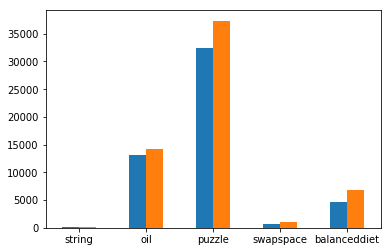

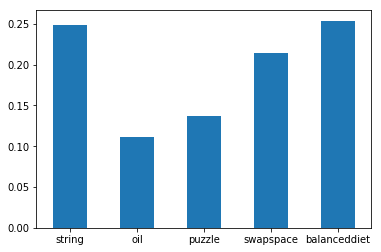

In [34]:
# cols = ['L-string', 'G-oil', 'H-puzzle', 'M-swapspace', 'A-balanceddiet']
cols = ['string', 'oil', 'puzzle', 'swapspace', 'balanceddiet']
heights = [164.2986552340313, 13038.414569178494, 32483.174946085615, 709.2243768771489, 4714.842436034863]
grd_heights = [163.72385922330093, 14149.93340909091, 37343.078499999996, 1033.6702499999997, 6897.966230769232]
mape = [0.24889799557055695, 0.1113574311094047, 0.13705447522411146, 0.2140232859079872, 0.2539663012728506]

heights = [[heights[i], grd_heights[i]] for i in range(len(grd_heights))]

df = pd.DataFrame(
#     {'time': heights, 'mape': mape}, 
    heights,
    index = cols)

print(df)
axes = df.plot.bar(legend = False, rot = 0)

df = pd.DataFrame(
#     {'time': heights, 'mape': mape}, 
    mape,
    index = cols)

print(df)
ax = df.plot.bar(legend = False, rot = 0)

# axes[1].legend(loc=2)  # doctest: +SKIP

# print(heights)
# print(cols)

# fig, ax = plt.subplots()
# positions = range(0, len(heights))
# ax.bar(positions, heights, 0.5)
# ax.set_yticks(range(0, 2))
# ax.set_xticklabels(cols, rotation=45)
# ax.set_xlabel('program')
# ax.set_ylabel('prediction and simulated time')
# # plt.plot(C_mat, column_headers)
# plt.show()

### Other ML Algorithms

#### DecisionTree

In [35]:
from sklearn import tree

total_avg = 0.0

for i in range(len(train_idx_list)):
    train_idx = train_idx_list[i]
    test_idx = test_idx_list[i]
    
    train_X = X[train_idx]
    train_y = Y[train_idx]
    val_X = X[test_idx]
    val_y = Y[test_idx]
    
    model = tree.DecisionTreeRegressor()
    model.fit(train_X,train_y)

    predictions = model.predict(val_X)
    print(len(val_y), len(predictions))

    sum = 0.0
    for j in range(len(predictions)):
        pred = predictions[j]
        grd = val_y[j]
        rel = (pred-grd)/grd
        sum += abs(rel)
#         print(pred, grd, rel)
    avg = sum / (len(predictions))
    print(sum, avg)
    total_avg += avg

total_avg = total_avg / len(train_idx_list)
print(total_avg)


127 127
48.2210228335037 0.3796930931771945
127 127
193.42345792461776 1.5230193537371477
126 126
42.434859068644585 0.33678459578289355
126 126
561.4362129259607 4.455842959729847
126 126
39.25210988934447 0.311524681661464
126 126
41.51265362867717 0.32946550498950133
126 126
165.95944817733837 1.3171384775979236
126 126
41.56129054285662 0.3298515122448938
126 126
528.2407860209398 4.192387190642379
126 126
107.18694186132566 0.8506900147724259
1.402639738433567


#### RandomForest

In [36]:
total_avg = 0.0

for i in range(len(train_idx_list)):
    train_idx = train_idx_list[i]
    test_idx = test_idx_list[i]
    
    train_X = X[train_idx]
    train_y = Y[train_idx]
    val_X = X[test_idx]
    val_y = Y[test_idx]
    
    model = RandomForestRegressor()
    model.fit(train_X,train_y)

    predictions = model.predict(val_X)
    print(len(val_y), len(predictions))

    sum = 0.0
    for j in range(len(predictions)):
        pred = predictions[j]
        grd = val_y[j]
        rel = (pred-grd)/grd
        sum += abs(rel)
#         print(pred, grd, rel)
    avg = sum / (len(predictions))
    print(sum, avg)
    total_avg += avg

total_avg = total_avg / len(train_idx_list)
print(total_avg)

127 127
48.57674432710652 0.38249404981973634
127 127
456.32647707511086 3.5931218667331564
126 126
76.17151912345015 0.6045358660591282
126 126
762.8794985401508 6.054599194763102
126 126
136.22188687309392 1.081126086294396
126 126
58.512614220987714 0.46438582715069615
126 126
183.91203991336653 1.4596193643917978
126 126
163.6714379198615 1.2989796660306467
126 126
359.95183574348454 2.8567606011387663
126 126
808.729468796026 6.4184878475875085
2.4214110369968935


#### XGBoost

In [37]:
total_avg = 0.0

for i in range(len(train_idx_list)):
    train_idx = train_idx_list[i]
    test_idx = test_idx_list[i]
    
    train_X = X[train_idx]
    train_y = Y[train_idx]
    val_X = X[test_idx]
    val_y = Y[test_idx]
    
    XGBModel = XGBRegressor()
    XGBModel.fit(train_X,train_y , verbose=False)

    predictions = XGBModel.predict(val_X)
    print(len(val_y), len(predictions))

    sum = 0.0
    for j in range(len(predictions)):
        pred = predictions[j]
        grd = val_y[j]
        rel = (pred-grd)/grd
        sum += abs(rel)
#         print(pred, grd, rel)
    avg = sum / (len(predictions))
    print(sum, avg)
    total_avg += avg

total_avg = total_avg / len(train_idx_list)
print(total_avg)

127 127
201.91937093158856 1.5899163065479414
127 127
255.44486327478327 2.011376876179396
126 126
169.99365853747818 1.3491560201387158
126 126
765.8219138205939 6.0779516969888405
126 126
168.38321528308762 1.3363747244689494
126 126
235.20710447677197 1.8667230514029522
126 126
321.9621999095408 2.5552555548376255
126 126
210.44746427112898 1.6702179704057856
126 126
314.2042428122572 2.4936844667639457
126 126
546.7510795017963 4.339294281760288
2.528995094949444
